# End-to-end project with Logistic Regression
   Author: Aleix López Pascual

**Abstract:** Two datasets are provided: courier’s lifetime dependent features and courier’s weekly variant features. Features are renamed for confidentiality purposes. We start with an exploratory analysis and data munging process. We deal with a multicollinearity problem. Then we create a Logistic Regression model. We tune our hyperparameters using Grid Search. Finally, we evaluate the model using the F1 score and the confusion matrix.

The main libraries involved in this project are:

* **Pandas** for data manipulation and ingestion
* **Matplotlib** and **seaborn** for data visualization
* **Numpy** for multidimensional array computing
* **sklearn** for machine learning and predictive modeling

In [206]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = 50

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression

# We tweak the style of this notebook a little bit to have centered plots.
import pylab as plot
params = { 
    'axes.labelsize': "large",
    'xtick.labelsize': 'x-large',
    'legend.fontsize': 20,
    'figure.dpi': 150,
    'figure.figsize': [25, 7]
}
plot.rcParams.update(params)

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Task 1: Exploratory Analysis and Data Munging

In this section we are going to cover the following steps: 

* **Data extraction**: we will load the datasets and have a first look at it.
* **Data cleaning**: we will detect and correct inaccurate records from the datasets and we will treat missing values.
* **Data visualization**: we will create some interesting charts that will spot correlations and hidden insights out of the data.
* **Feature engineering**: we will use the knowledge obtained from the exploratory data analysis to process and transform the features in such a way the data becomes manageable by a machine learning algorithm.
* **Data labeling**: We will label the data since there is no target variable in our datasets.

### Data extraction

In [207]:
df_lt = pd.read_csv('C:/Users/Aleix Lopez/Desktop/Data Science Test/Courier_lifetime_data.csv')
df_w = pd.read_csv('C:/Users/Aleix Lopez/Desktop/Data Science Test/Courier_weekly_data.csv')

In [208]:
print('df_lt shape:', df_lt.shape)
print('df_w shape:', df_w.shape)

df_lt shape: (7524, 3)
df_w shape: (4117, 19)


We start visualizing small samples of both datasets.

In [209]:
df_lt.head()

courier feature_1  feature_2
0      208         a       25.0
1      218         c        0.0
2      225         c        NaN
3      231         c        0.0
4      242         c        NaN

In [210]:
df_w.head()

courier  week  feature_1  feature_2  feature_3  feature_4  feature_5  \
0     3767     2          6         34         38     0.0789     0.9211   
1     3767     4         -1         42         37     0.0000     1.0000   
2     3767     5         24         41         43     0.0233     0.9767   
3     3767     6        -22         65         66     0.0606     0.9394   
4     6282     2          9         33         27     0.0741     0.9259   

   feature_6  feature_7  feature_8  feature_9  feature_10  feature_11  \
0   140.4737     0.1316  2162.4737     0.7632    7.340776           8   
1   135.5946     0.0811  2097.4054     0.9459   11.883784          19   
2   131.0930     0.0233  2043.8837     0.9302    7.072100          16   
3   120.1515     0.0000  2124.2727     0.7727    7.356567          33   
4   100.0000     0.0370  4075.7407     0.8889    8.501233           5   

   feature_12  feature_13  feature_14  feature_15  feature_16  feature_17  
0   20.208158    5.236316      0.8158   43.384804           1          19  
1   18.855405    5.689459      0.8919   35.078042           3          11  
2   18.925116    5.138605      0.9302   31.455285           1          10  
3   18.259697    4.704394      0.7879   34.252991           1          30  
4   26.863704    4.828519      0.8889   46.478114           1           4

We also generate descriptive statistics that summarize the central tendency, dispersion and shape of the dataset distributions, excluding NaN values. We analyze both numeric and object series.

In [211]:
df_lt.describe()

courier    feature_2
count    7524.000000  6588.000000
mean   518864.440324    26.373862
std    286880.574472    22.703621
min       208.000000   -61.000000
25%    275875.750000    20.000000
50%    529366.500000    25.000000
75%    803120.500000    32.000000
max    964240.000000   954.000000

In [212]:
df_lt.describe(include=['O'])

feature_1
count       7524
unique         4
top            b
freq        4456

In [213]:
df_w.describe()

courier         week    feature_1    feature_2    feature_3  \
count    4117.000000  4117.000000  4117.000000  4117.000000  4117.000000   
mean   366530.934418     4.910857    -3.702453    44.232208    55.691037   
std    128603.611959     3.364852    17.407331    24.007116    31.666550   
min      3767.000000     0.000000  -138.000000     1.000000     1.000000   
25%    280239.000000     2.000000   -12.000000    26.000000    31.000000   
50%    406936.000000     5.000000    -2.000000    41.000000    51.000000   
75%    467727.000000     8.000000     6.000000    59.000000    76.000000   
max    519341.000000    11.000000    77.000000   169.000000   189.000000   

         feature_4    feature_5    feature_6    feature_7     feature_8  \
count  4117.000000  4117.000000  4117.000000  4117.000000   4117.000000   
mean      0.068610     0.931390   104.331502     0.059339   3975.807328   
std       0.068999     0.068999     8.473348     0.064646   1237.055134   
min       0.000000     0.000000    92.857100     0.000000   1136.750000   
25%       0.018500     0.901200   100.000000     0.000000   2750.977800   
50%       0.054100     0.945900   100.465100     0.043500   4099.425000   
75%       0.098800     0.981500   104.766000     0.088200   4774.028200   
max       1.000000     1.000000   197.739100     0.666700  12593.900000   

         feature_9   feature_10   feature_11   feature_12   feature_13  \
count  4117.000000  4117.000000  4117.000000  4117.000000  4117.000000   
mean      0.767527     9.619359    20.266942    20.000994     5.211435   
std       0.136458     1.827863    12.460020     3.205479     0.961980   
min       0.000000     2.575000     0.000000     5.416667     3.270000   
25%       0.693700     8.424751    11.000000    18.168824     4.570099   
50%       0.785700     9.497961    19.000000    19.648810     5.072500   
75%       0.864200    10.607692    28.000000    21.335395     5.618522   
max       1.000000    20.546667    86.000000    66.400000    12.546923   

        feature_14   feature_15   feature_16  feature_17  
count  4117.000000  4117.000000  4117.000000  4117.00000  
mean      0.782381    68.655642     2.255526    12.78941  
std       0.164578    18.828885     1.542969    11.69108  
min       0.000000     2.957809     1.000000     1.00000  
25%       0.739100    57.839947     1.000000     5.00000  
50%       0.822200    71.653595     2.000000    10.00000  
75%       0.883700    82.180556     3.000000    17.00000  
max       1.000000   180.861111    13.000000   195.00000

##### Observations on the initial datasets:

* Since we do not know the name of the features, we do not have any domain knowledge to help us describe the features.
* There is no target variable in our datasets. All the variables are features that describe the couriers. We will assign the target variable later on.
* Courier represents the ID given to each courier. Same courier ID represents same courier in both datasets.
* Week is an integer discrete variable that can take values from [0,11].
* More unique courier IDs in the lifetime dataset than the weekly dataset. 
* As we will see when we label our data, the target variable is only assigned to those couriers in which the week feature is defined. Therefore, we need to merge both datasets using the keys from the weekly frame in order to add the features form the lifetime dataset.

In [214]:
df = pd.merge(df_w, df_lt, how='left', on='courier', suffixes=('', '_lt'))
df.head()

courier  week  feature_1  feature_2  feature_3  feature_4  feature_5  \
0     3767     2          6         34         38     0.0789     0.9211   
1     3767     4         -1         42         37     0.0000     1.0000   
2     3767     5         24         41         43     0.0233     0.9767   
3     3767     6        -22         65         66     0.0606     0.9394   
4     6282     2          9         33         27     0.0741     0.9259   

   feature_6  feature_7  feature_8  feature_9  feature_10  feature_11  \
0   140.4737     0.1316  2162.4737     0.7632    7.340776           8   
1   135.5946     0.0811  2097.4054     0.9459   11.883784          19   
2   131.0930     0.0233  2043.8837     0.9302    7.072100          16   
3   120.1515     0.0000  2124.2727     0.7727    7.356567          33   
4   100.0000     0.0370  4075.7407     0.8889    8.501233           5   

   feature_12  feature_13  feature_14  feature_15  feature_16  feature_17  \
0   20.208158    5.236316      0.8158   43.384804           1          19   
1   18.855405    5.689459      0.8919   35.078042           3          11   
2   18.925116    5.138605      0.9302   31.455285           1          10   
3   18.259697    4.704394      0.7879   34.252991           1          30   
4   26.863704    4.828519      0.8889   46.478114           1           4   

  feature_1_lt  feature_2_lt  
0            b          33.0  
1            b          33.0  
2            b          33.0  
3            b          33.0  
4            a          35.0

In [215]:
print('df shape:', df.shape)

df shape: (4117, 21)


In [216]:
df.describe()

courier         week    feature_1    feature_2    feature_3  \
count    4117.000000  4117.000000  4117.000000  4117.000000  4117.000000   
mean   366530.934418     4.910857    -3.702453    44.232208    55.691037   
std    128603.611959     3.364852    17.407331    24.007116    31.666550   
min      3767.000000     0.000000  -138.000000     1.000000     1.000000   
25%    280239.000000     2.000000   -12.000000    26.000000    31.000000   
50%    406936.000000     5.000000    -2.000000    41.000000    51.000000   
75%    467727.000000     8.000000     6.000000    59.000000    76.000000   
max    519341.000000    11.000000    77.000000   169.000000   189.000000   

         feature_4    feature_5    feature_6    feature_7     feature_8  \
count  4117.000000  4117.000000  4117.000000  4117.000000   4117.000000   
mean      0.068610     0.931390   104.331502     0.059339   3975.807328   
std       0.068999     0.068999     8.473348     0.064646   1237.055134   
min       0.000000     0.000000    92.857100     0.000000   1136.750000   
25%       0.018500     0.901200   100.000000     0.000000   2750.977800   
50%       0.054100     0.945900   100.465100     0.043500   4099.425000   
75%       0.098800     0.981500   104.766000     0.088200   4774.028200   
max       1.000000     1.000000   197.739100     0.666700  12593.900000   

         feature_9   feature_10   feature_11   feature_12   feature_13  \
count  4117.000000  4117.000000  4117.000000  4117.000000  4117.000000   
mean      0.767527     9.619359    20.266942    20.000994     5.211435   
std       0.136458     1.827863    12.460020     3.205479     0.961980   
min       0.000000     2.575000     0.000000     5.416667     3.270000   
25%       0.693700     8.424751    11.000000    18.168824     4.570099   
50%       0.785700     9.497961    19.000000    19.648810     5.072500   
75%       0.864200    10.607692    28.000000    21.335395     5.618522   
max       1.000000    20.546667    86.000000    66.400000    12.546923   

        feature_14   feature_15   feature_16  feature_17  feature_2_lt  
count  4117.000000  4117.000000  4117.000000  4117.00000   3775.000000  
mean      0.782381    68.655642     2.255526    12.78941     30.658013  
std       0.164578    18.828885     1.542969    11.69108     12.572835  
min       0.000000     2.957809     1.000000     1.00000    -61.000000  
25%       0.739100    57.839947     1.000000     5.00000     25.000000  
50%       0.822200    71.653595     2.000000    10.00000     31.000000  
75%       0.883700    82.180556     3.000000    17.00000     38.000000  
max       1.000000   180.861111    13.000000   195.00000     66.000000

In [217]:
df.describe(include=['O'])

feature_1_lt
count          4117
unique            4
top               a
freq           2570

In [218]:
print('Number of missing values in feature_2_lt:', df.feature_2_lt.isnull().sum())

Number of missing values in feature_2_lt: 342


In [219]:
print('Number of unique values in feature_16:', df.feature_16.nunique())
print('Most frequent value in feature_16:', df.feature_16.value_counts().idxmax())
print('Frequency of the most frequent value in feature_16:', df.feature_16.value_counts().max())

Number of unique values in feature_16: 11
Most frequent value in feature_16: 1
Frequency of the most frequent value in feature_16: 1715


##### Observations on the new dataset (df):

* Some of the courier-week combinations’ data are not provided. The labeling of data will be based on this.
* We have 342 missing values in the feature_2_lt column.
* All features are numerical except for feature_16 and feature_1_lt which are categorical. This will help us select the appropriate plots for visualization.
* Feature_16 takes 11 possible values. The most common value is '1' with 1715 counts.
* Feature_1_lt takes 4 possible values. The most common value is 'a' with 2570 counts.

### Data cleaning

We are going to detect and correct corrupt or missing records from the database. We have seen that the only column which contains missing values is feature_2_lt. However, there may be outliers in any of the features.

#### Correcting feature_2_lt

In [220]:
print('Number of unique values in feature_2_lt:', df.feature_2_lt.nunique())

Number of unique values in feature_2_lt: 47


In [221]:
df.feature_2_lt.value_counts().sort_index()

-61.0      4
 0.0     260
 1.0      17
 18.0      7
 19.0     37
 20.0     78
 21.0     75
 22.0    121
 23.0    127
 24.0    194
 25.0     99
 26.0    199
 27.0    183
 28.0    162
 29.0    121
 30.0    166
 31.0     74
 32.0    146
 33.0    208
 34.0     86
 35.0    194
 36.0    125
 37.0    100
 38.0    114
 39.0     73
 40.0    104
 41.0     81
 42.0    100
 43.0     44
 44.0     44
 45.0     43
 46.0     73
 47.0     46
 48.0     38
 49.0     22
 50.0     33
 51.0     29
 52.0     13
 53.0     59
 54.0     12
 55.0      3
 57.0     10
 58.0     30
 60.0      6
 61.0      6
 63.0      7
 66.0      2
Name: feature_2_lt, dtype: int64

After analyzing the possible values, we find out some outliers [-61,0,1]. We eliminate them from the data (NaN values).

In [222]:
df.loc[(df.feature_2_lt == -61) | (df.feature_2_lt == 0) | (df.feature_2_lt == 1),['feature_2_lt']] = np.nan

Now, we describe the feature again.

In [223]:
df.feature_2_lt.describe()

count    3494.000000
mean       33.188609
std         8.973491
min        18.000000
25%        26.000000
50%        32.000000
75%        39.000000
max        66.000000
Name: feature_2_lt, dtype: float64

In [224]:
print('Number of unique values in feature_2_lt:', df.feature_2_lt.nunique())

Number of unique values in feature_2_lt: 44


In [225]:
print('Number of missing values in feature_2_lt:', df.feature_2_lt.isnull().sum())

Number of missing values in feature_2_lt: 623


##### Observations on feature_2_lt:

* It contains outliers [-61,0,1]. We have eliminated them.
* It contains 623 missing values of 4117 (~ 15% of the dataset).
* It is a lifetime feature, ie same value for the same courier. Consequently, it contains a high ratio of duplicate values (unique = 44).
* It is an integer discrete variable that can take values from [18,66].
* The mean value is 33.
* We can identify the feature as the age.

#### Features that do not require correction

We show the univariate studies that we have performed to each feature in order to identify outliers.

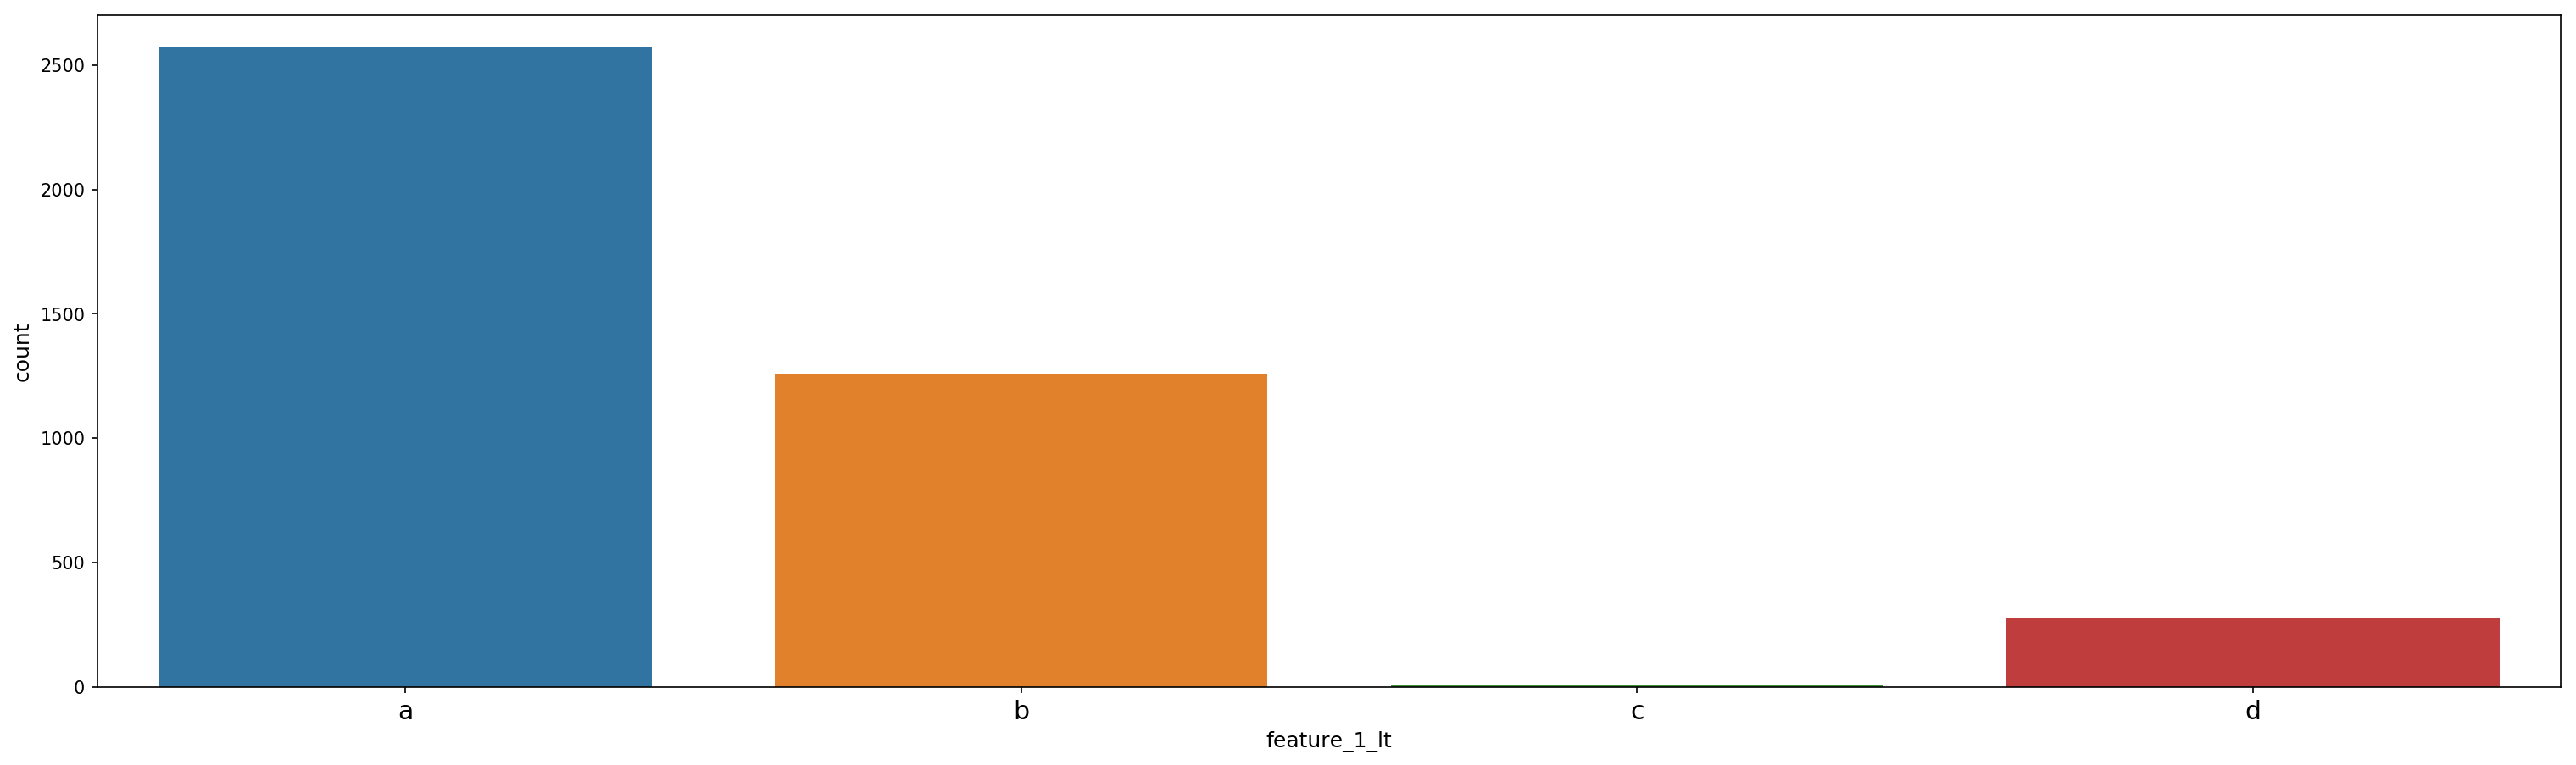

In [226]:
sns.countplot(df.feature_1_lt, order = ['a','b','c','d'])

In [227]:
df.feature_1_lt.value_counts().sort_index()

a    2570
b    1260
c       6
d     281
Name: feature_1_lt, dtype: int64

Even though there are little counts of the value 'c', we have not considered it as an outlier since it is a categorical variable and there is the pattern [a,b,c,d].

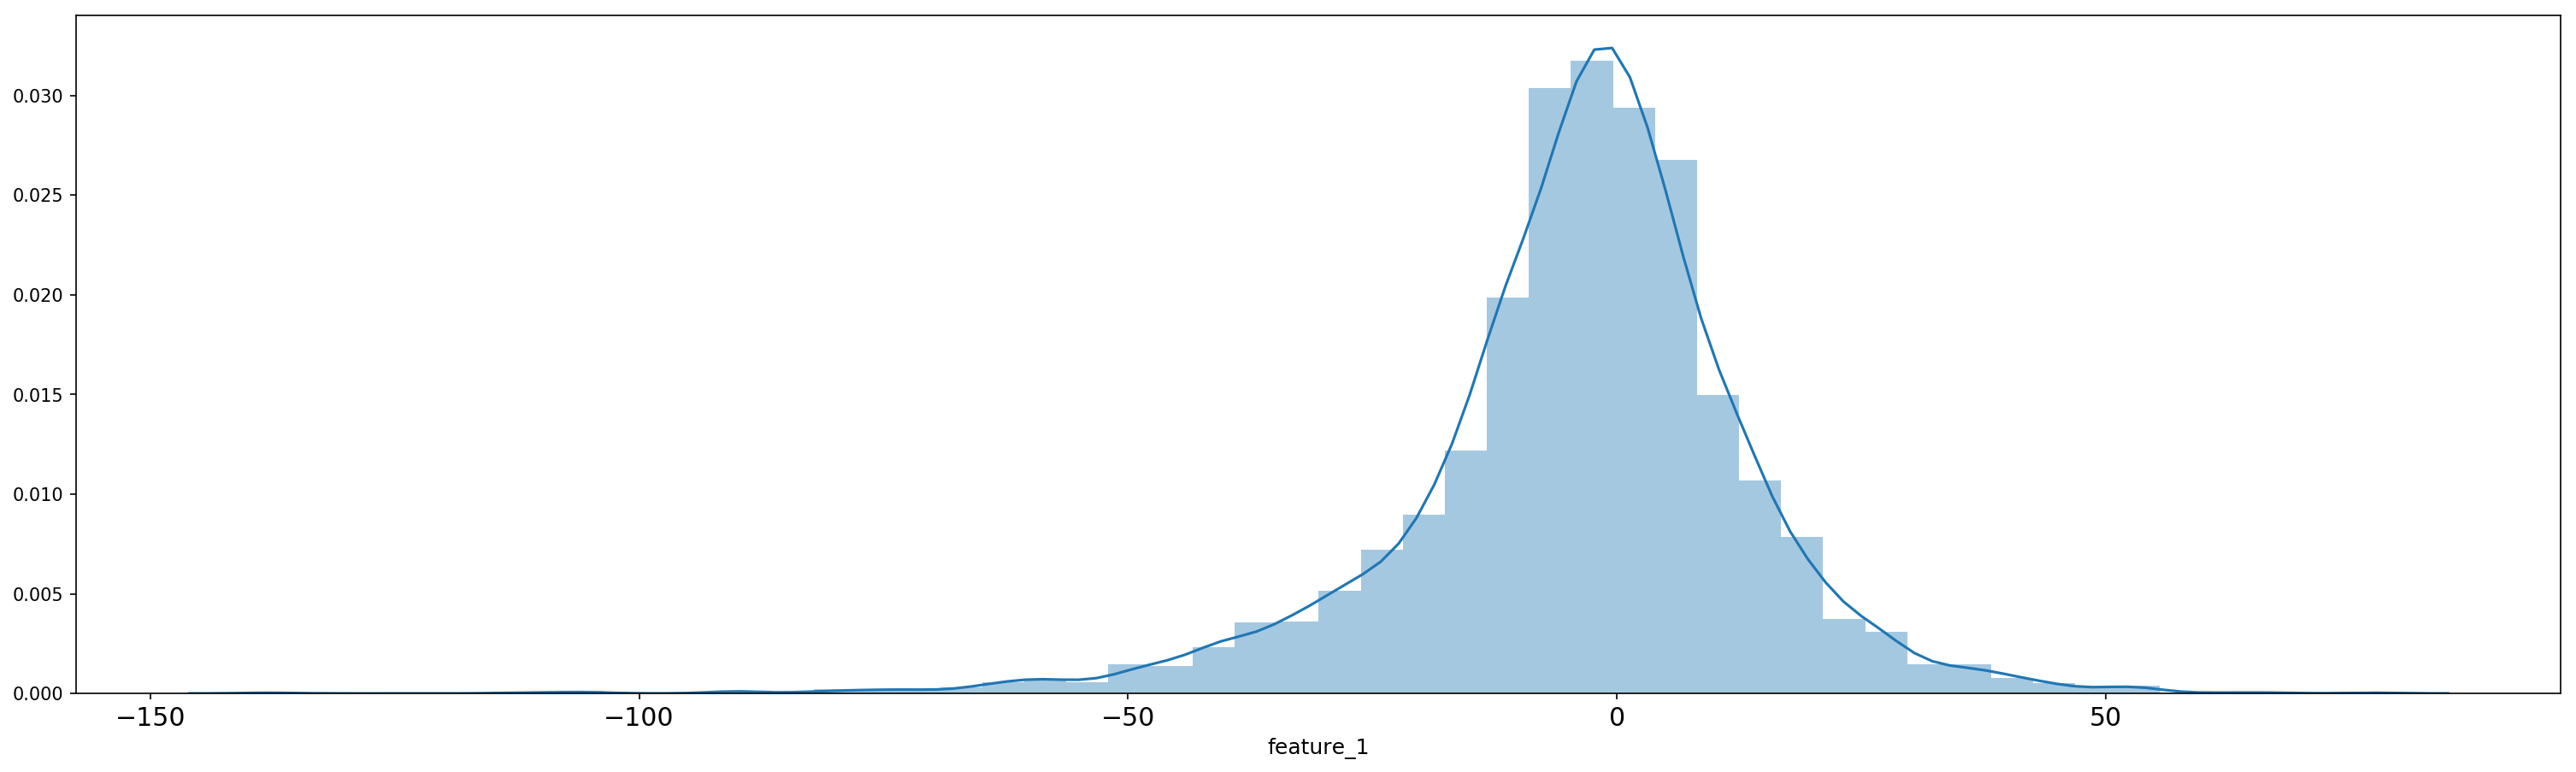

In [228]:
sns.distplot(df.feature_1)

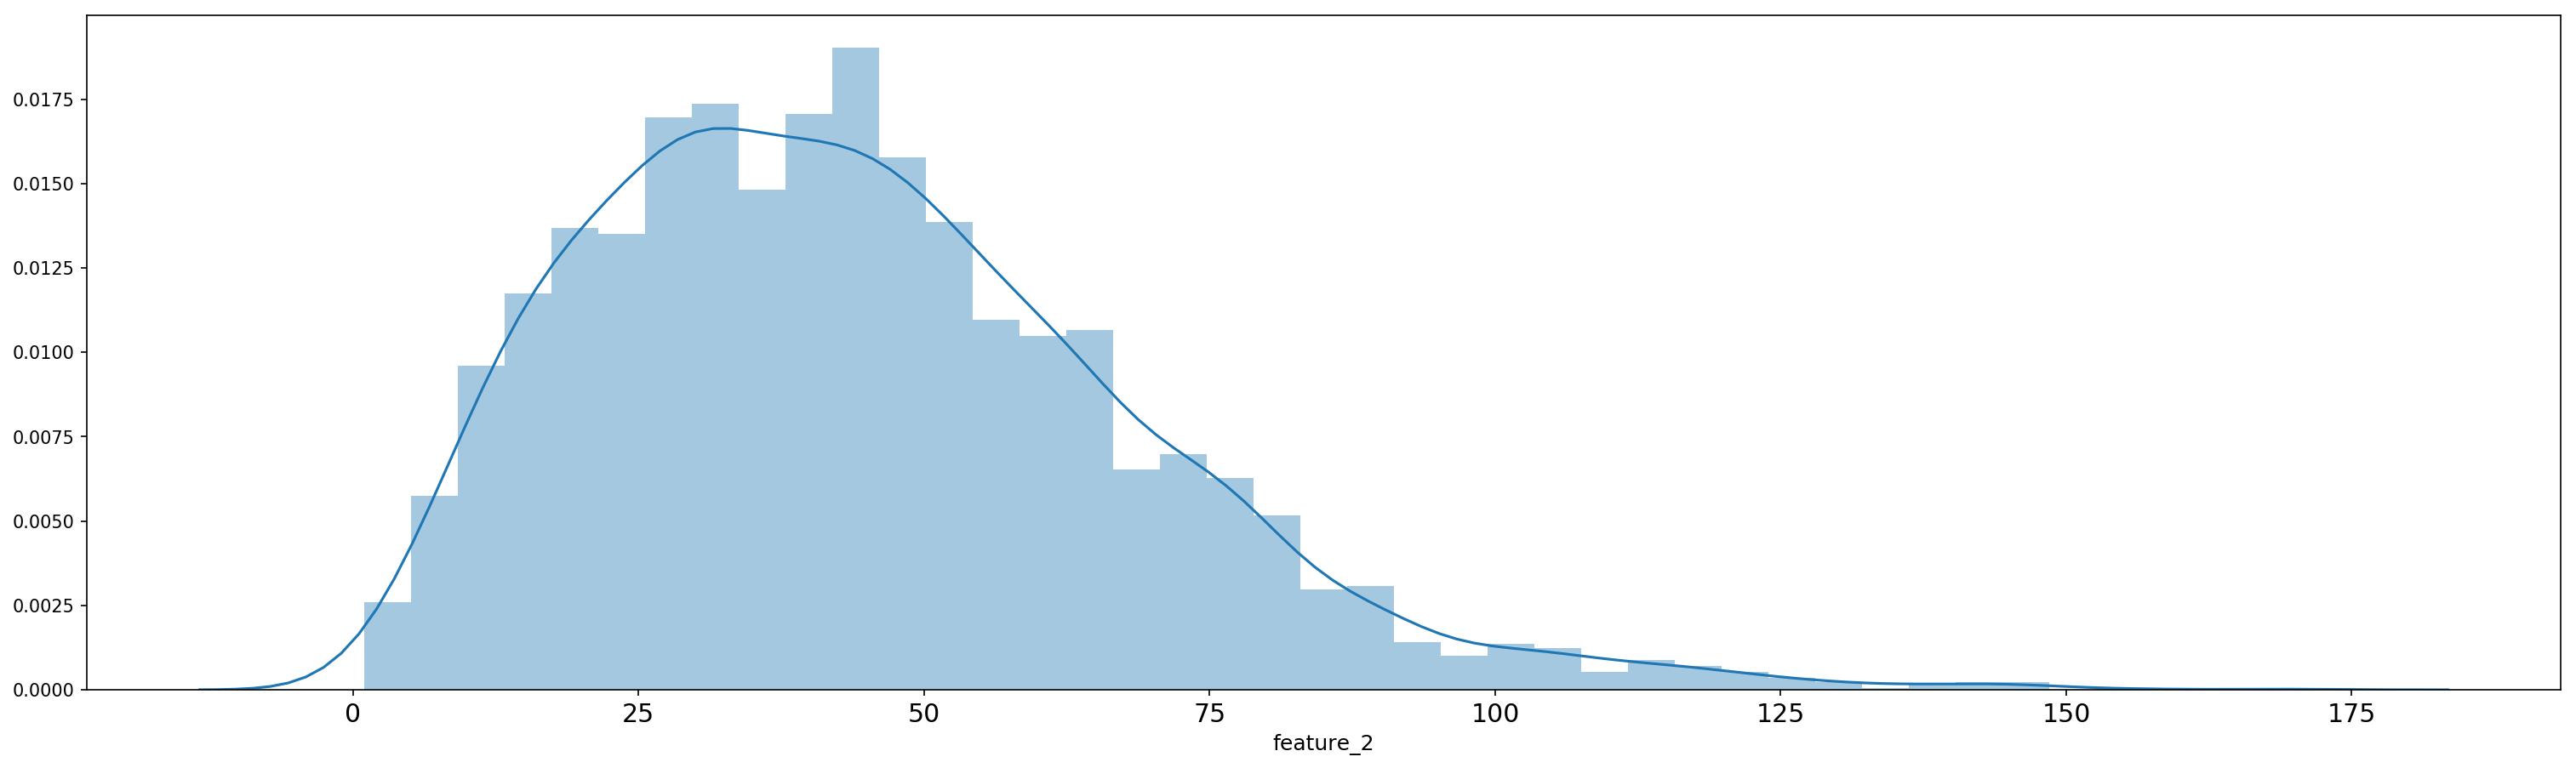

In [229]:
sns.distplot(df.feature_2)

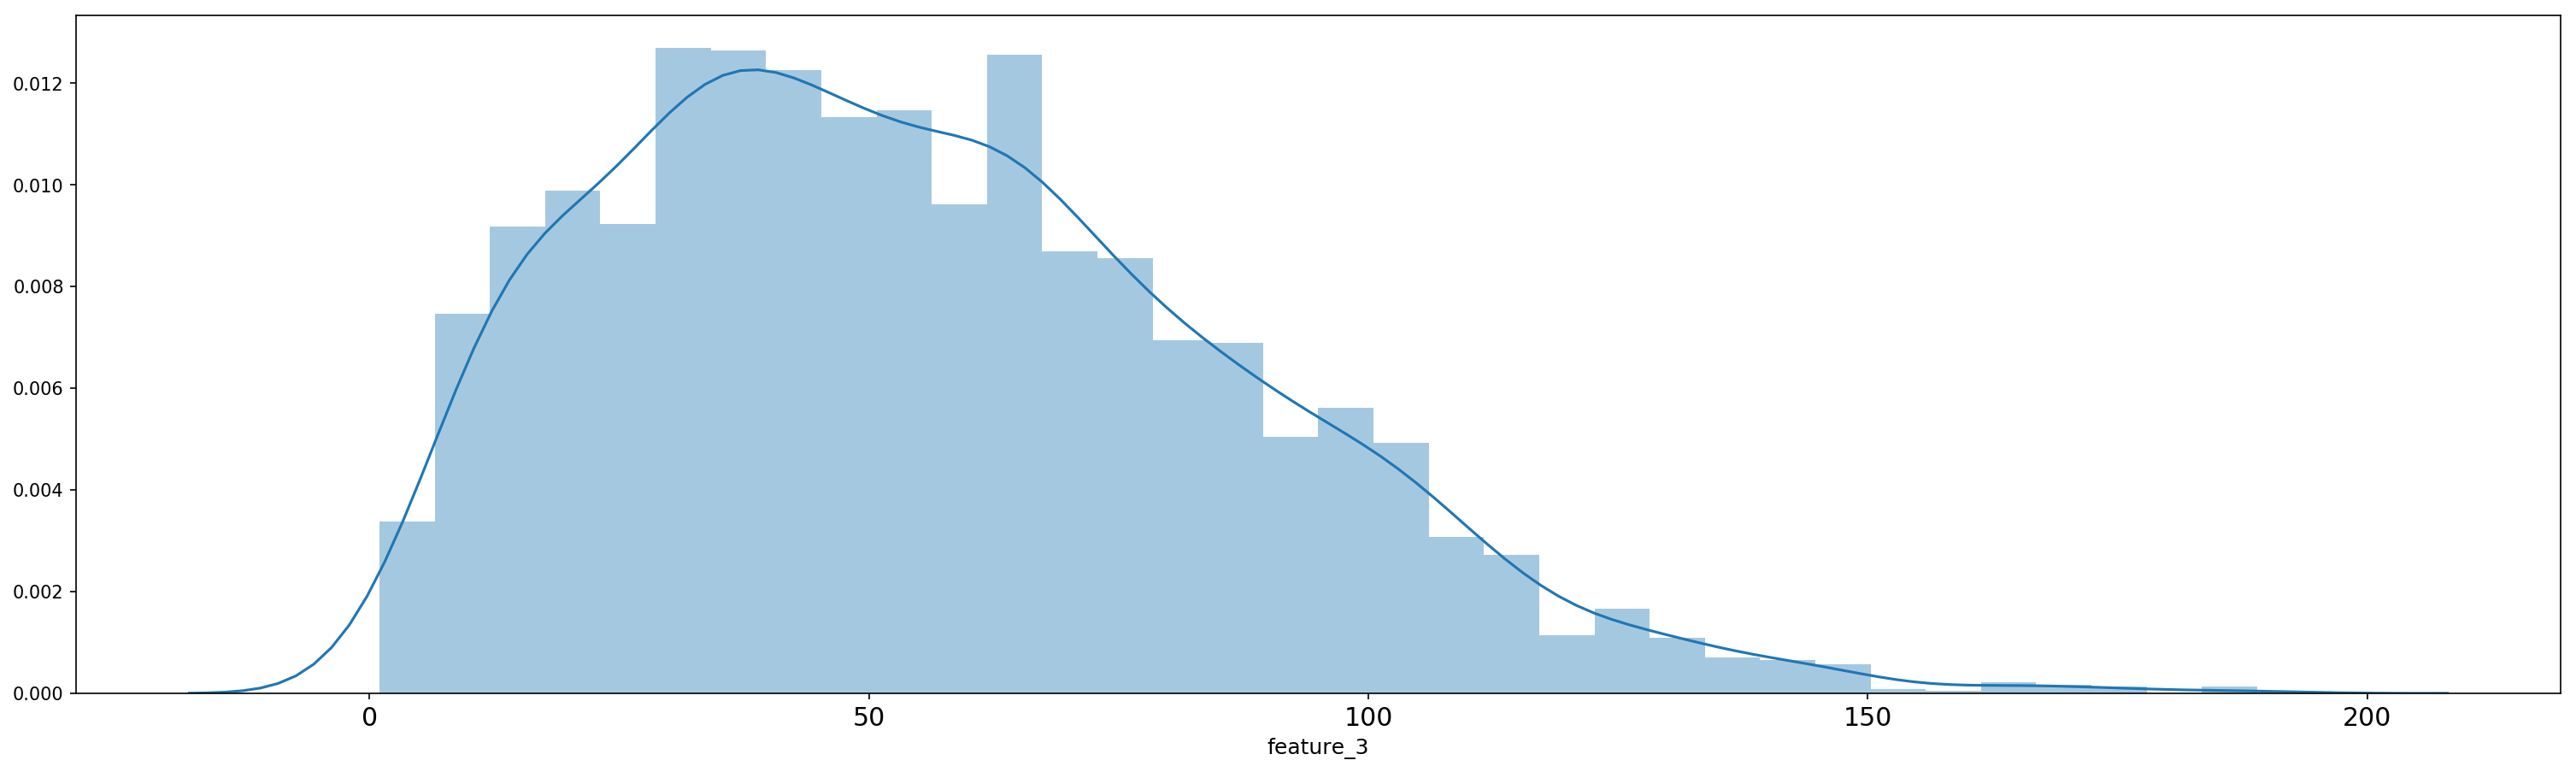

In [230]:
sns.distplot(df.feature_3)

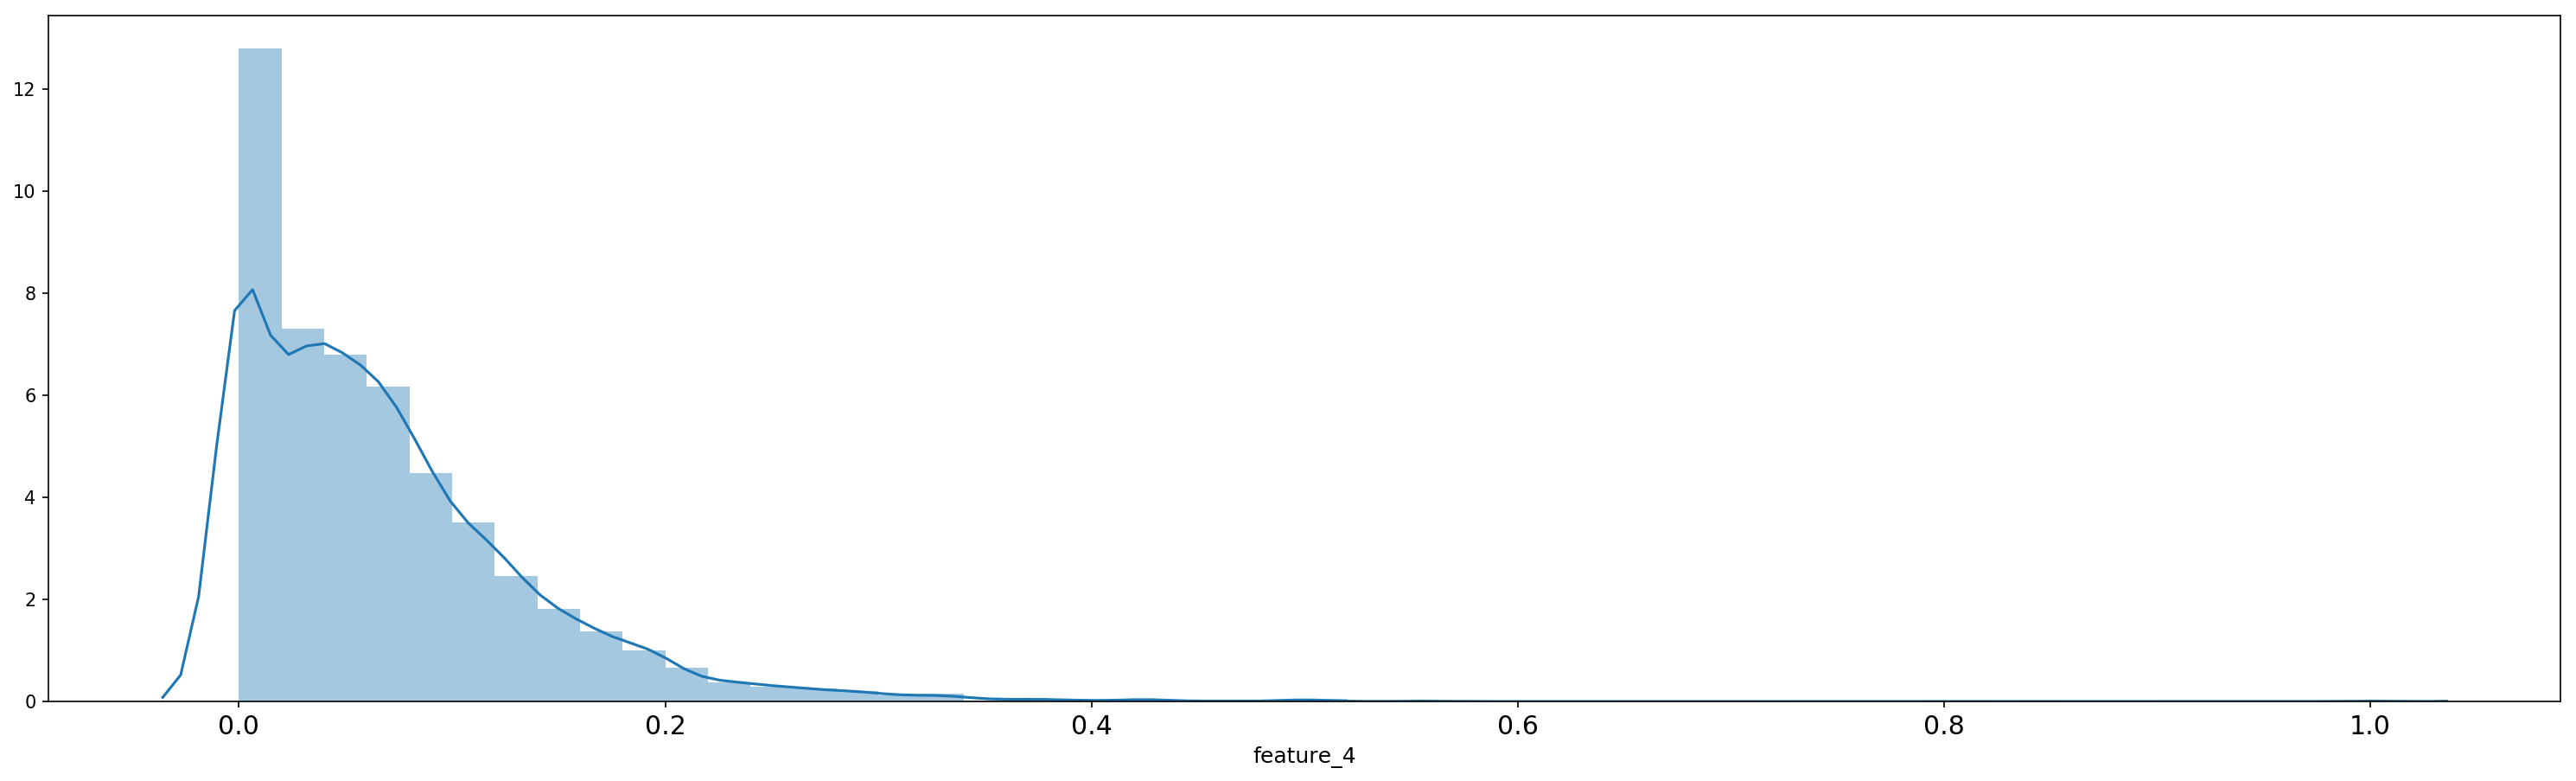

In [231]:
sns.distplot(df.feature_4)

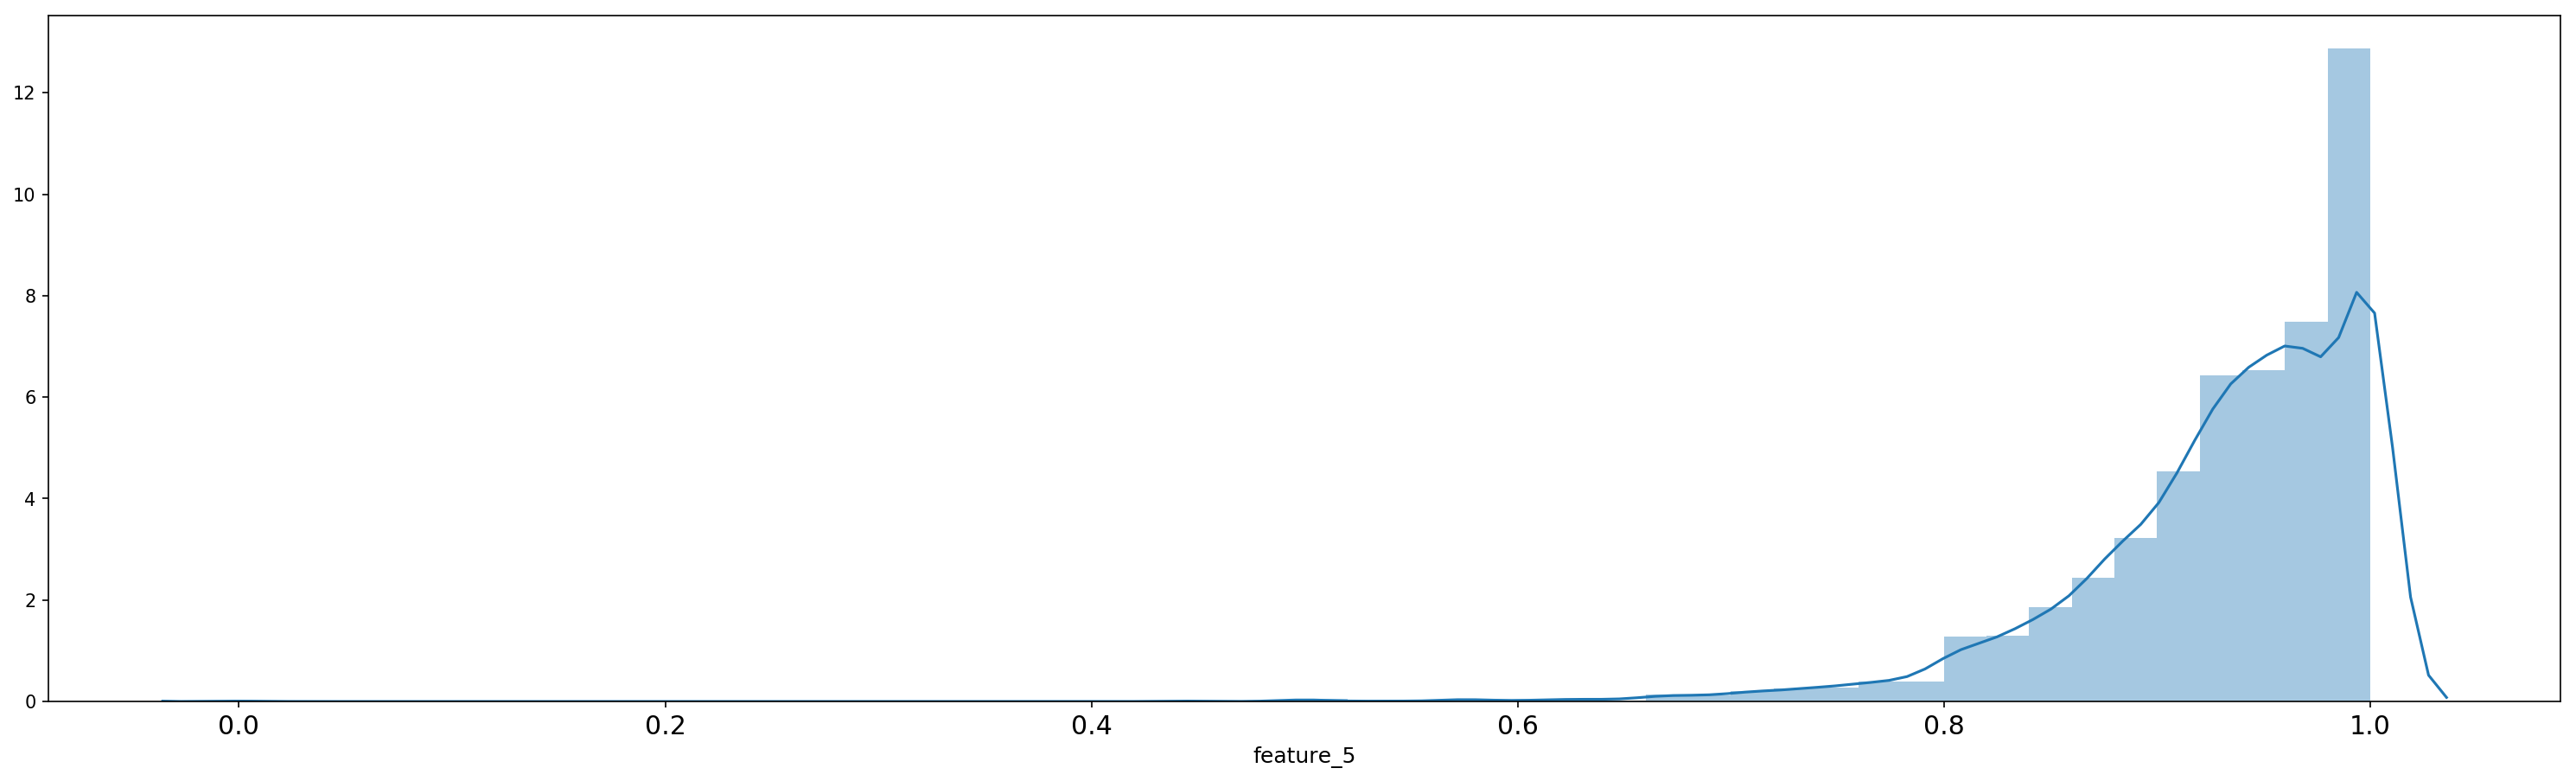

In [232]:
sns.distplot(df.feature_5)

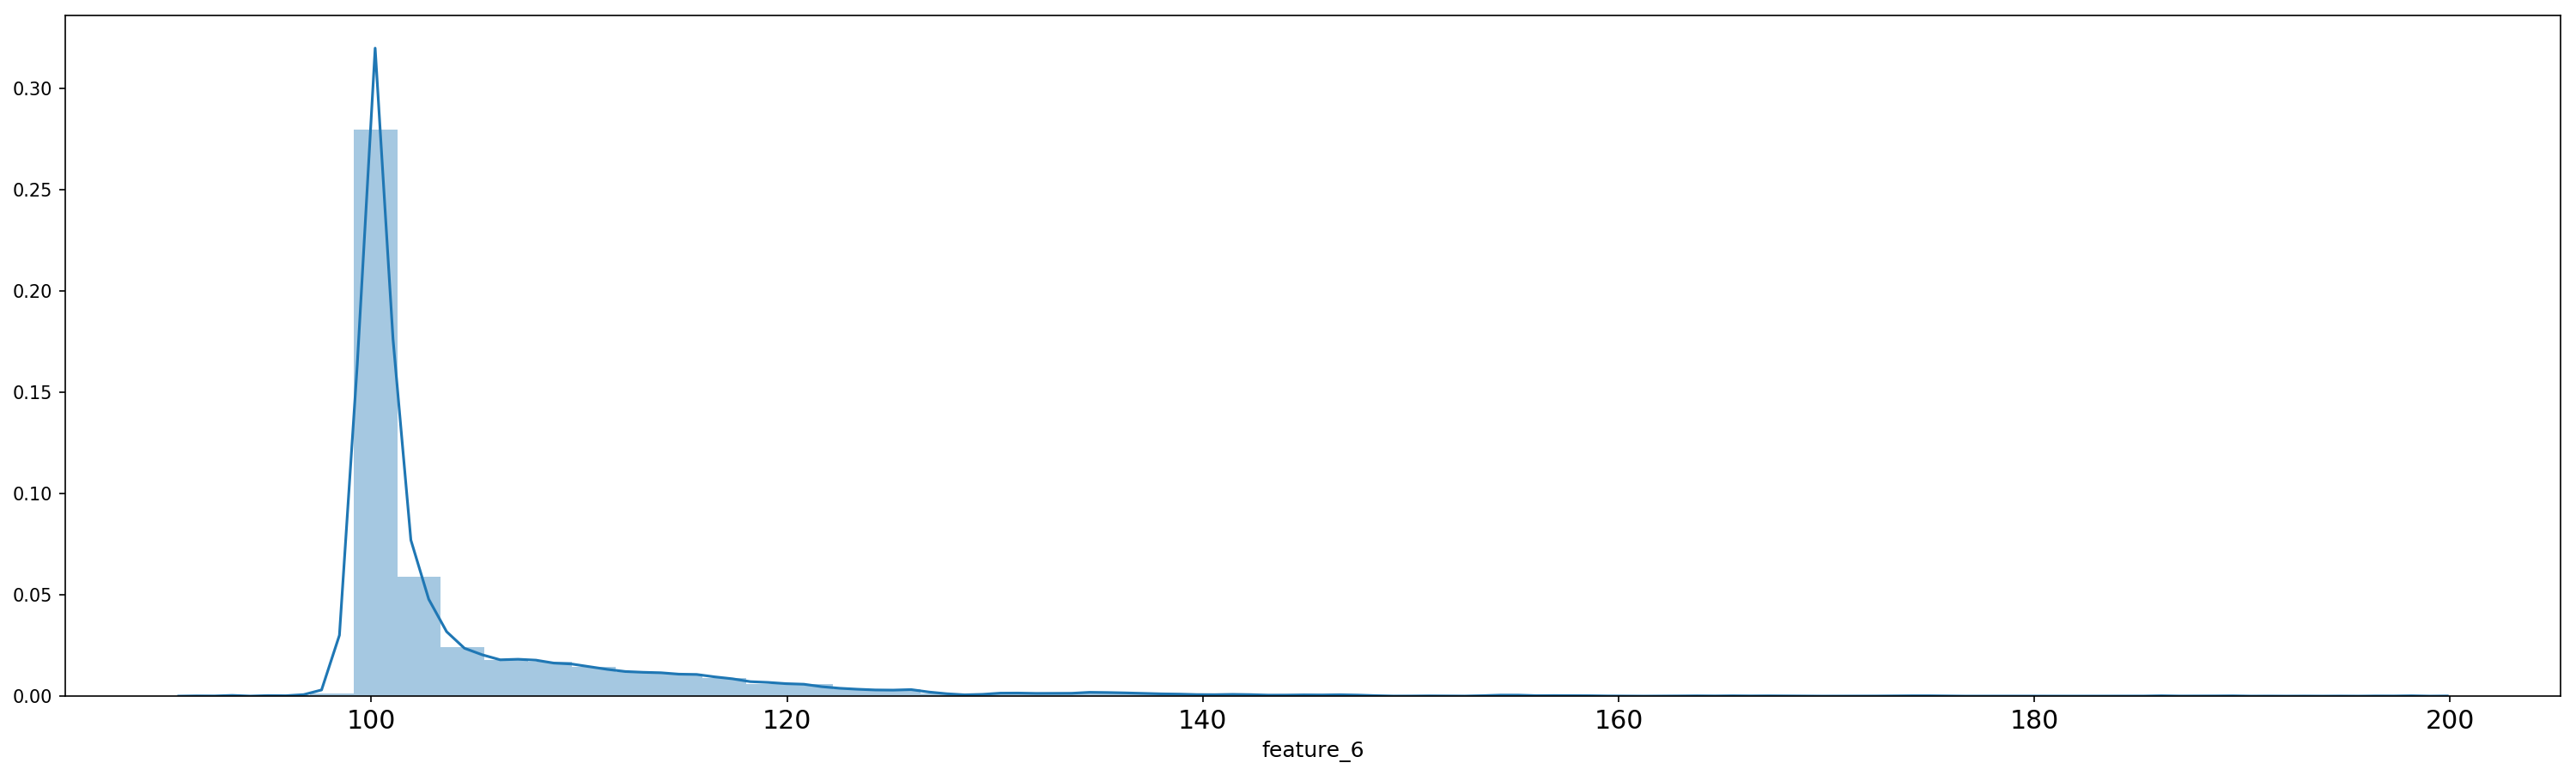

In [233]:
sns.distplot(df.feature_6)

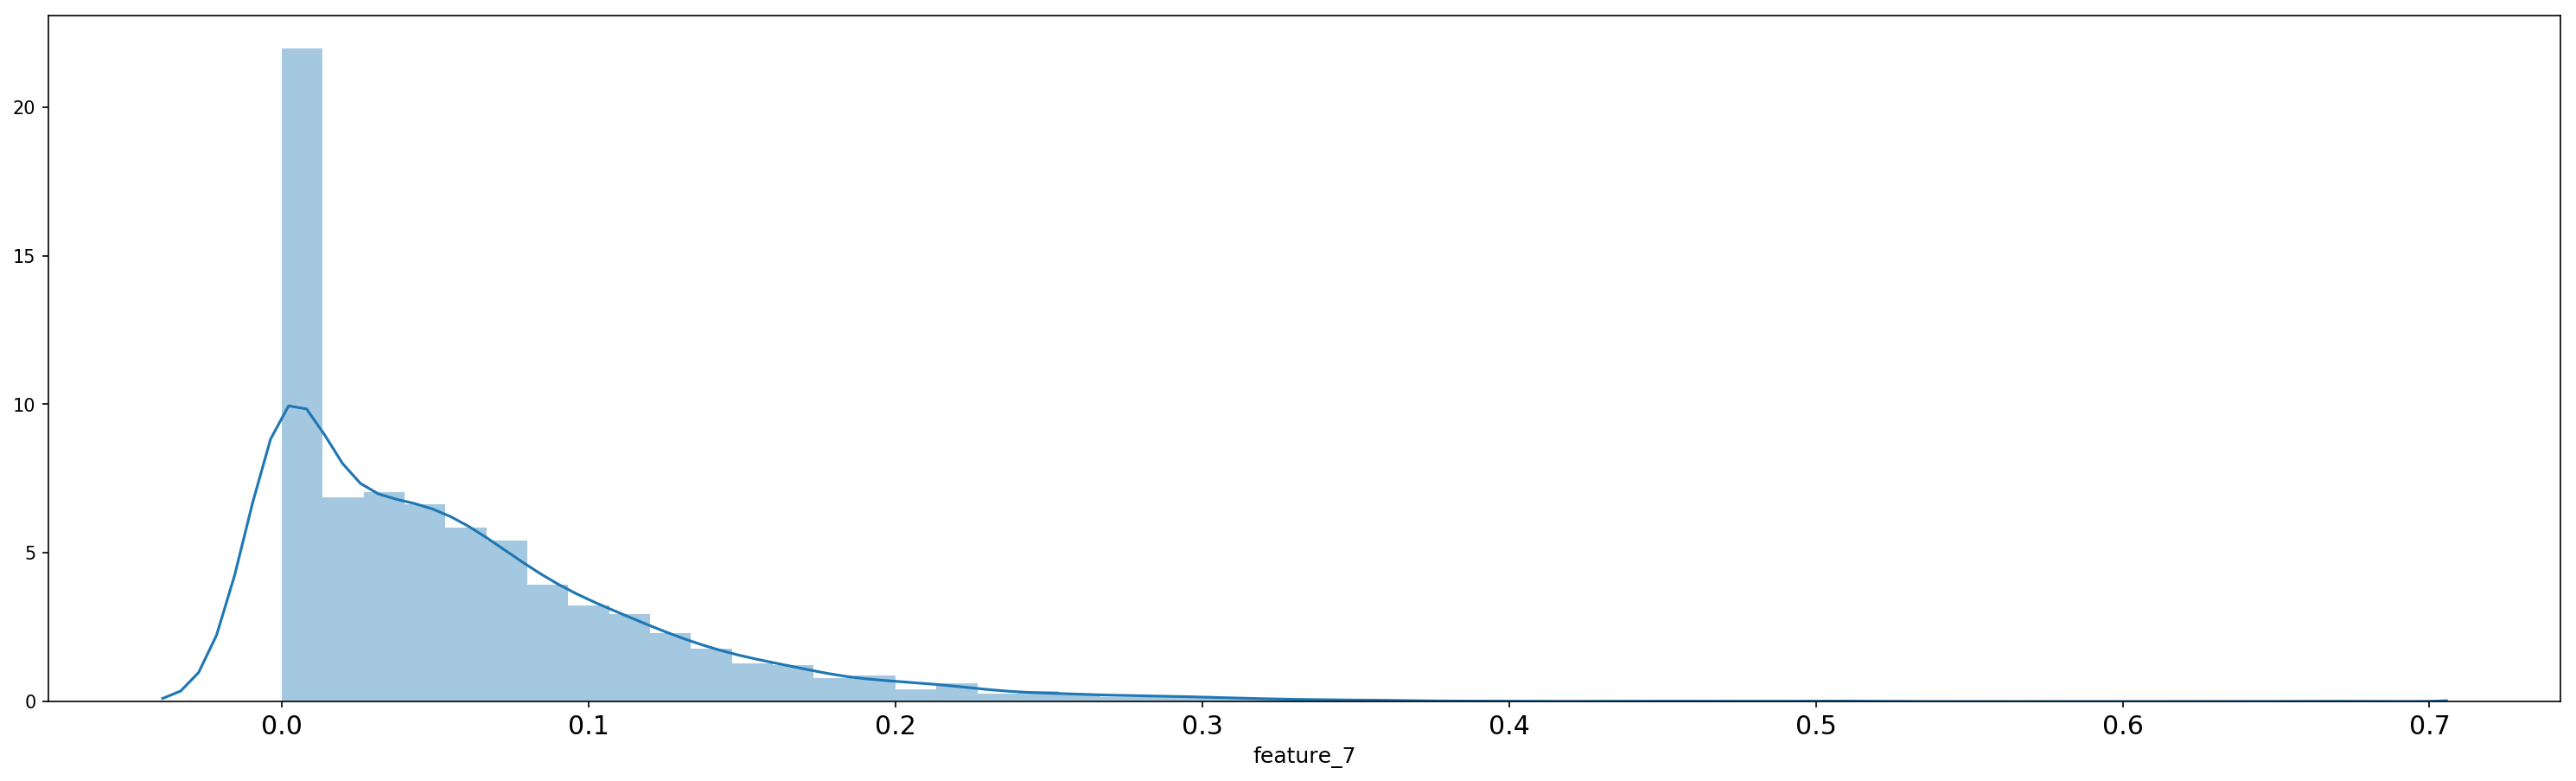

In [234]:
sns.distplot(df.feature_7)

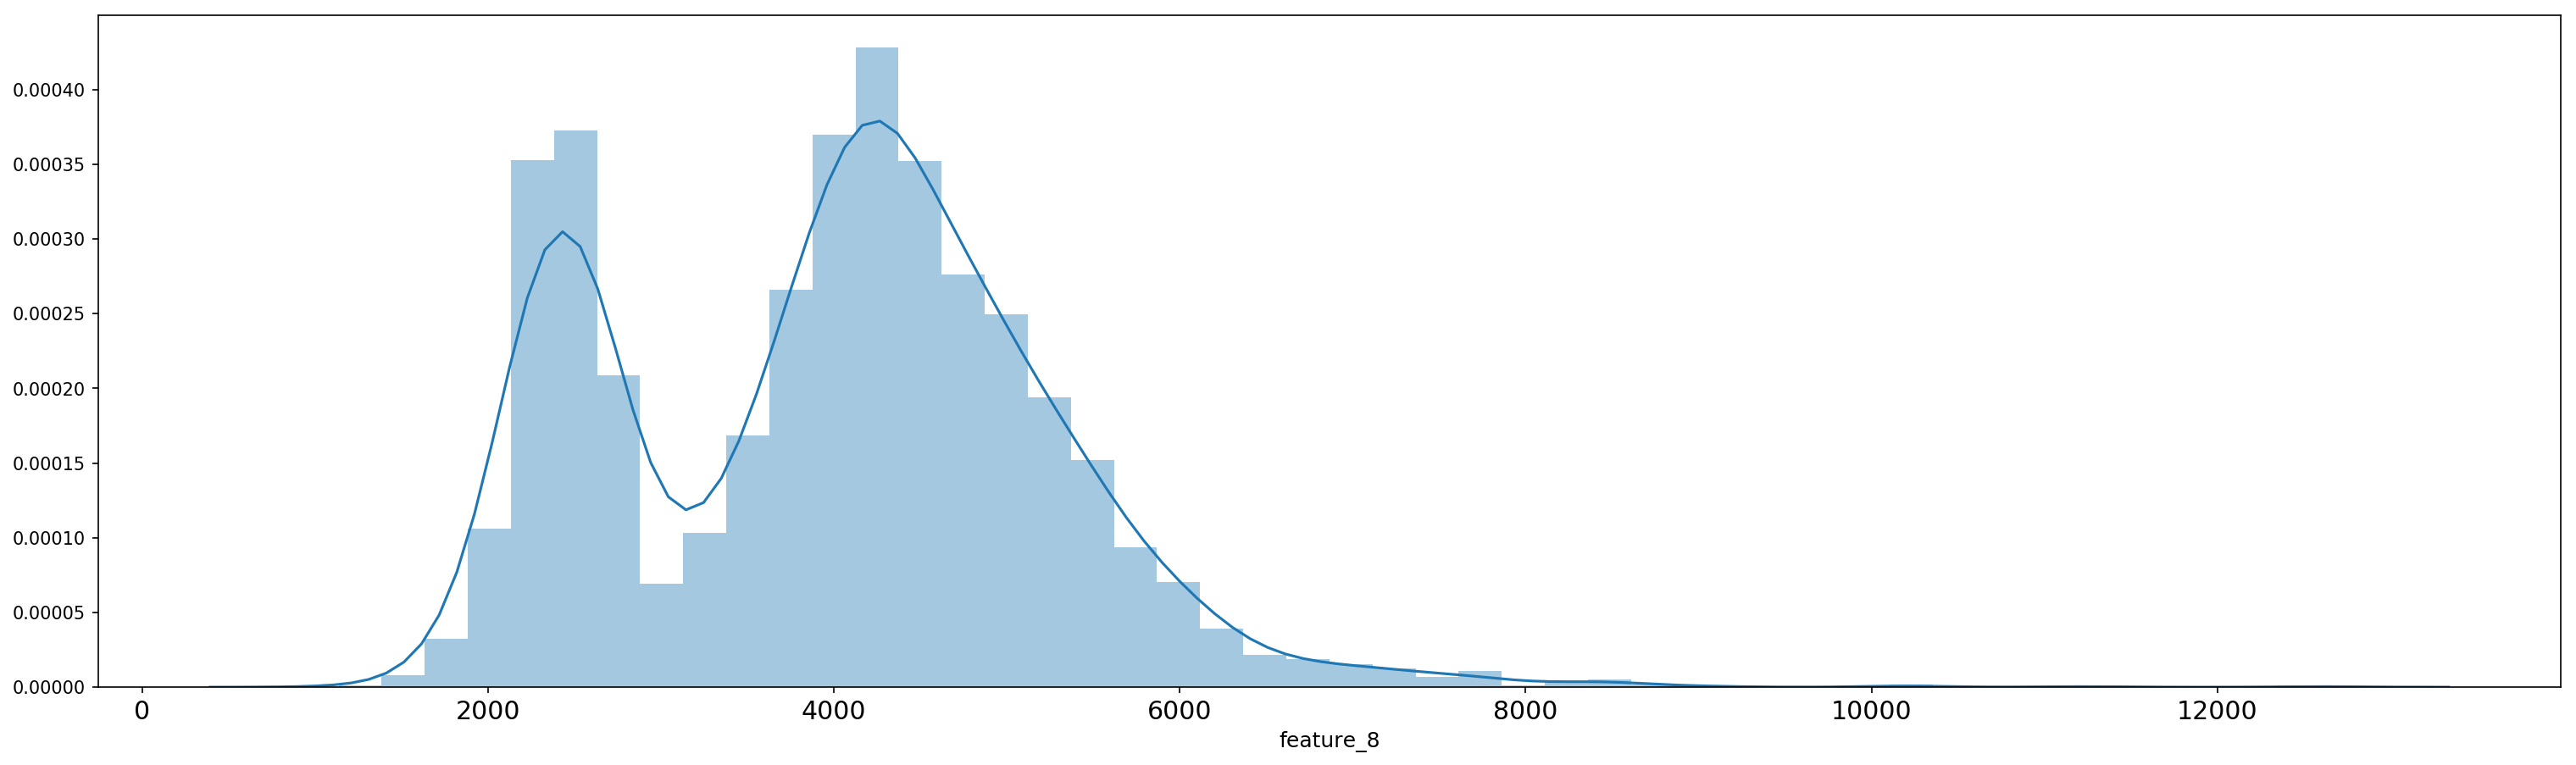

In [235]:
sns.distplot(df.feature_8)

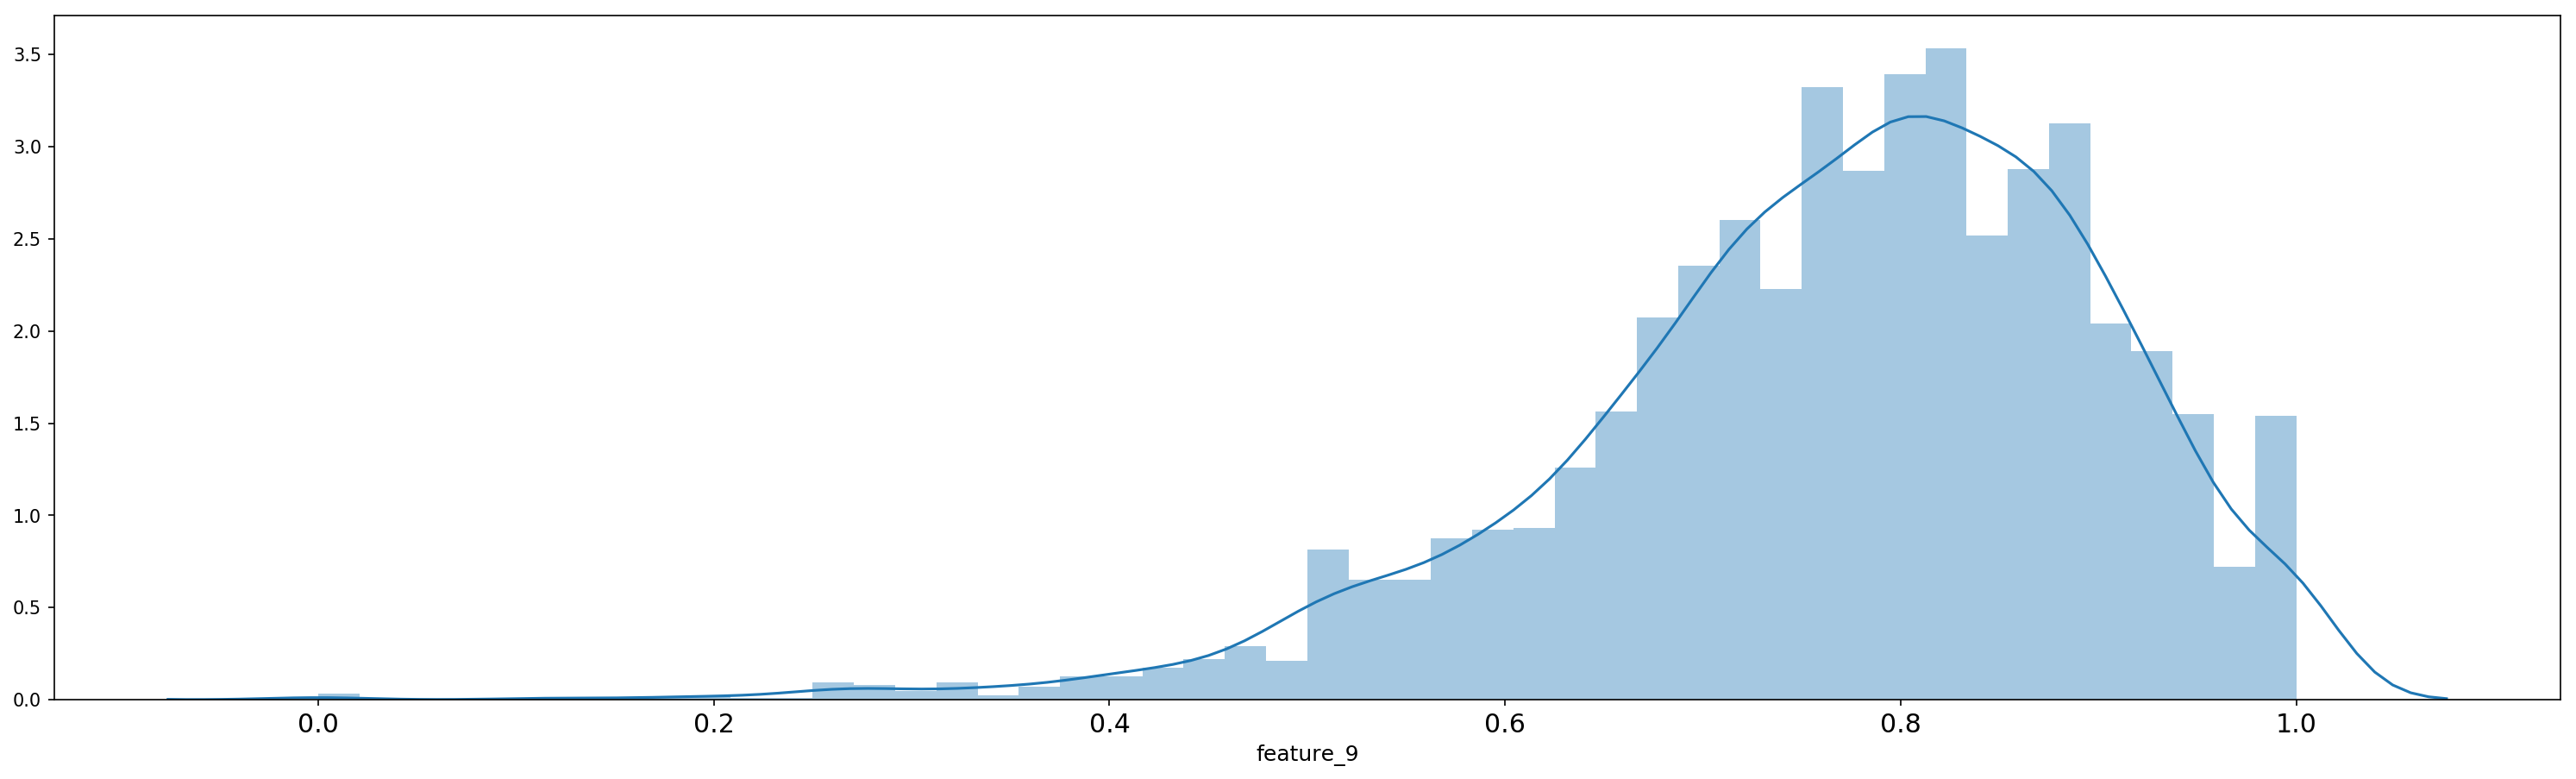

In [236]:
sns.distplot(df.feature_9)

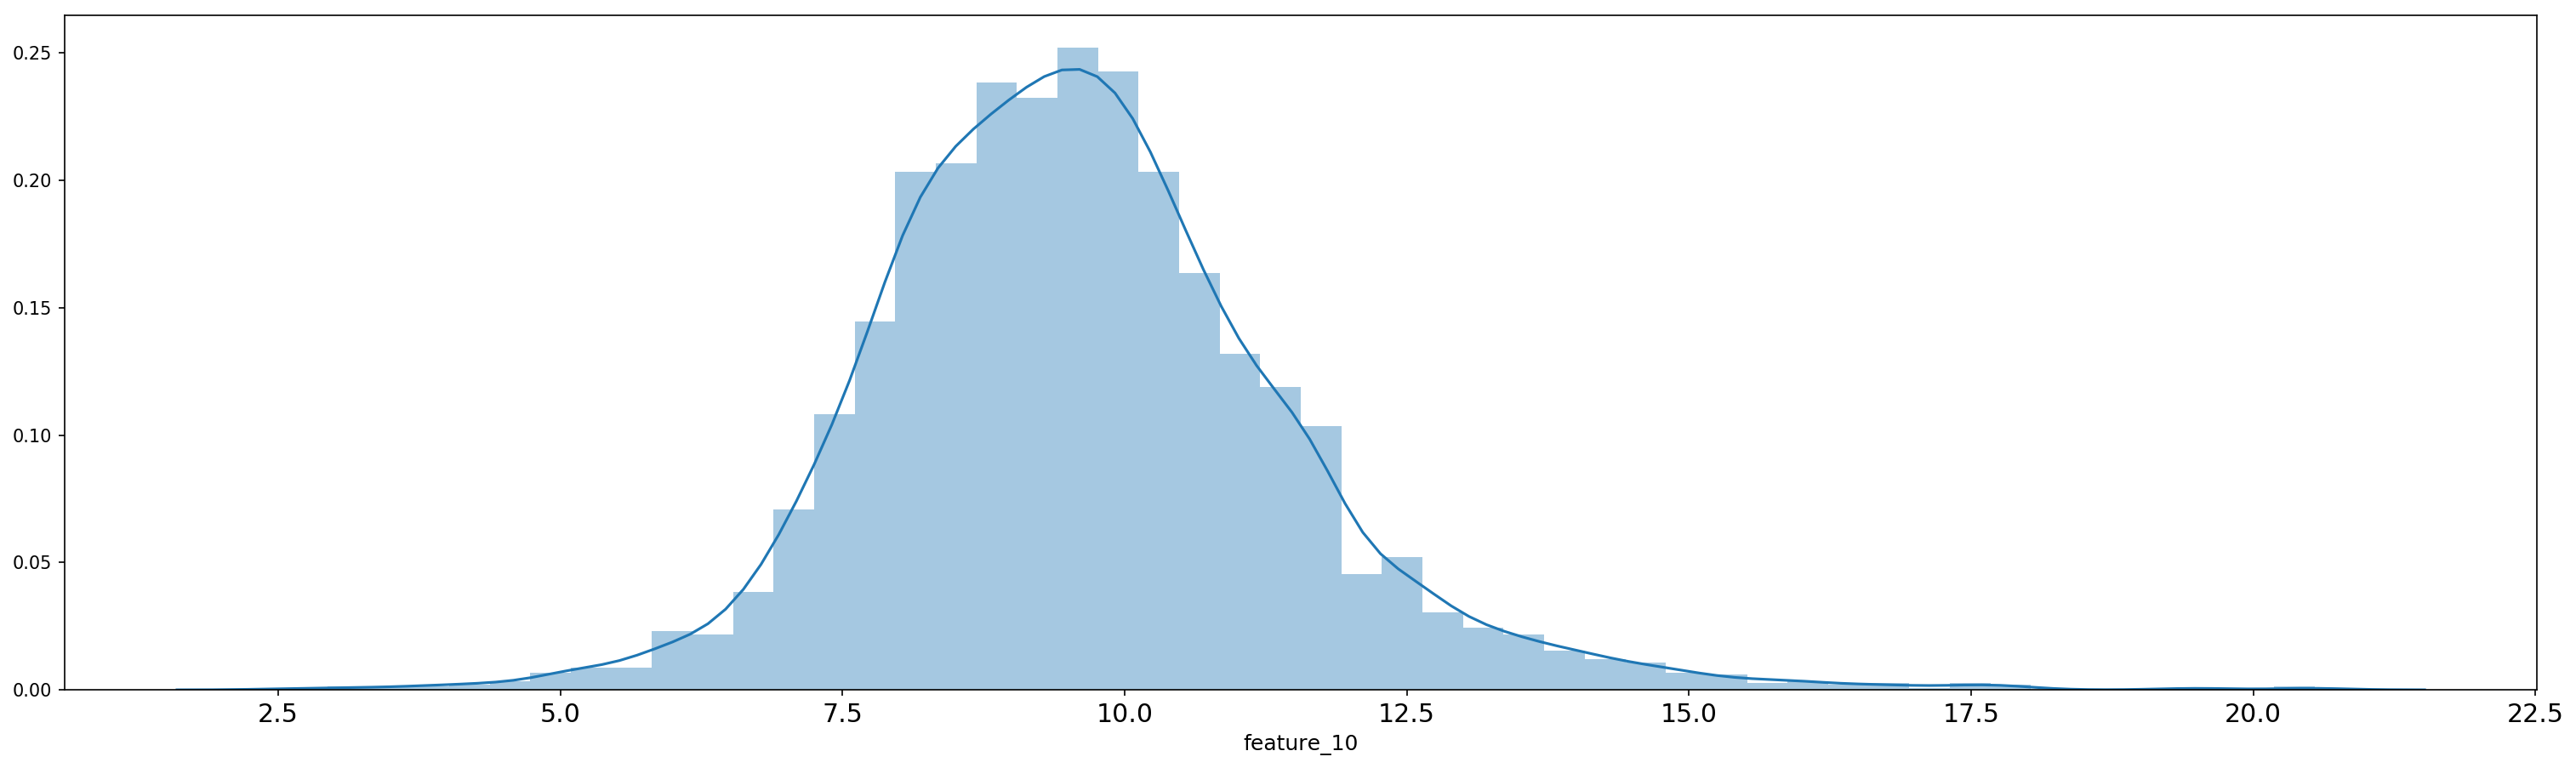

In [237]:
sns.distplot(df.feature_10)

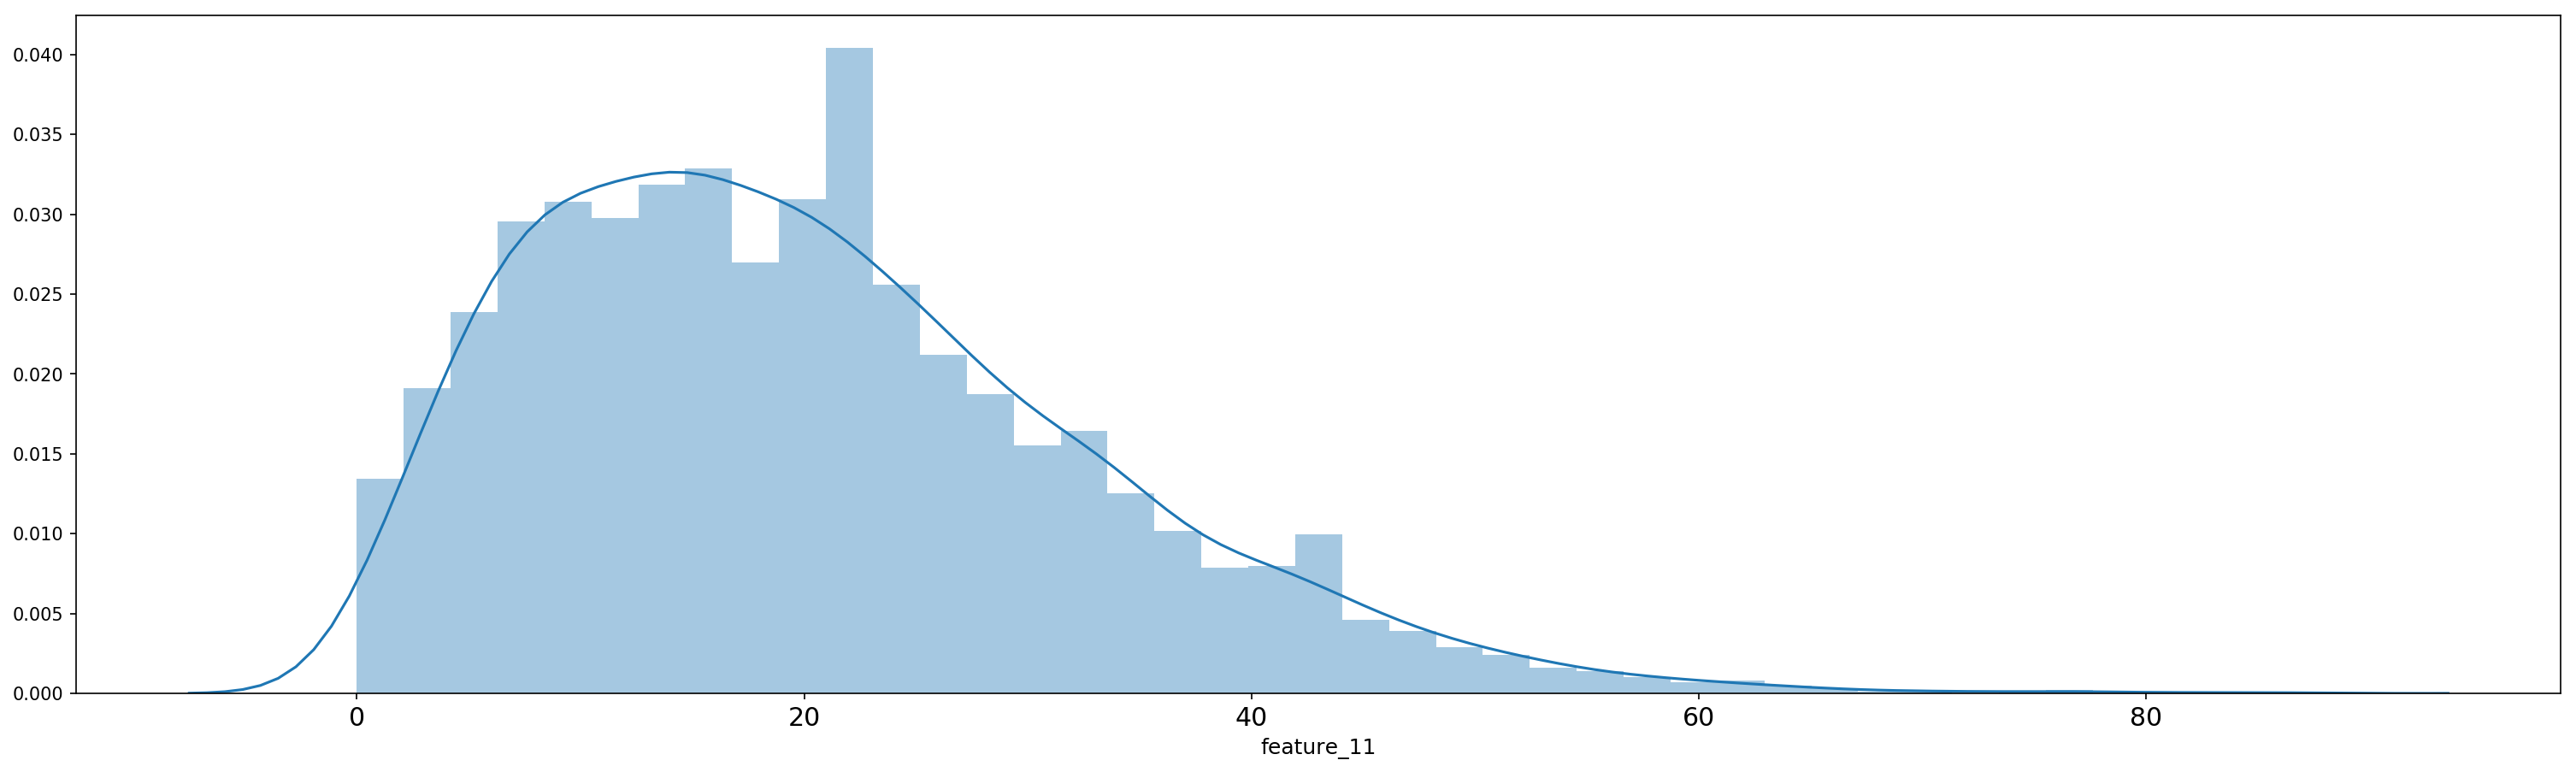

In [238]:
sns.distplot(df.feature_11)

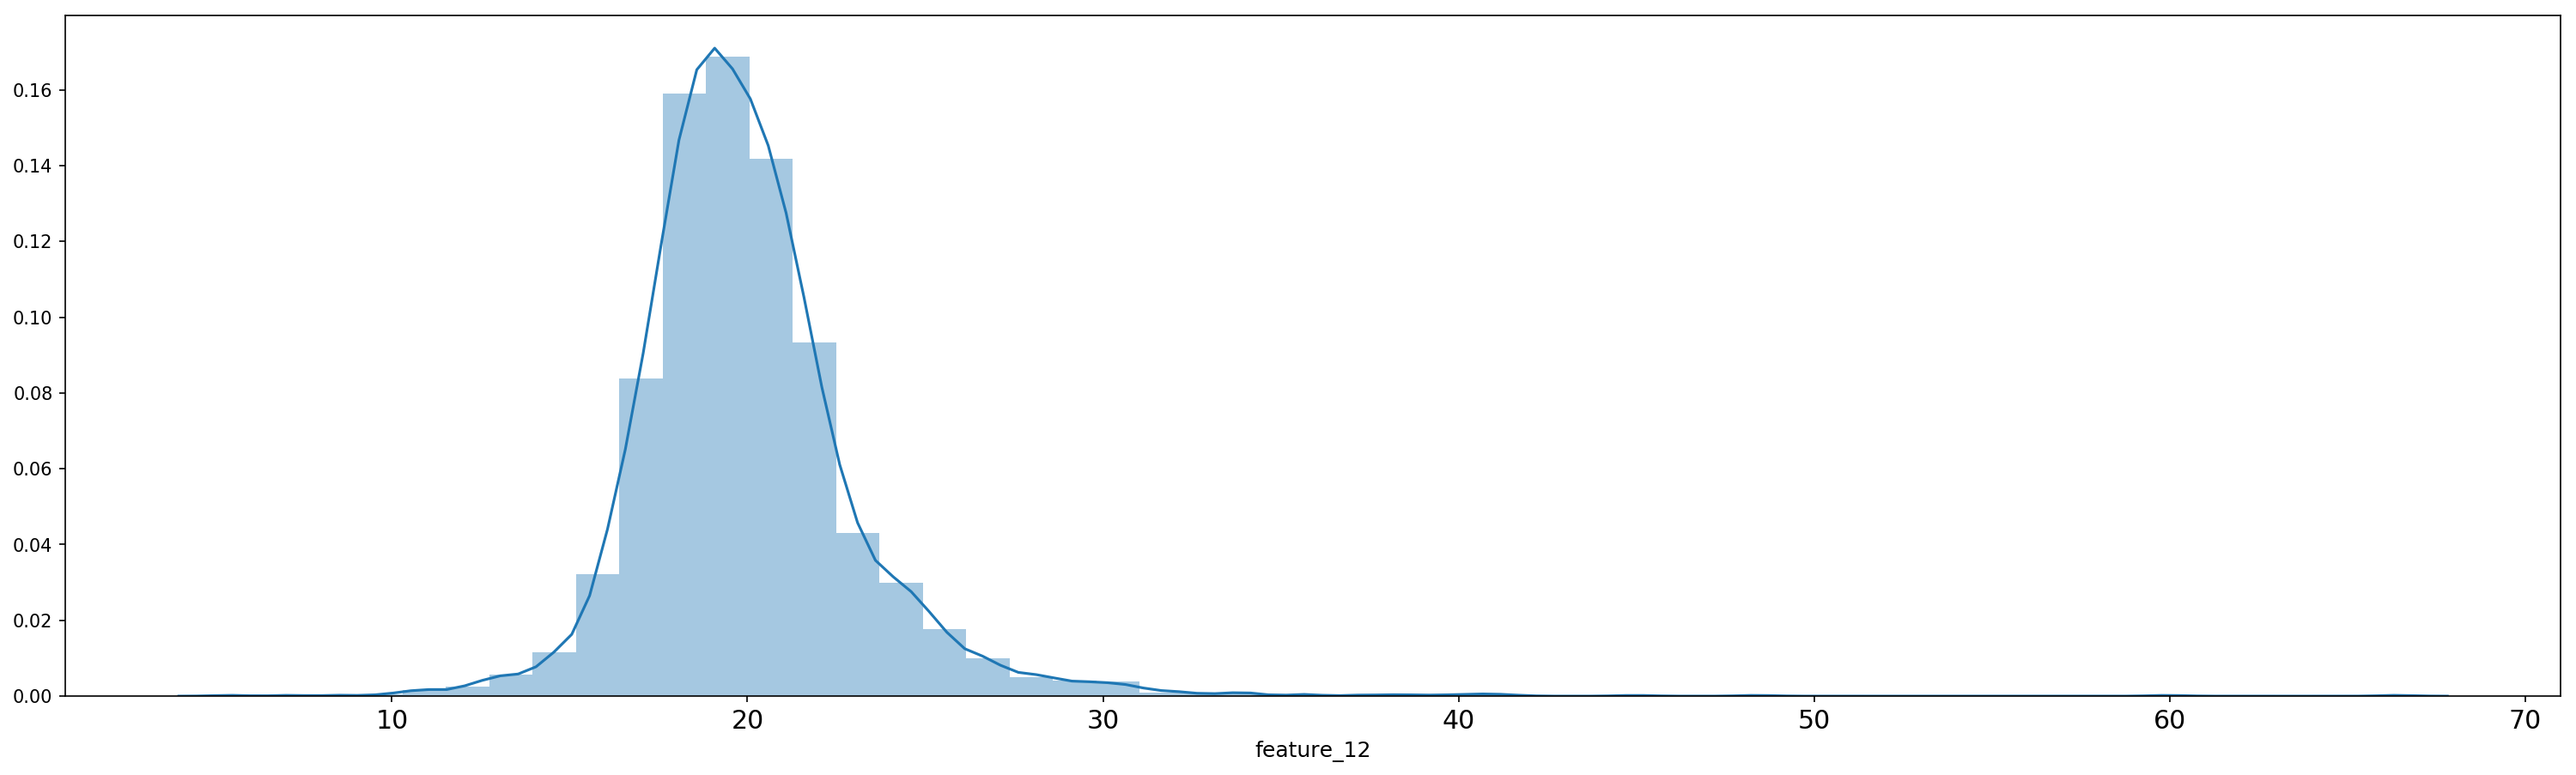

In [239]:
sns.distplot(df.feature_12)

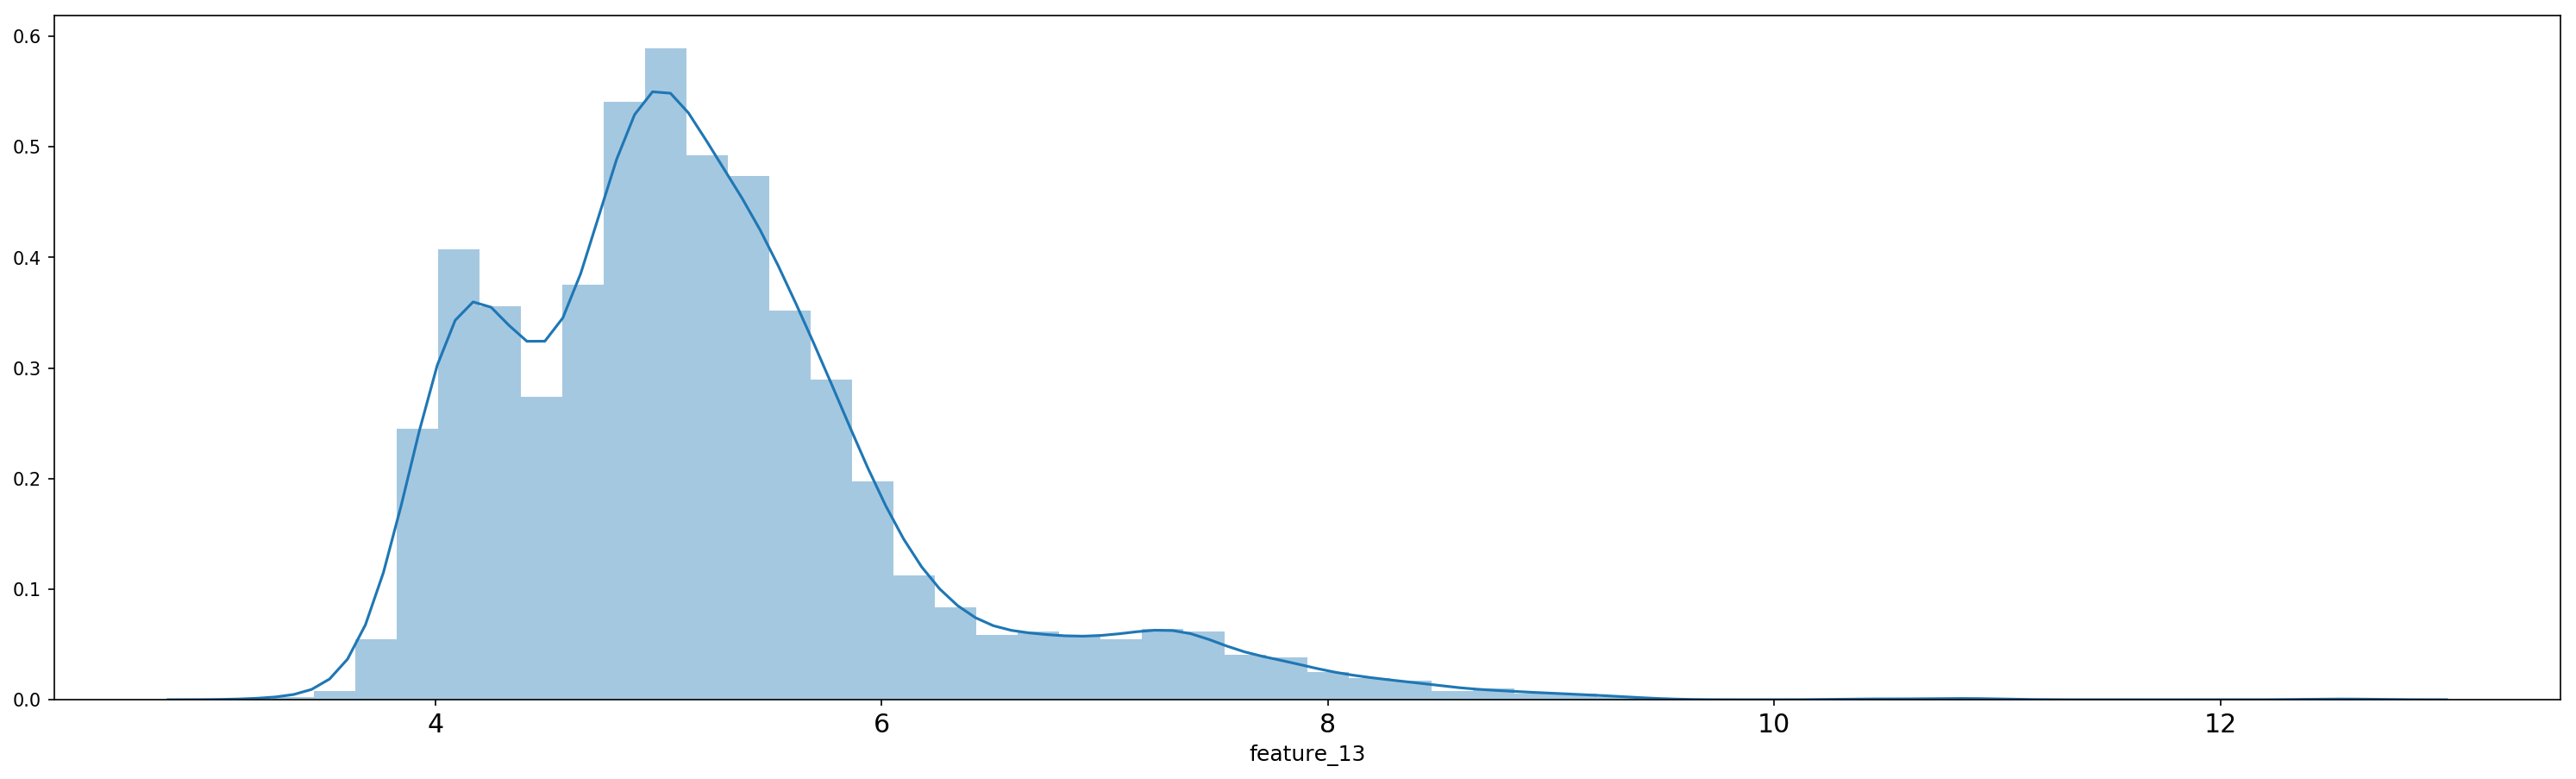

In [240]:
sns.distplot(df.feature_13)

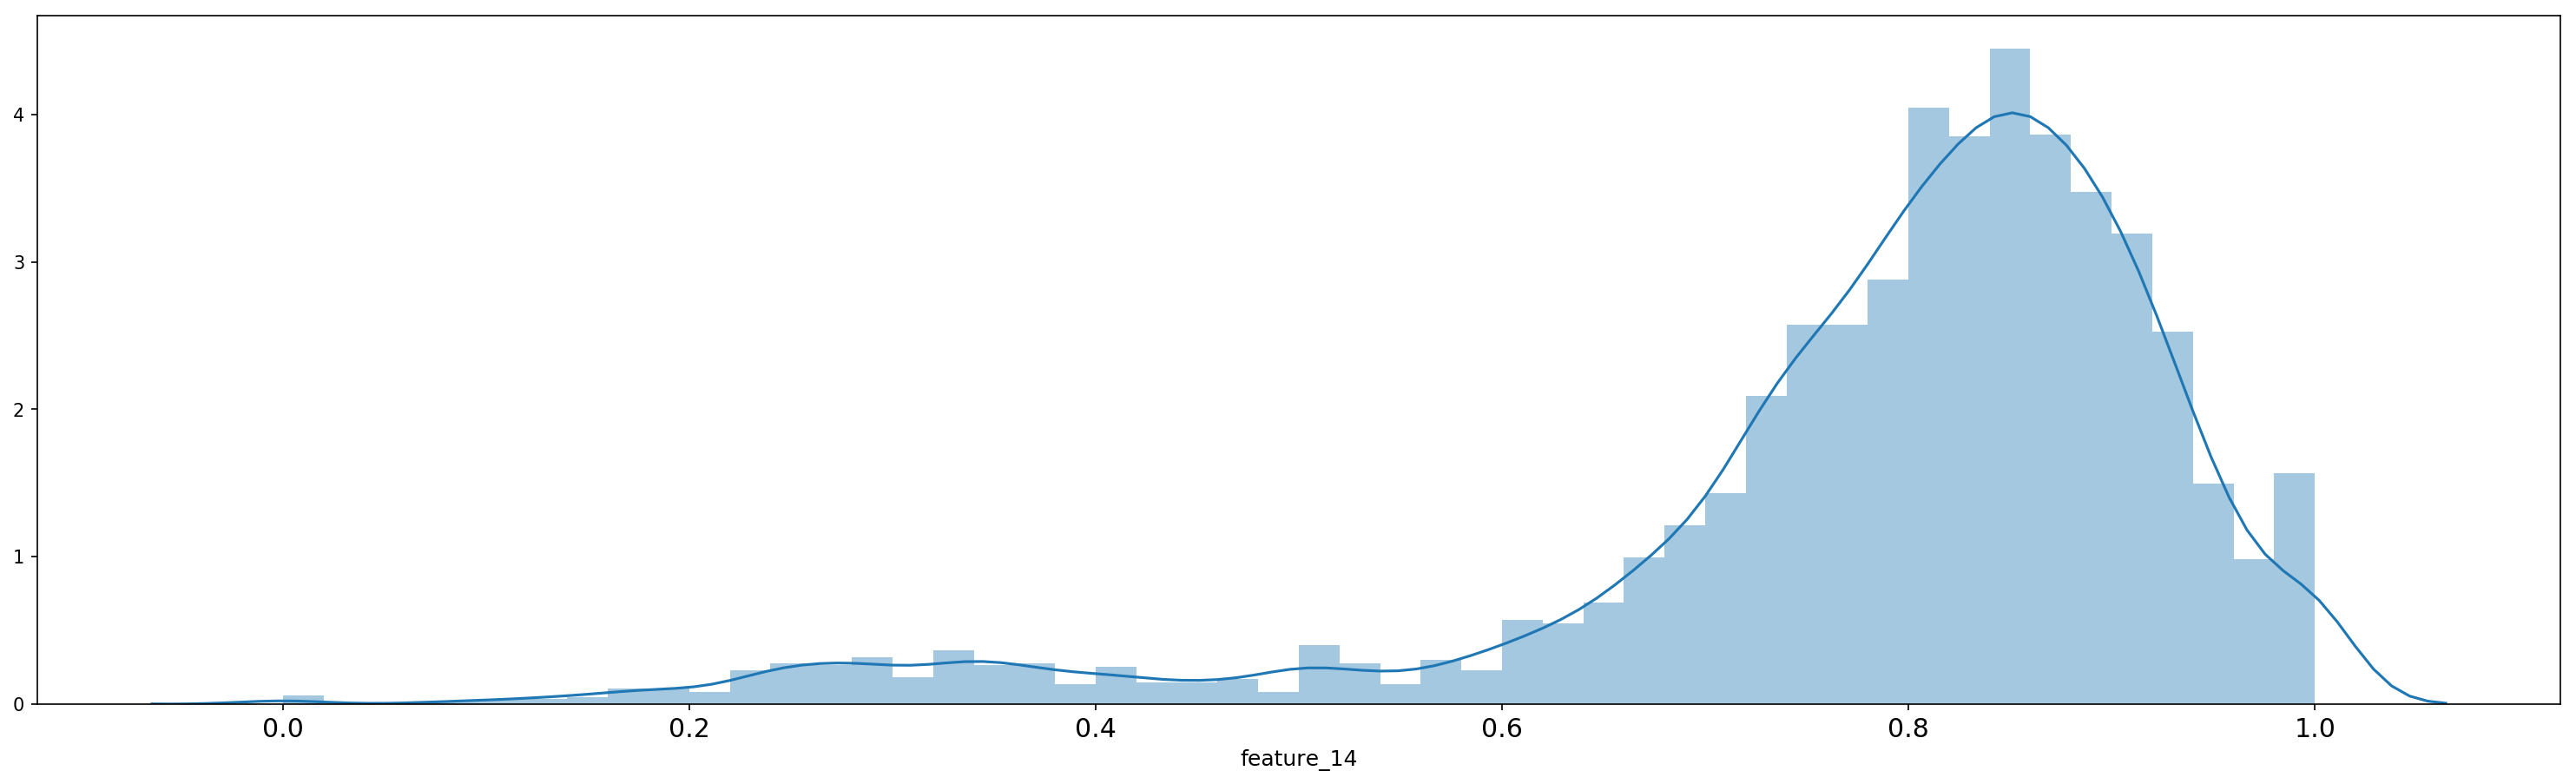

In [241]:
sns.distplot(df.feature_14)

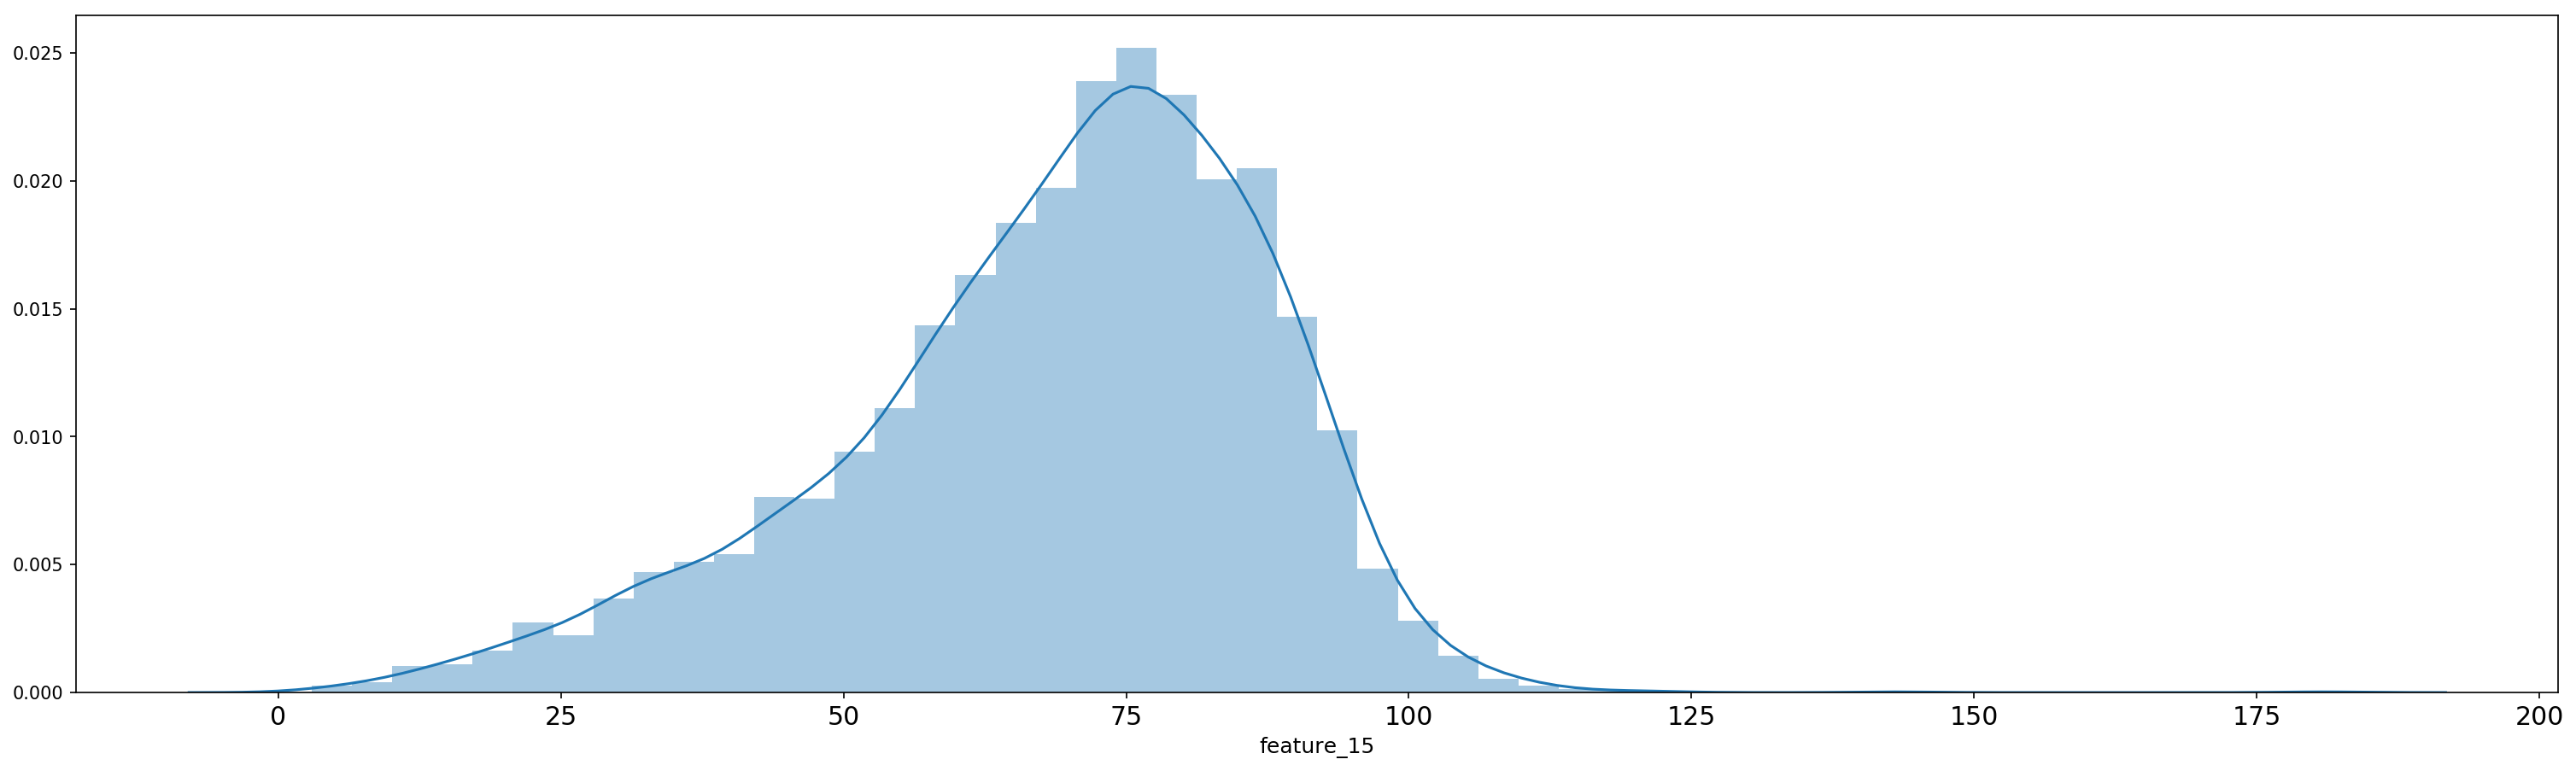

In [242]:
sns.distplot(df.feature_15)

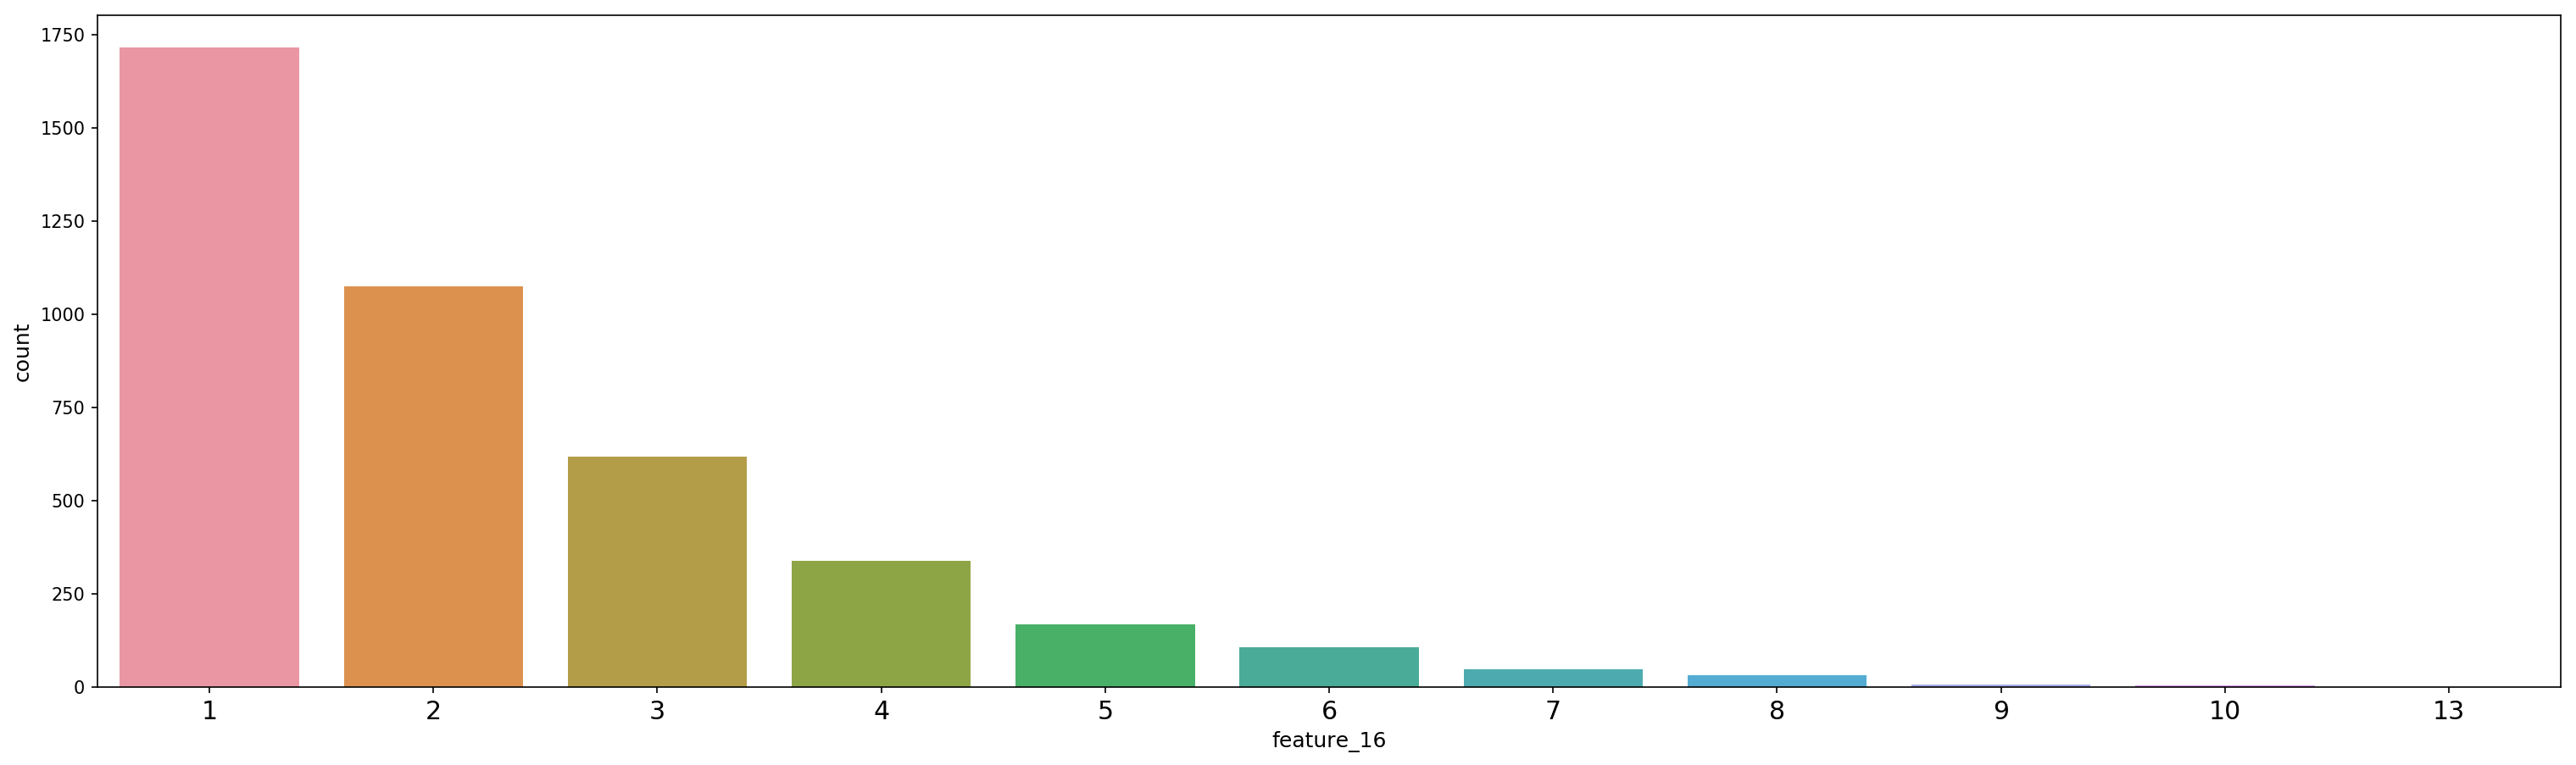

In [243]:
sns.countplot(df.feature_16)

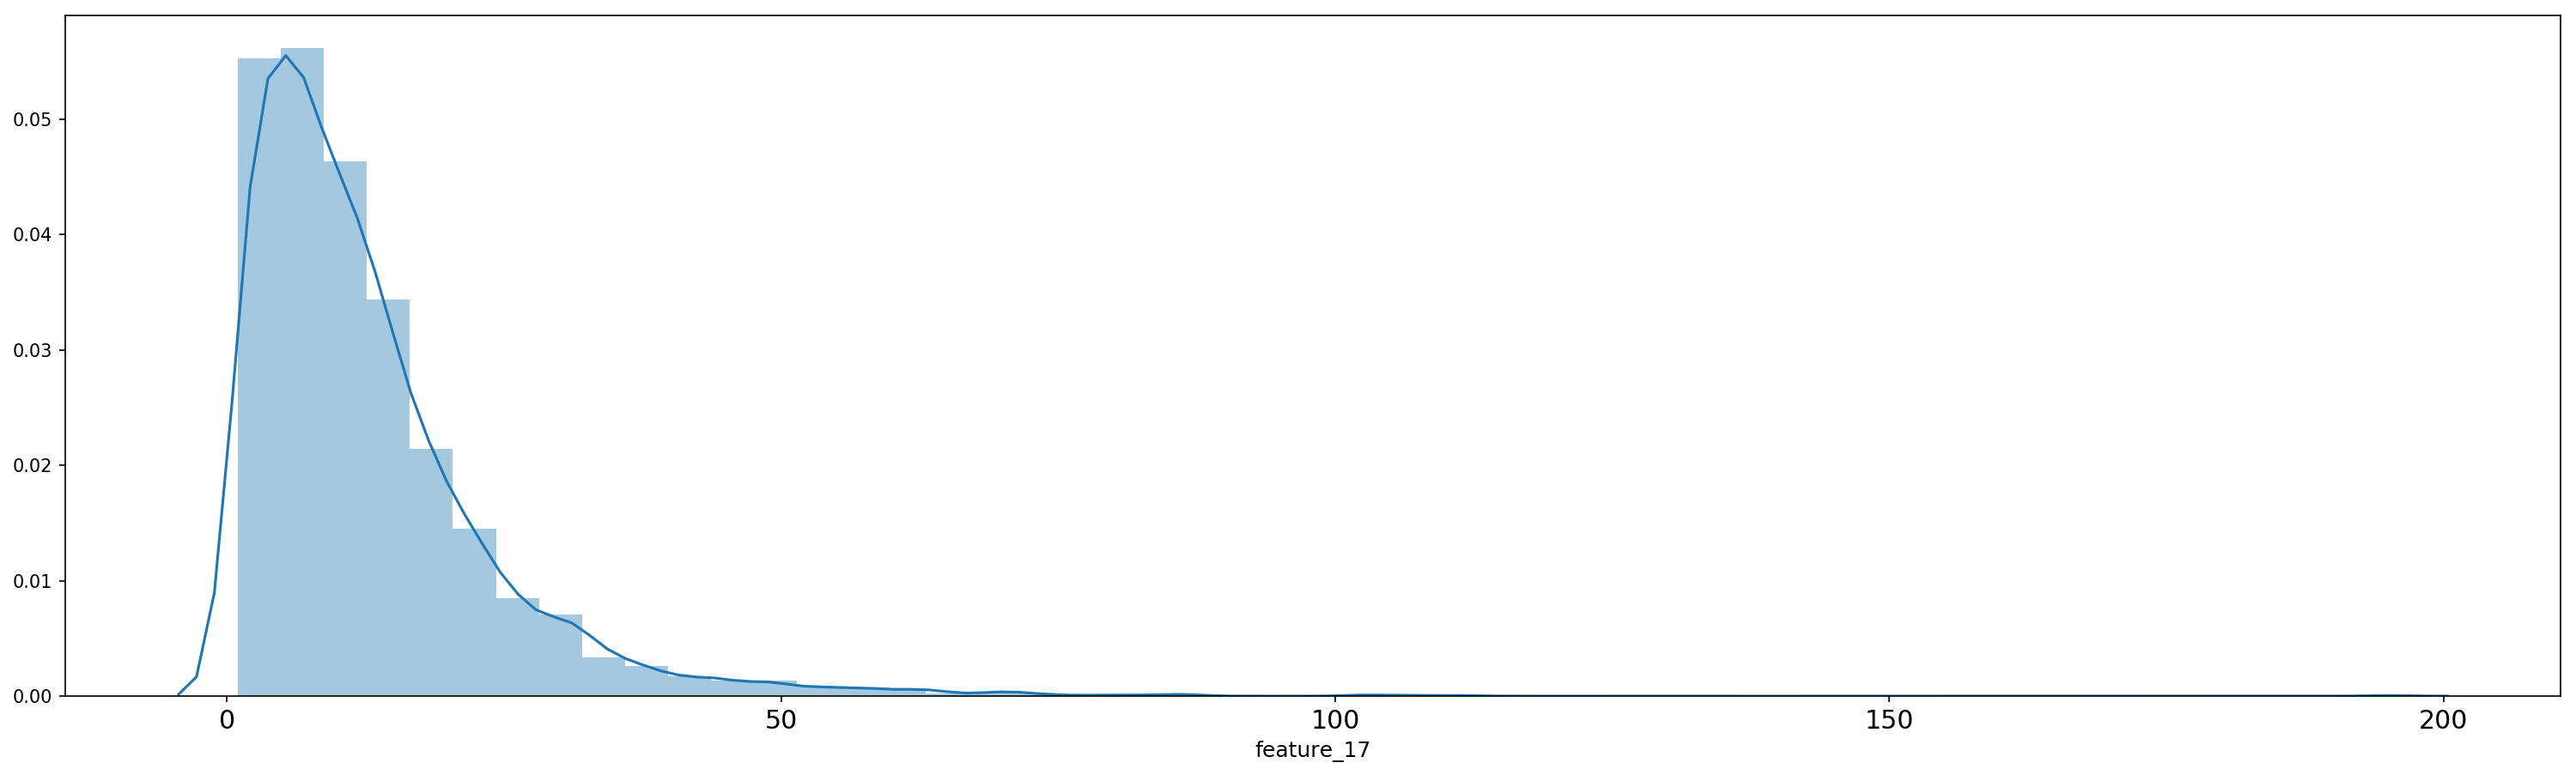

In [244]:
sns.distplot(df.feature_17)

We conclude that no other feature apart from feature_2_lt needs to be corrected.

#### Completing feature_2_lt

Once we have corrected feature_2_lt, we proceed to treat the missing values. There are different methods. For instance, a simple way would be to generate random numbers between the mean and the standard deviation. However, a more accurate way of guessing missing values consists in using other correlated features. Therefore, first we are going to find which features correlate with feature_2_lt. The best way to do it is using a correlation plot, which measures the correlation between every pair of values in a dataset and plots a result in color.

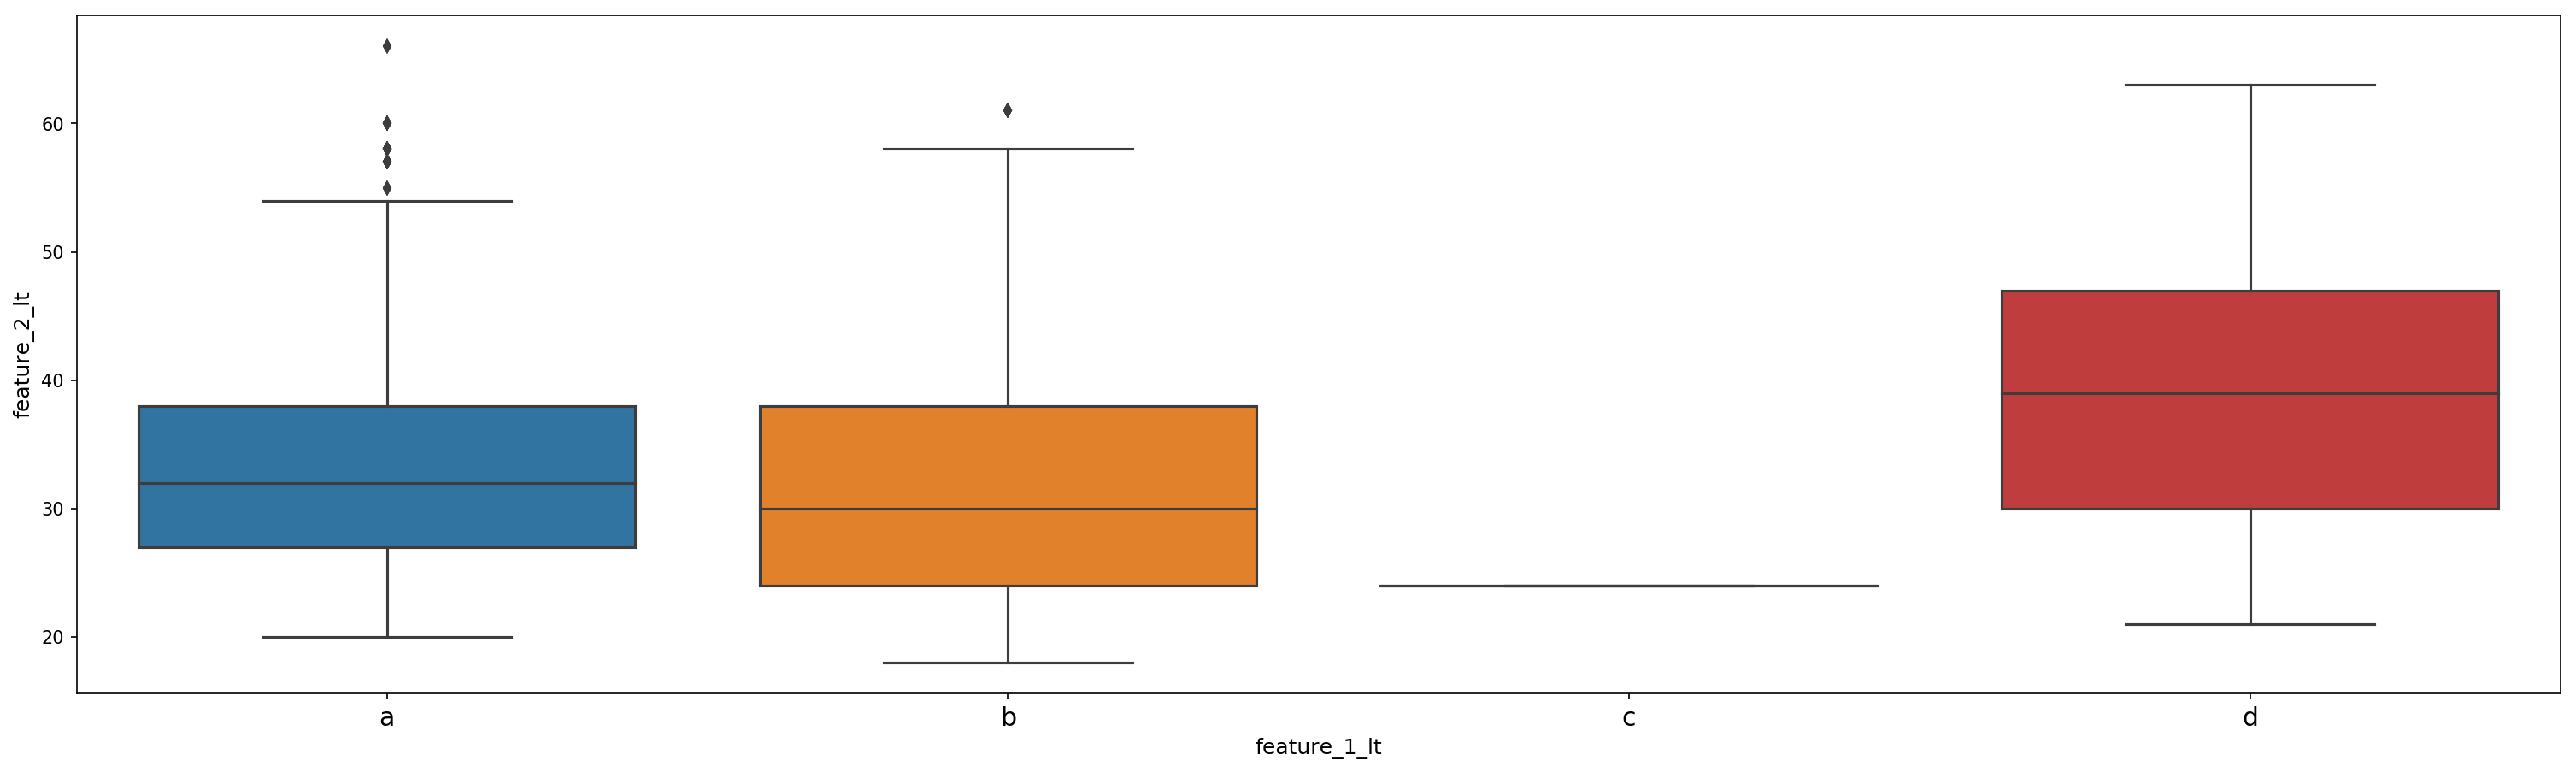

In [245]:
sns.boxplot(
    x='feature_1_lt',
    y='feature_2_lt',
    data=df.dropna(), order = ['a','b','c','d'])

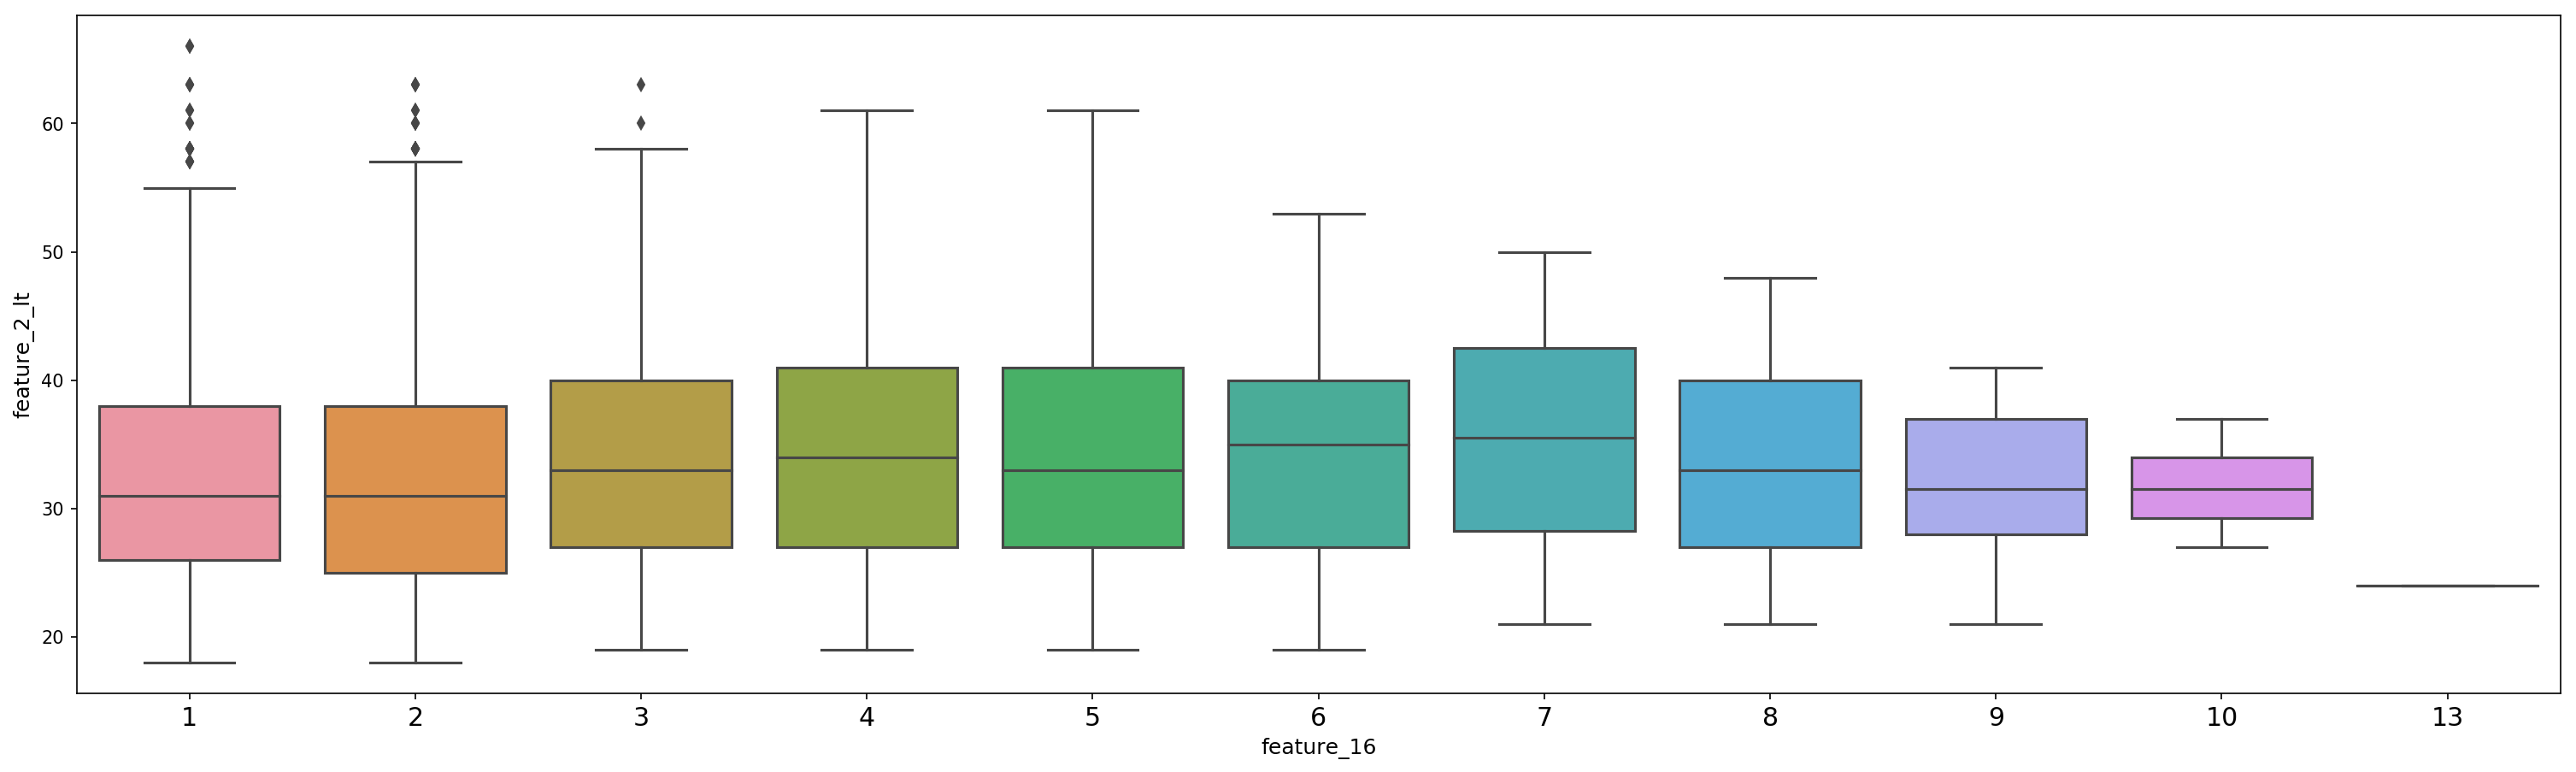

In [246]:
sns.boxplot(
    x='feature_16',
    y='feature_2_lt',
    data=df.dropna())

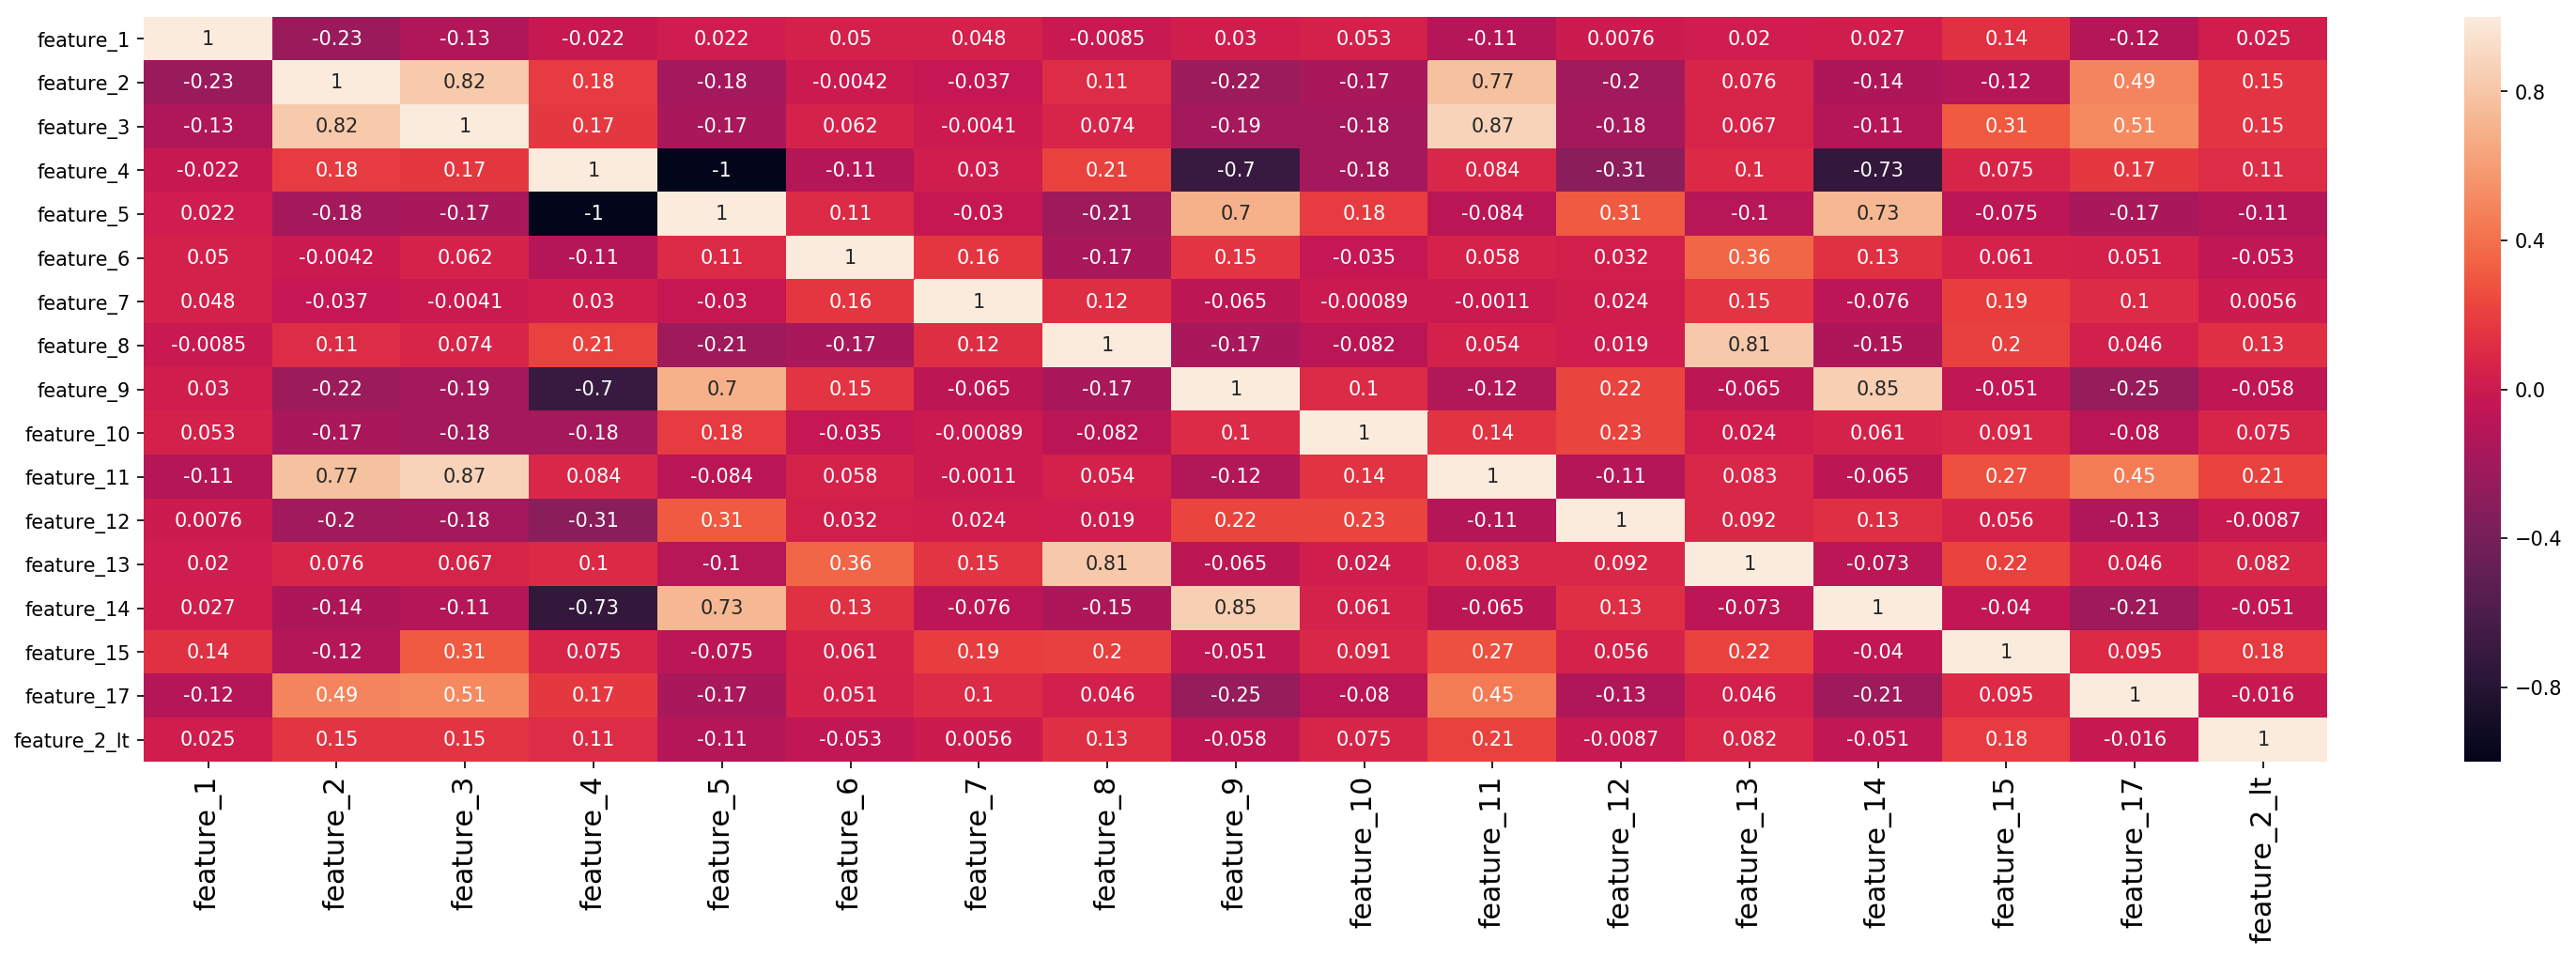

In [247]:
df_corr = df.dropna().drop(columns=['courier','week','feature_16','feature_1_lt']).corr()
sns.heatmap(df_corr, annot=True)

##### Observations on completing feature_2_lt:
* feature_1_lt seems to have a slight impact on feature_2_lt.
* feature_2_lt does not have any strong correlation with any other feature.

Given these observations, we proceed to impute the missing feature_2_lt values.

In [248]:
grouped_median_df = df.groupby(['feature_1_lt']).median().reset_index()[['feature_1_lt','feature_2_lt']]
grouped_median_df.head()

feature_1_lt  feature_2_lt
0            a          32.0
1            b          30.0
2            c          24.0
3            d          39.0

In [249]:
def fill_feature_2_lt(row):
    condition = (grouped_median_df['feature_1_lt'] == row['feature_1_lt'])
    return grouped_median_df[condition]['feature_2_lt'].values[0]

df['feature_2_lt'] = df.apply(lambda row: fill_feature_2_lt(row) 
                              if np.isnan(row['feature_2_lt']) else row['feature_2_lt'], axis = 1)

print('Number of missing values in feature_2_lt:', df.feature_2_lt.isnull().sum())
df.feature_2_lt.describe()

Number of missing values in feature_2_lt: 0


count    4117.000000
mean       32.972310
std         8.335804
min        18.000000
25%        27.000000
50%        32.000000
75%        38.000000
max        66.000000
Name: feature_2_lt, dtype: float64

The missing values have been replaced.

### Data visualization

Once the data is clean, we proceed to create some interesting charts that will spot correlations and hidden insights out of the data. Since we are asked to label the data after the visualization process, we are not going to provide plots about the correlation between the features and the target variable. Instead, we are going to focus on identifying patterns among the features.

##### Correlation matrix

We begin by showing a correlation matrix as we did before, but now using our complete clean data. Notice that trying to represent a linear correlation between categorical variables and numerical variables does not make sense. Thus we have dropped columns 'feature_16' and 'feature_1_lt'. The correlation matrix gives us values between [-1,1], where 1 is total positive linear correlation, 0 is no linear correlation, and −1 is total negative linear correlation.

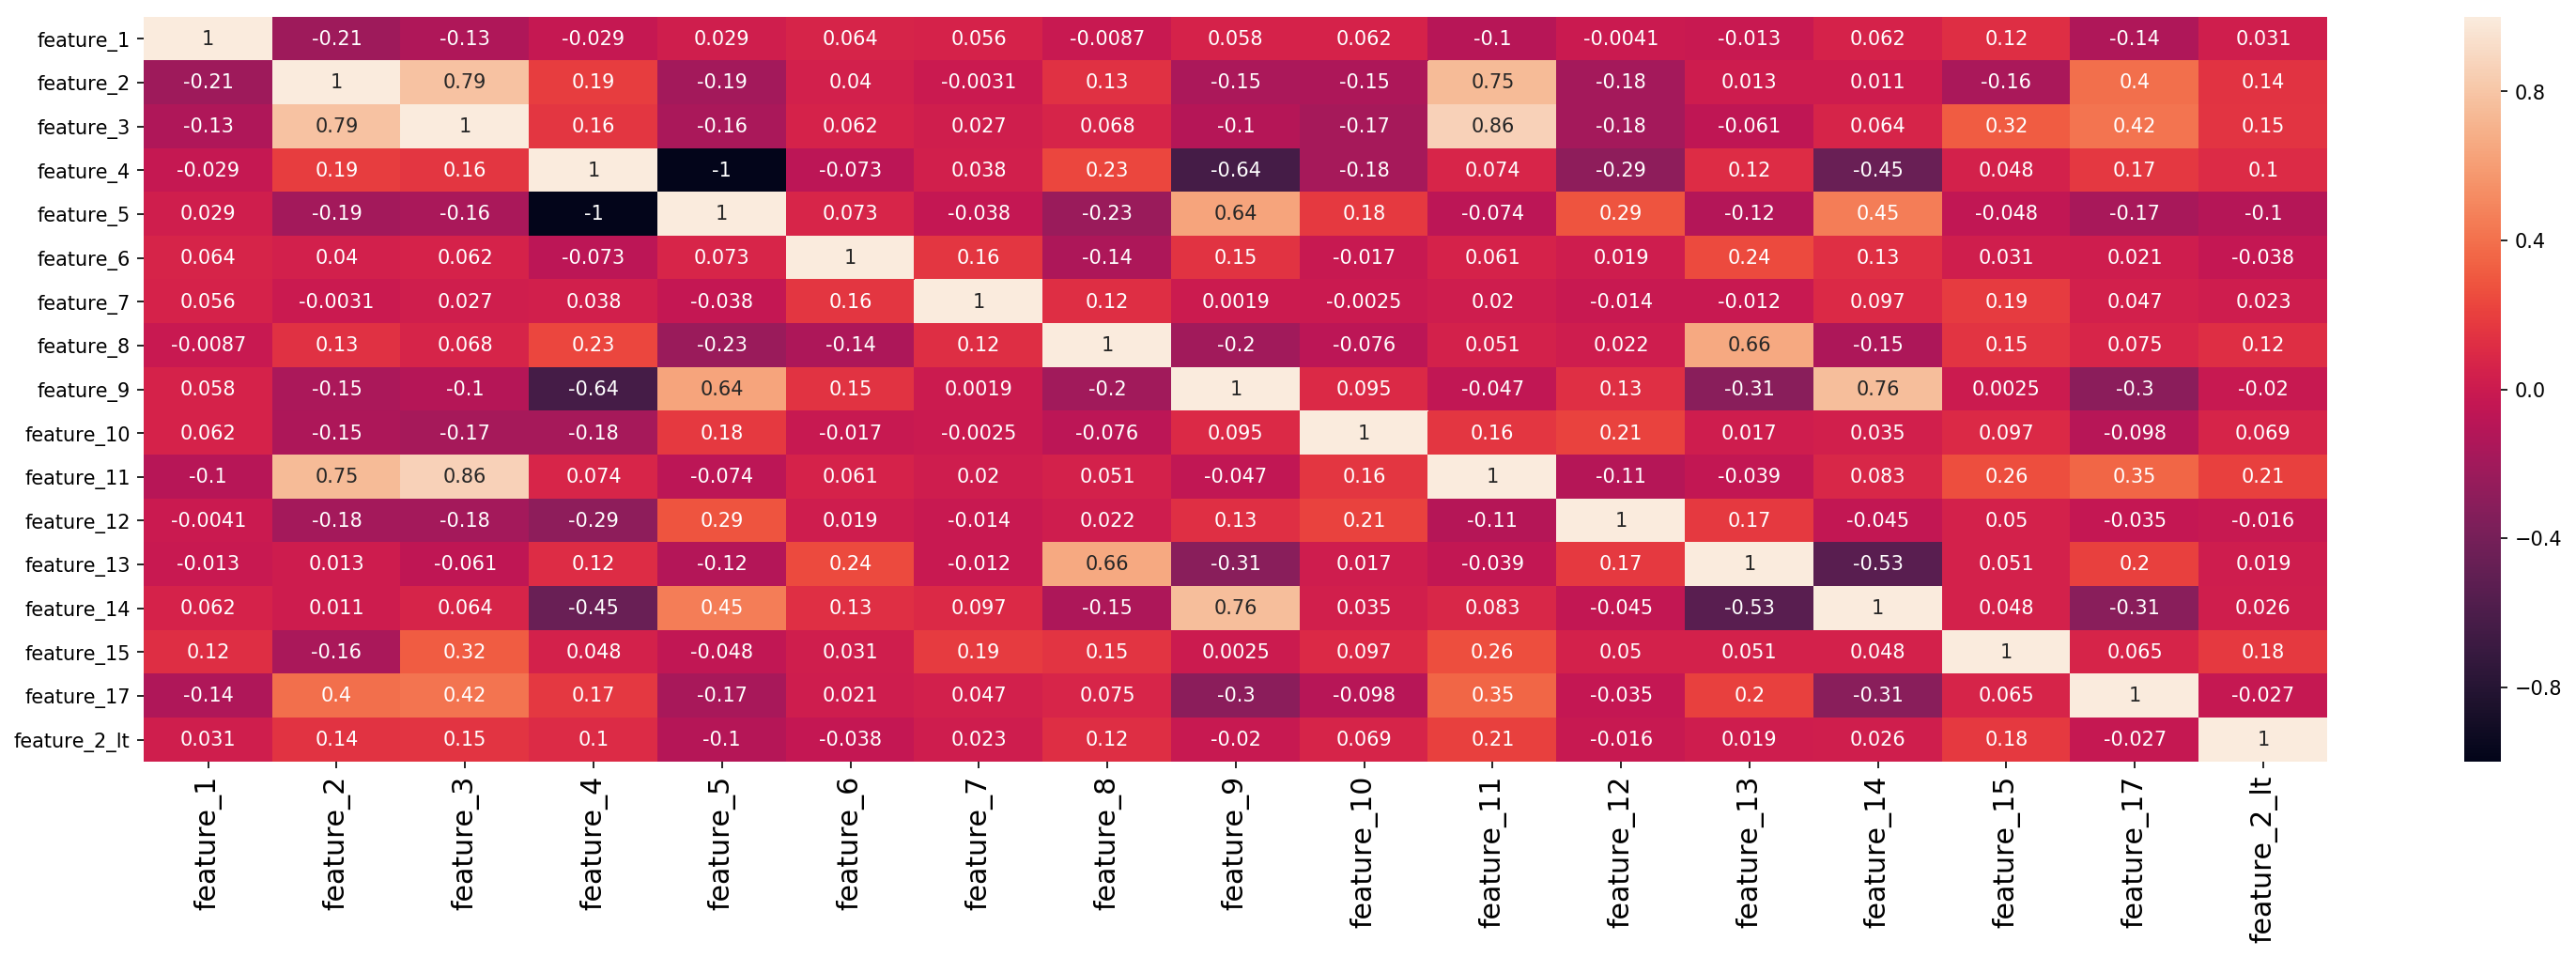

In [250]:
df_corr = df.drop(columns=['courier','week','feature_16','feature_1_lt']).corr()
sns.heatmap(df_corr, annot=True)

##### Observations on the correlation matrix:
* Positive linear correlation:
    * feature_3 and feature_11 (0.86)
    * feature_2 and feature_3 (0.79)
    * feature_9 and feature_14 (0.76)
    * feature_2 and feature_11 (0.75)
    * feature_8 and feature_13 (0.66)
    * feature_5 and feature_9 (0.64)

* Negative linear correlation:
    * feature_4 and feature_5 (-1.00)
    * feature_4 and feature_9 (-0.64)
    * feature_13 and feature_14 (-0.53)
    
* There are features highly or perfectly correlated. Therefore, there is a high chance that the performance of the model will be impacted by the so-called **Multicollinearity problem**. Multicollinearity happens when one predictor variable in a multiple regression model can be linearly predicted from the others with a high degree of accuracy. This can lead to misleading results. Since we will use a Logistic Regression model, which is not immune to that problem, we should fix it before training the model.
    
Knowing the correlation between pairs gives us an insight of which sets of features we should study in detail by plotting bivariate or multivariate charts.

#### Univariate analysis

During the data cleaning section we saw the univariate plots of all features in order to identify outliers. As we have only modified 'feature_2_lt' since then, we are not going to repeat all plots.

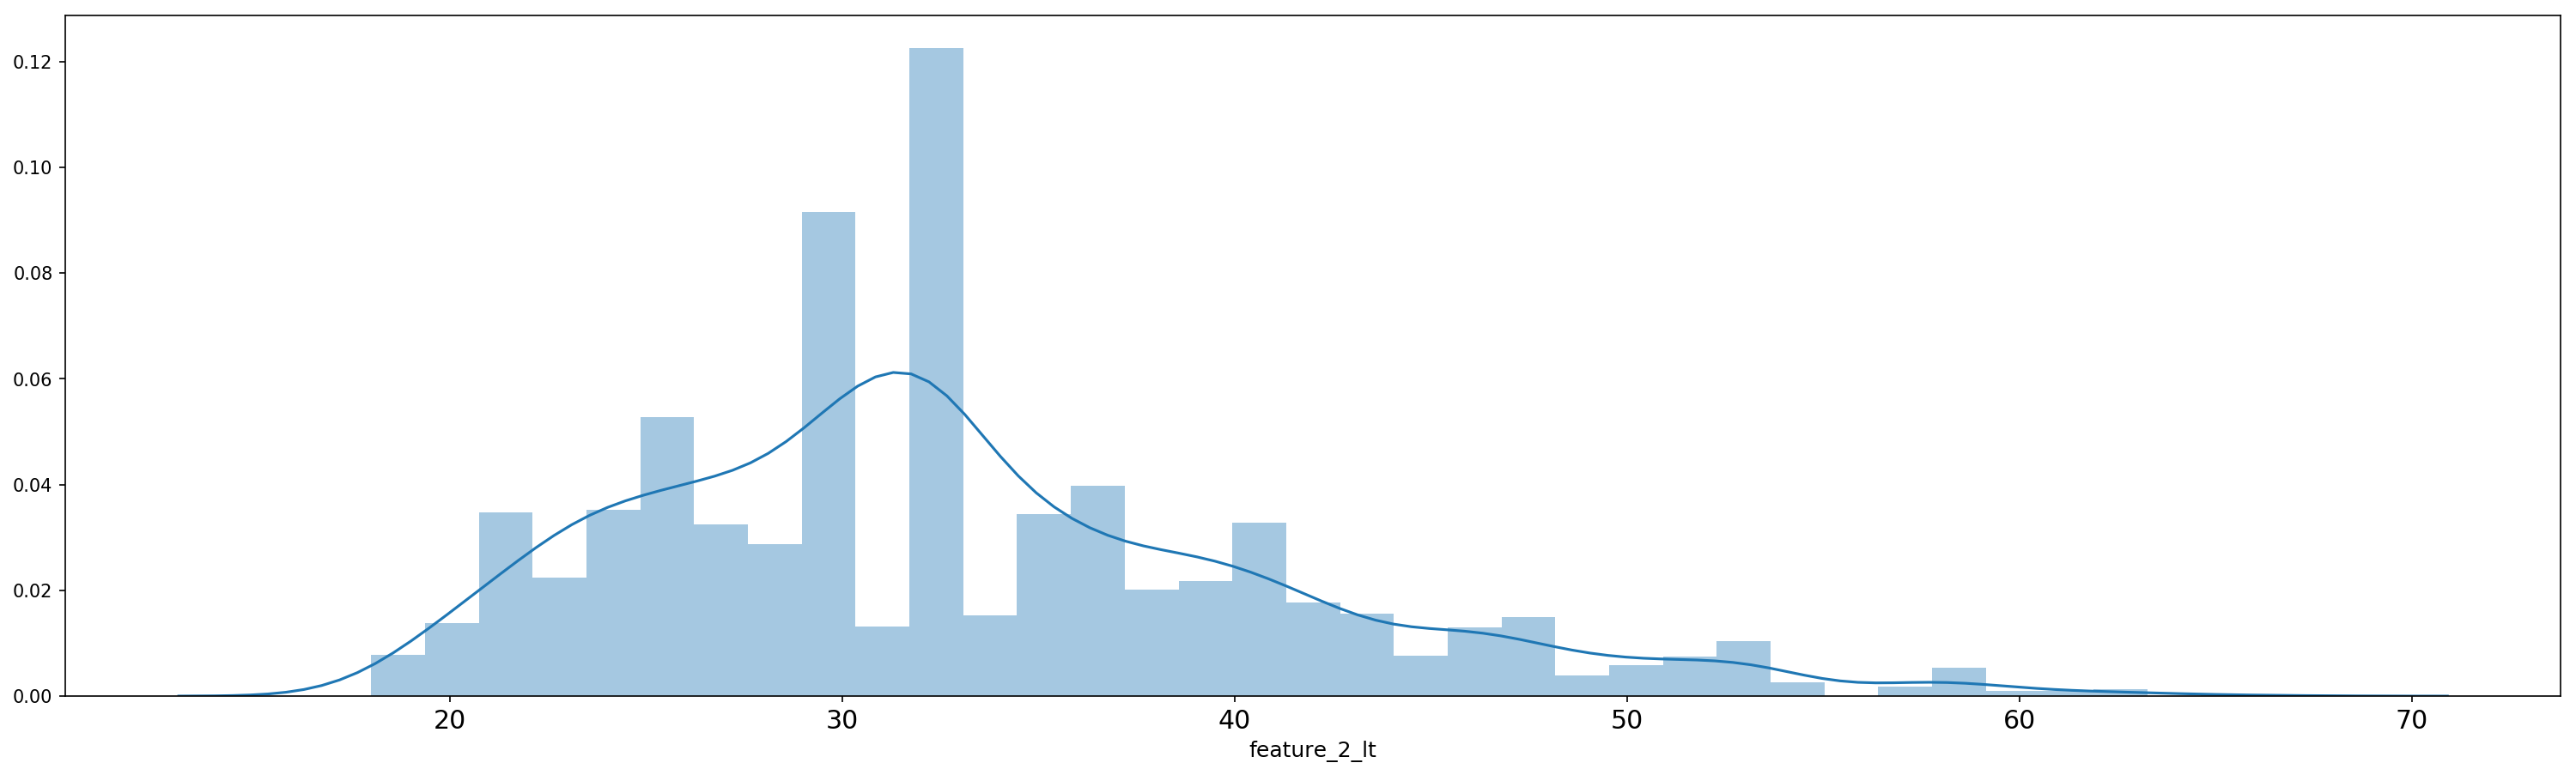

In [251]:
sns.distplot(df.feature_2_lt)

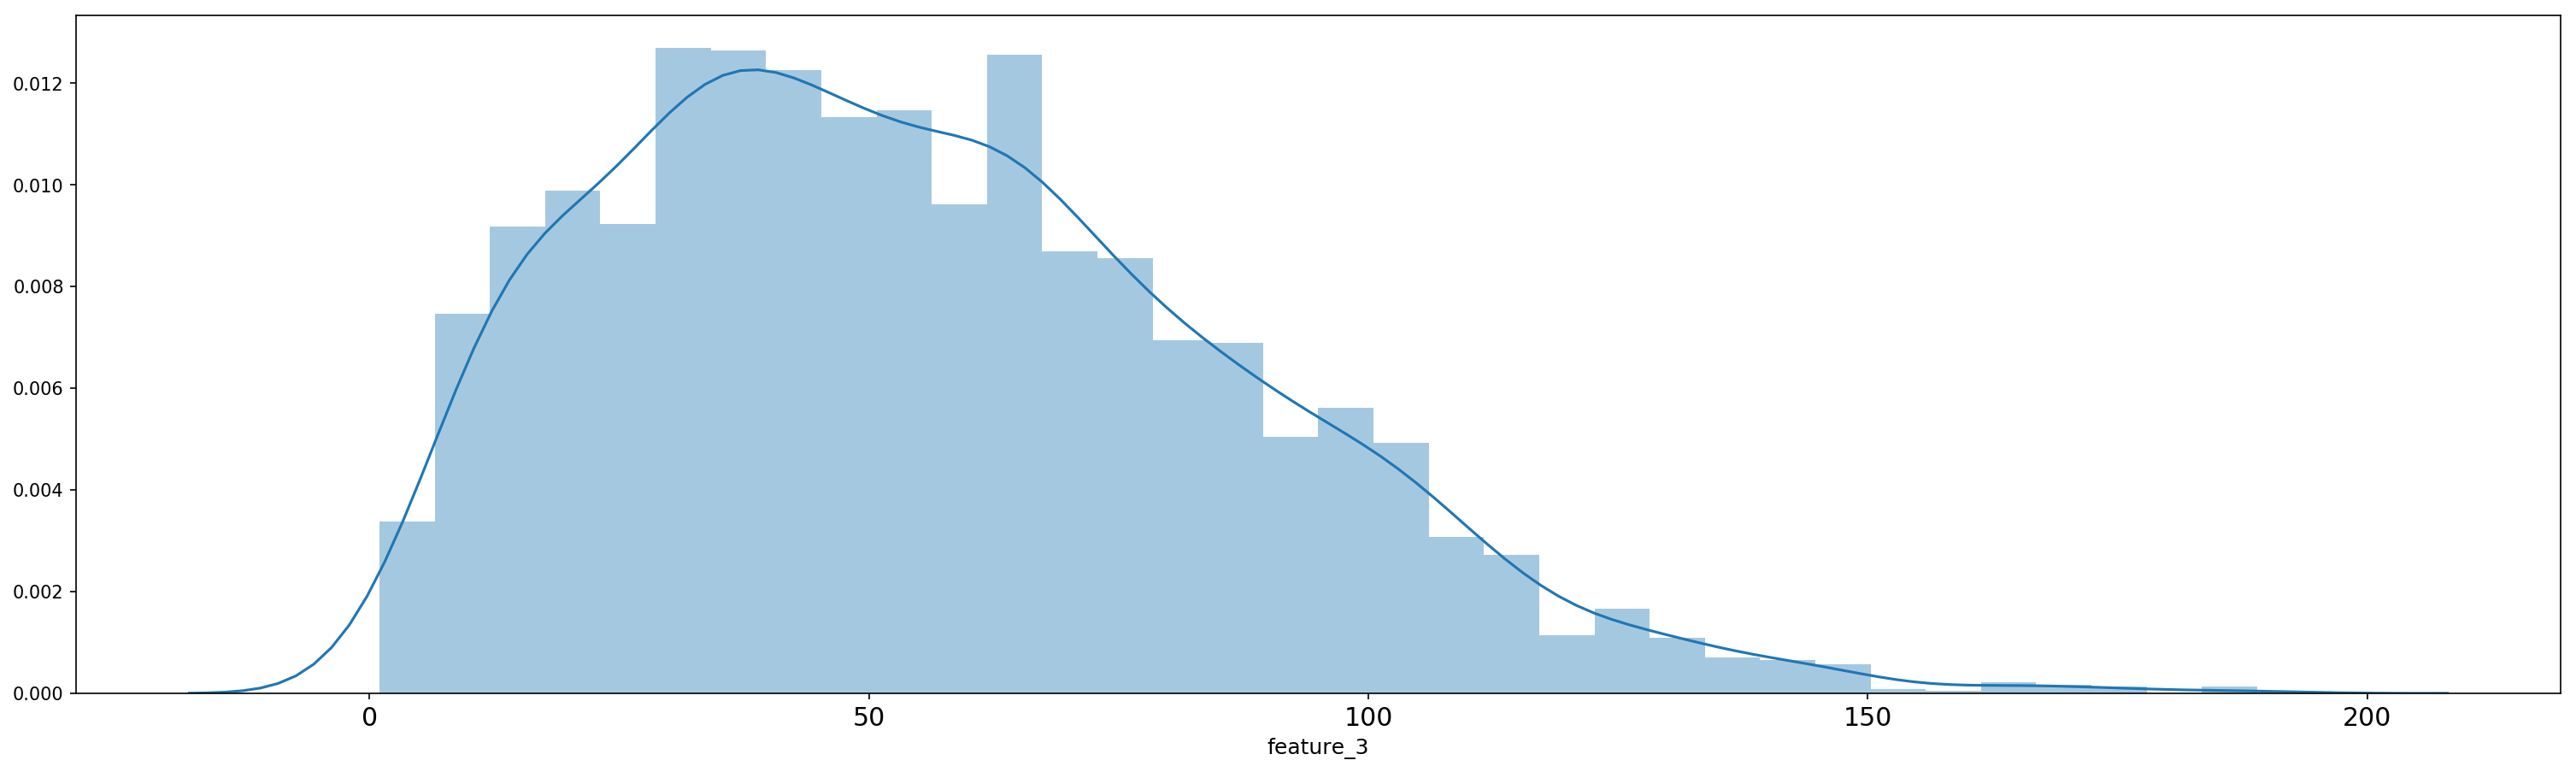

In [252]:
sns.distplot(df.feature_3)

##### Observations on univariate analysis:

* feature_2_lt's histogram shows an strange behaviour due to the filling of missing values. If we had done the method of generating random numbers between the mean and the standard deviation the histogram would look better. Nevertheless, our method works better in training the algorithm. Thus, we are not going to modify it. 
* Feature_1_lt takes 4 possible values (categorical). The most common value is 'a' with 2570 counts.
* Feature_16 takes 11 possible values (categorical). The most common value is '1' with 1715 counts. It shows a decreasing behaviour: counts decrease as feature_16 increases. 
* All features except feature_1 are positive definite.
* feature_1, feaature_2, feature_3, feature_10, feature_11 and feature_12 look like a normal distribution.
* feature_8 looks like a sum of two different normal distributions.
* feature_13 looks like a sum of a log-normal distribution and a normal distribution.
* feature_4, feature_5, feature_6 and feature_7 look like an exponential distribution.
* feature_9, feature_14, feature_15 and feature_17 look like a log-normal distribution.
* We are told that distribution of feature_3 is a hint of how the data is generated. It corresponds approximately to a normal distribution $\mathcal{N}(\mu=50, \sigma=35)$. This is probably because of the **central limit theorem (CLT)**. This theorem states that averages of samples of observations of random variables independently drawn from independent distributions converge in distribution to the normal, that is, they become normally distributed when the number of observations is sufficiently large.
* All distributions are **skewed** except for feature_1, feature_10 and feature_12. Dealing with skew data can cause a lot of issues and adversely affect the model. Therefore we may consider correcting this problem in the feature engineering step. **Standardising all continuous variables** could be a solution.
* The continuous variables in our dataset are at varying scales. We can observe features that range from [0,1], whereas other variables have wider ranges. This poses a problem for many popular machine learning algorithms. **Normalizing all continuous variables** could improve the performance of the machine learning model. 

#### Bivariate and multivariate analysis

We begin by showing the correlation between the categorical variable feature_1_lt and all numerical features. We use violinplots in order to compare the different distributions.

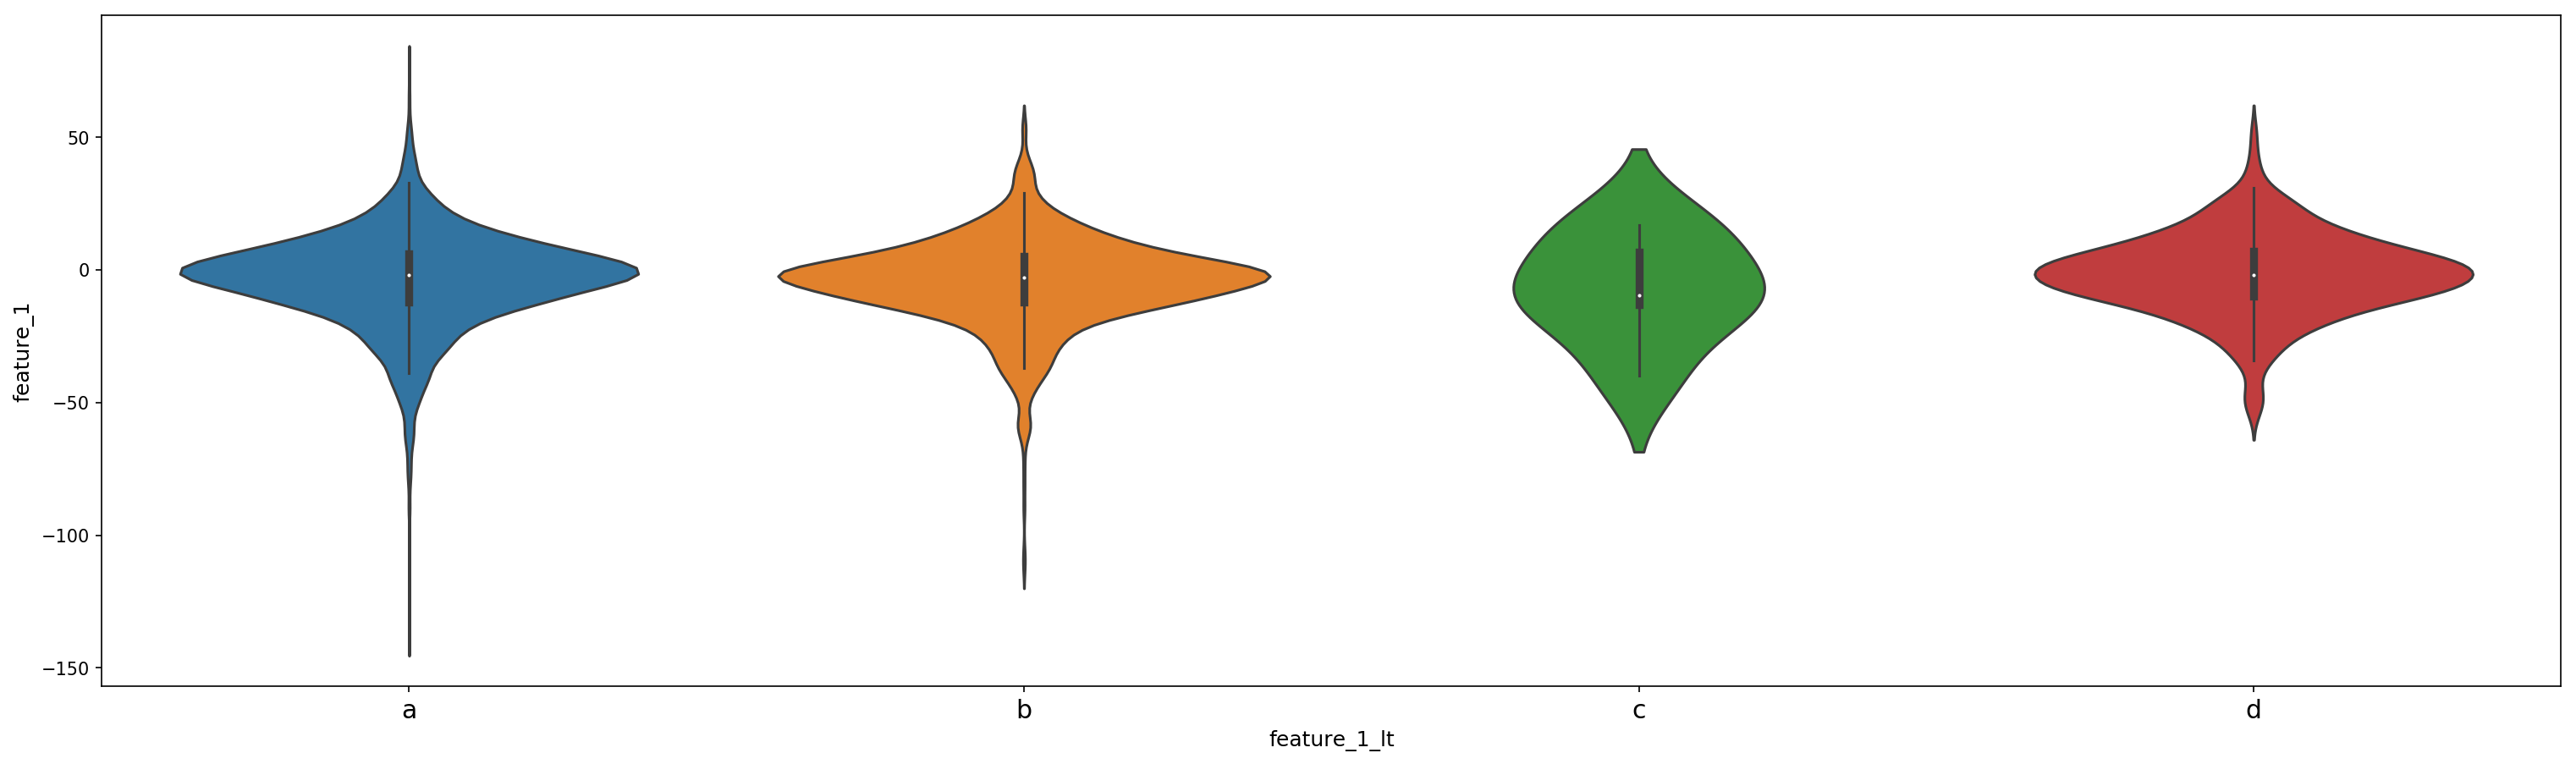

In [253]:
sns.violinplot(x = 'feature_1_lt', y = 'feature_1', data = df, order=['a','b','c','d'])

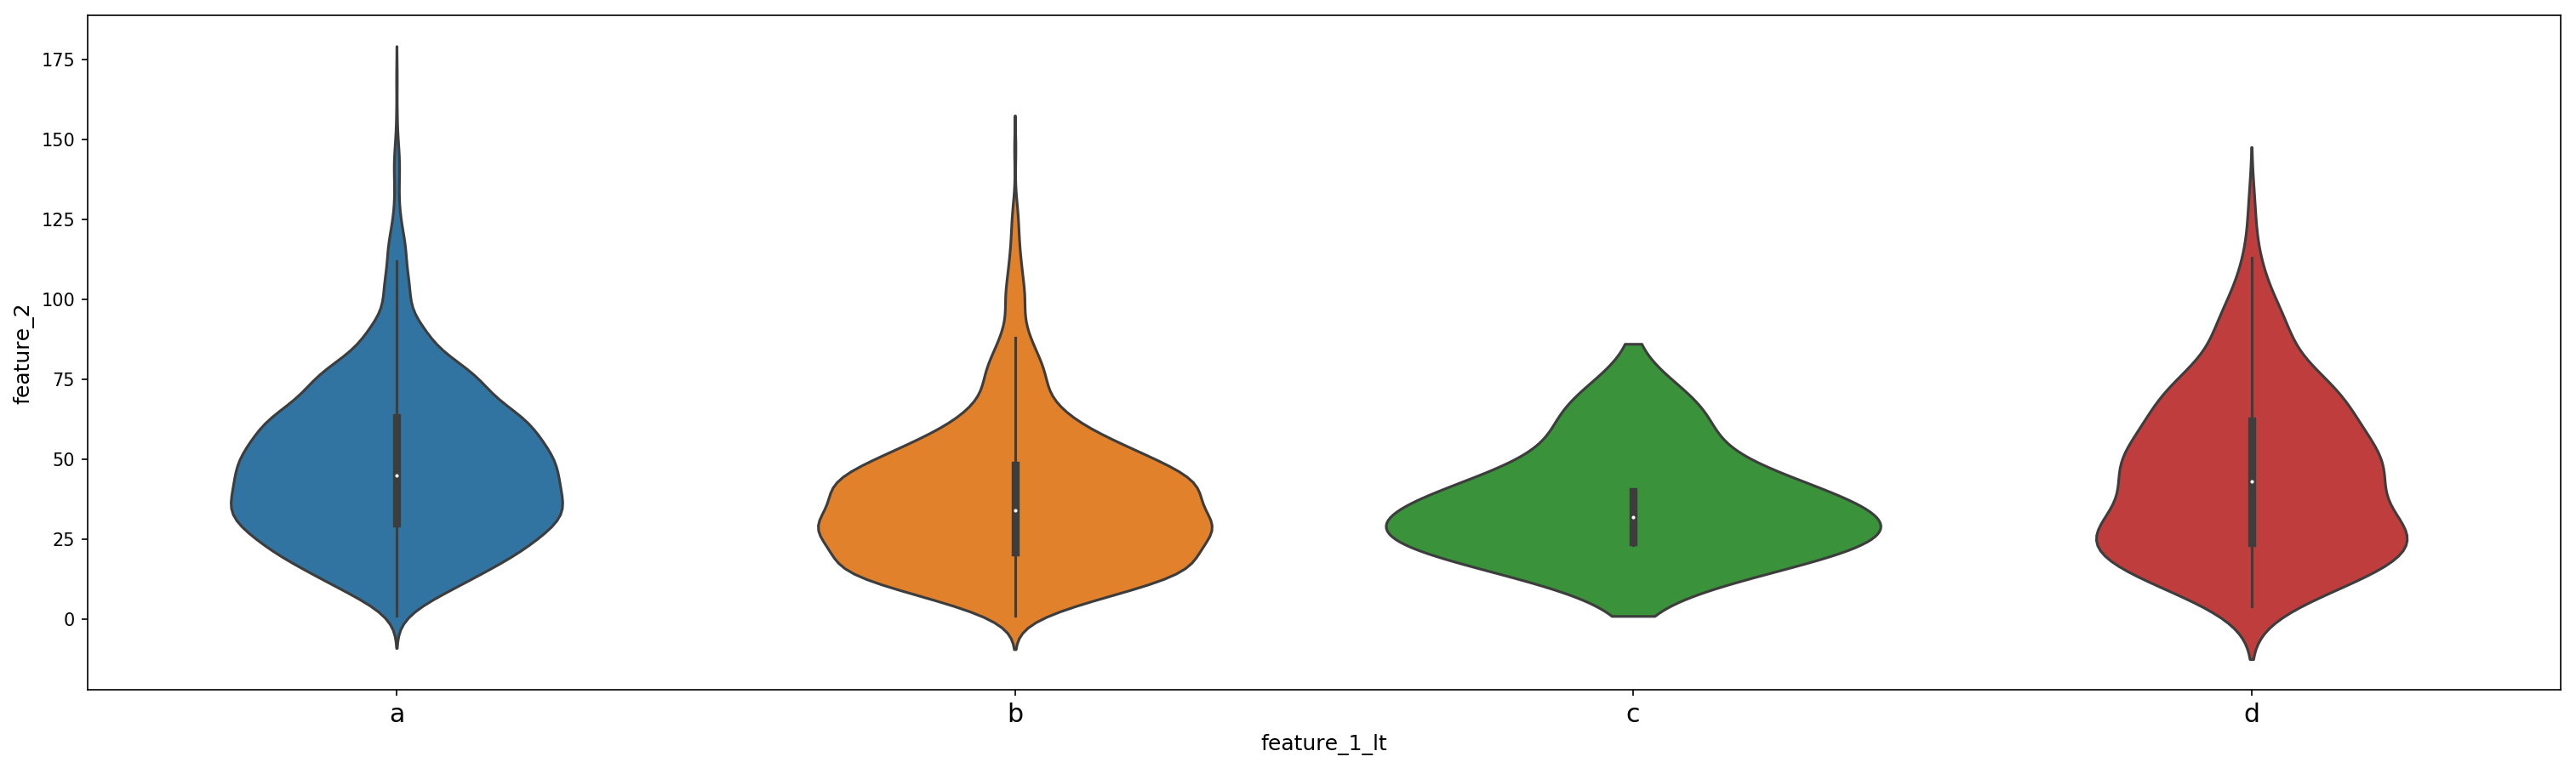

In [254]:
sns.violinplot(x = 'feature_1_lt', y = 'feature_2', data = df, order=['a','b','c','d'])

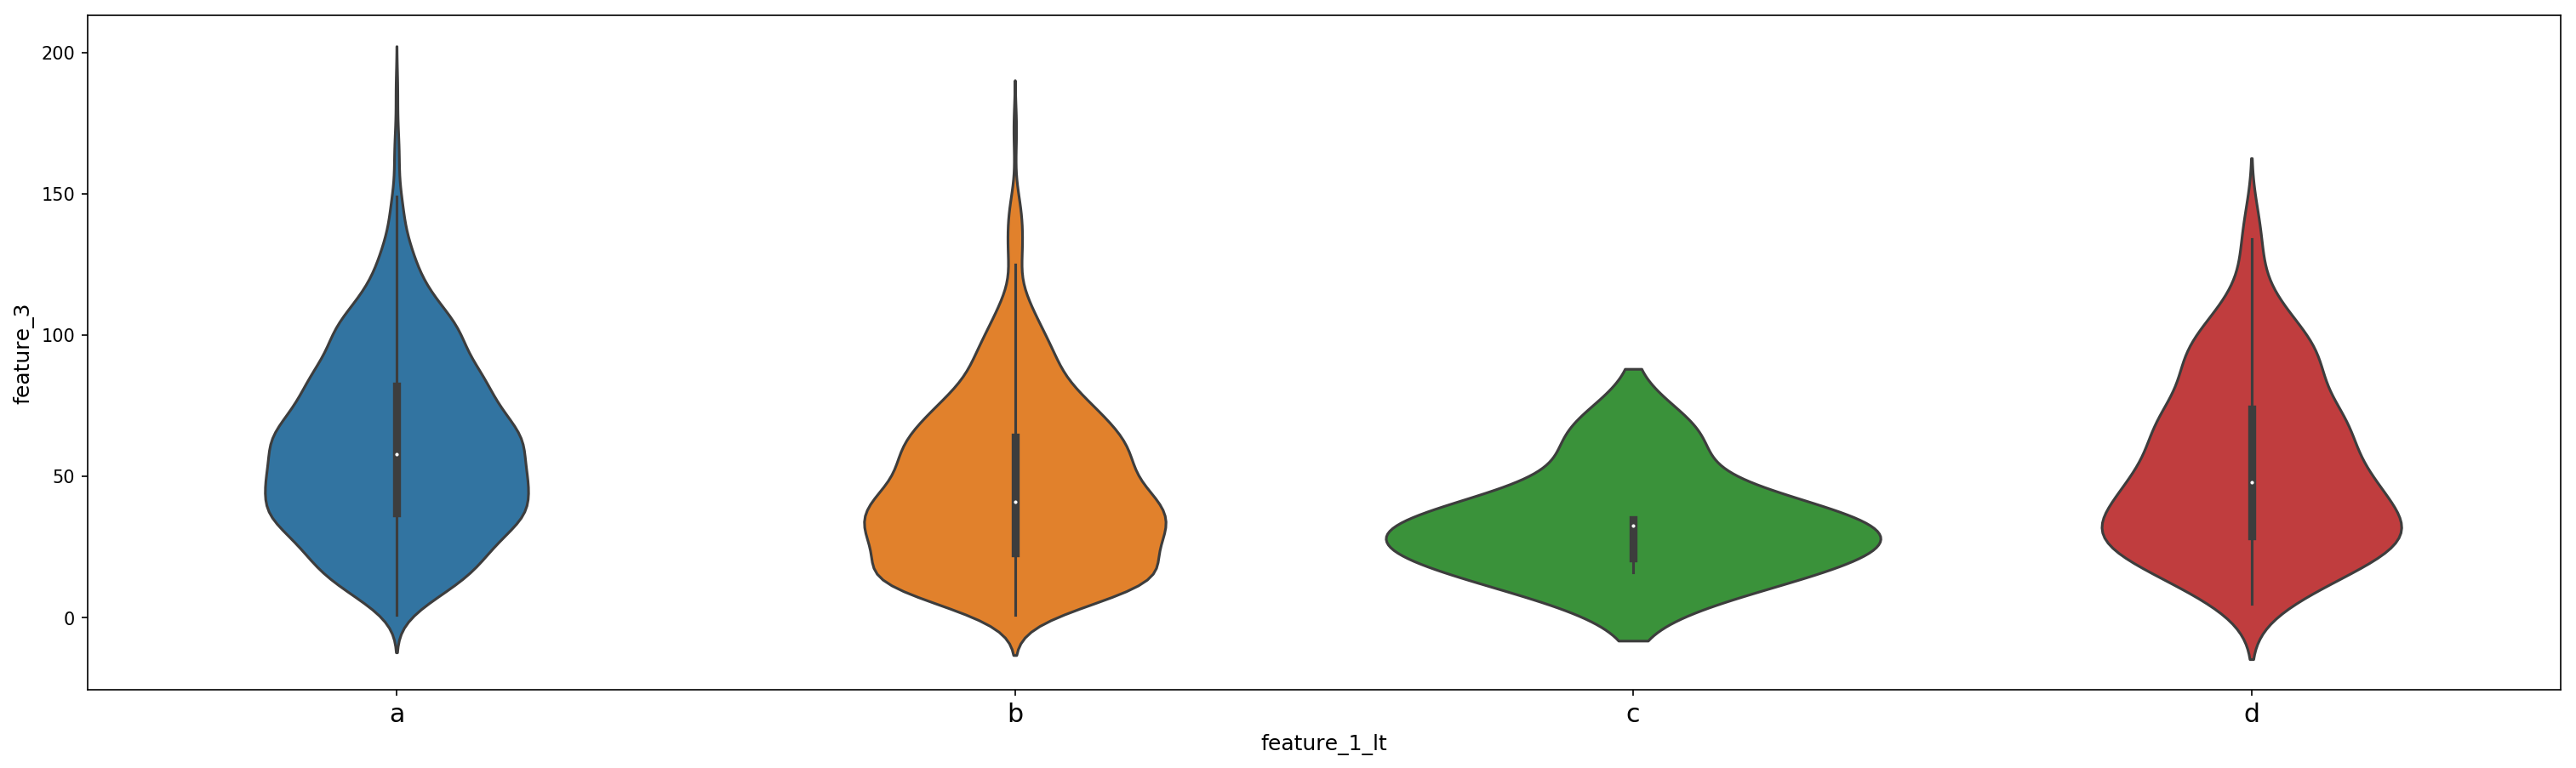

In [255]:
sns.violinplot(x = 'feature_1_lt', y = 'feature_3', data = df, order=['a','b','c','d'])

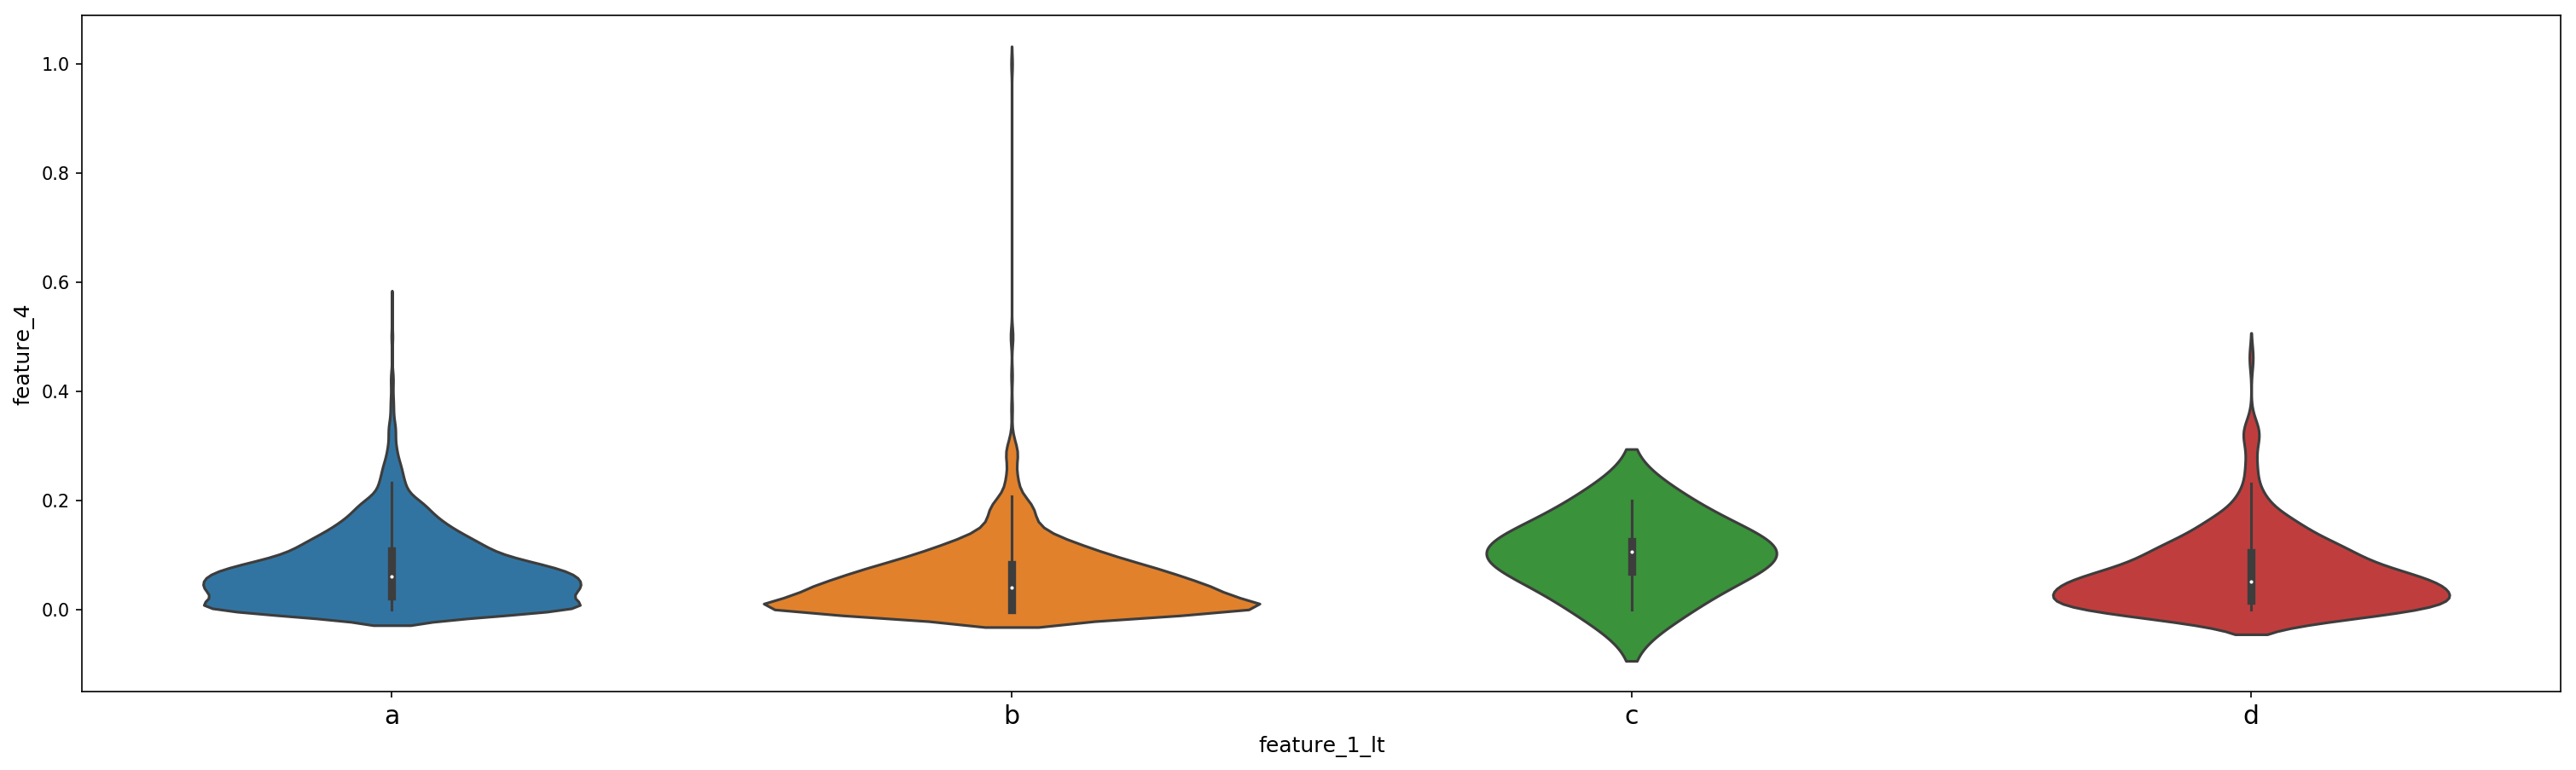

In [256]:
sns.violinplot(x = 'feature_1_lt', y = 'feature_4', data = df, order=['a','b','c','d'])

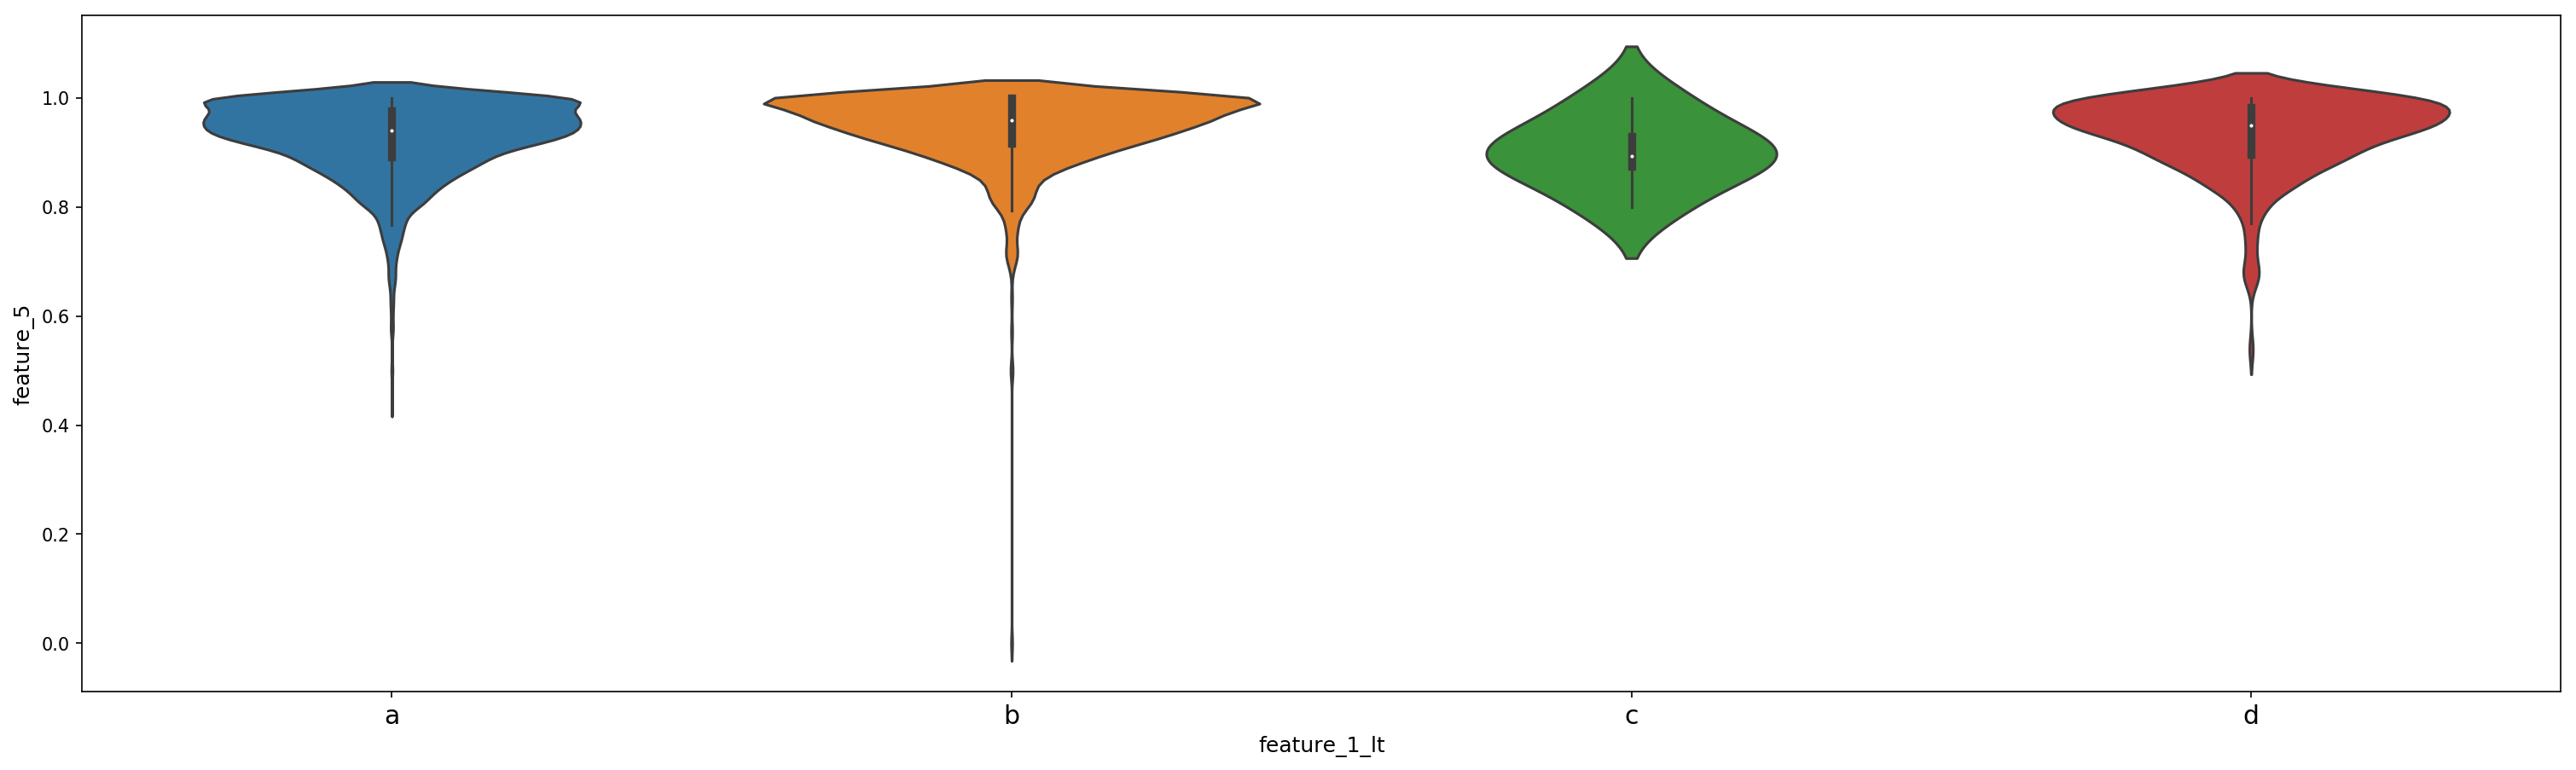

In [257]:
sns.violinplot(x = 'feature_1_lt', y = 'feature_5', data = df, order=['a','b','c','d'])

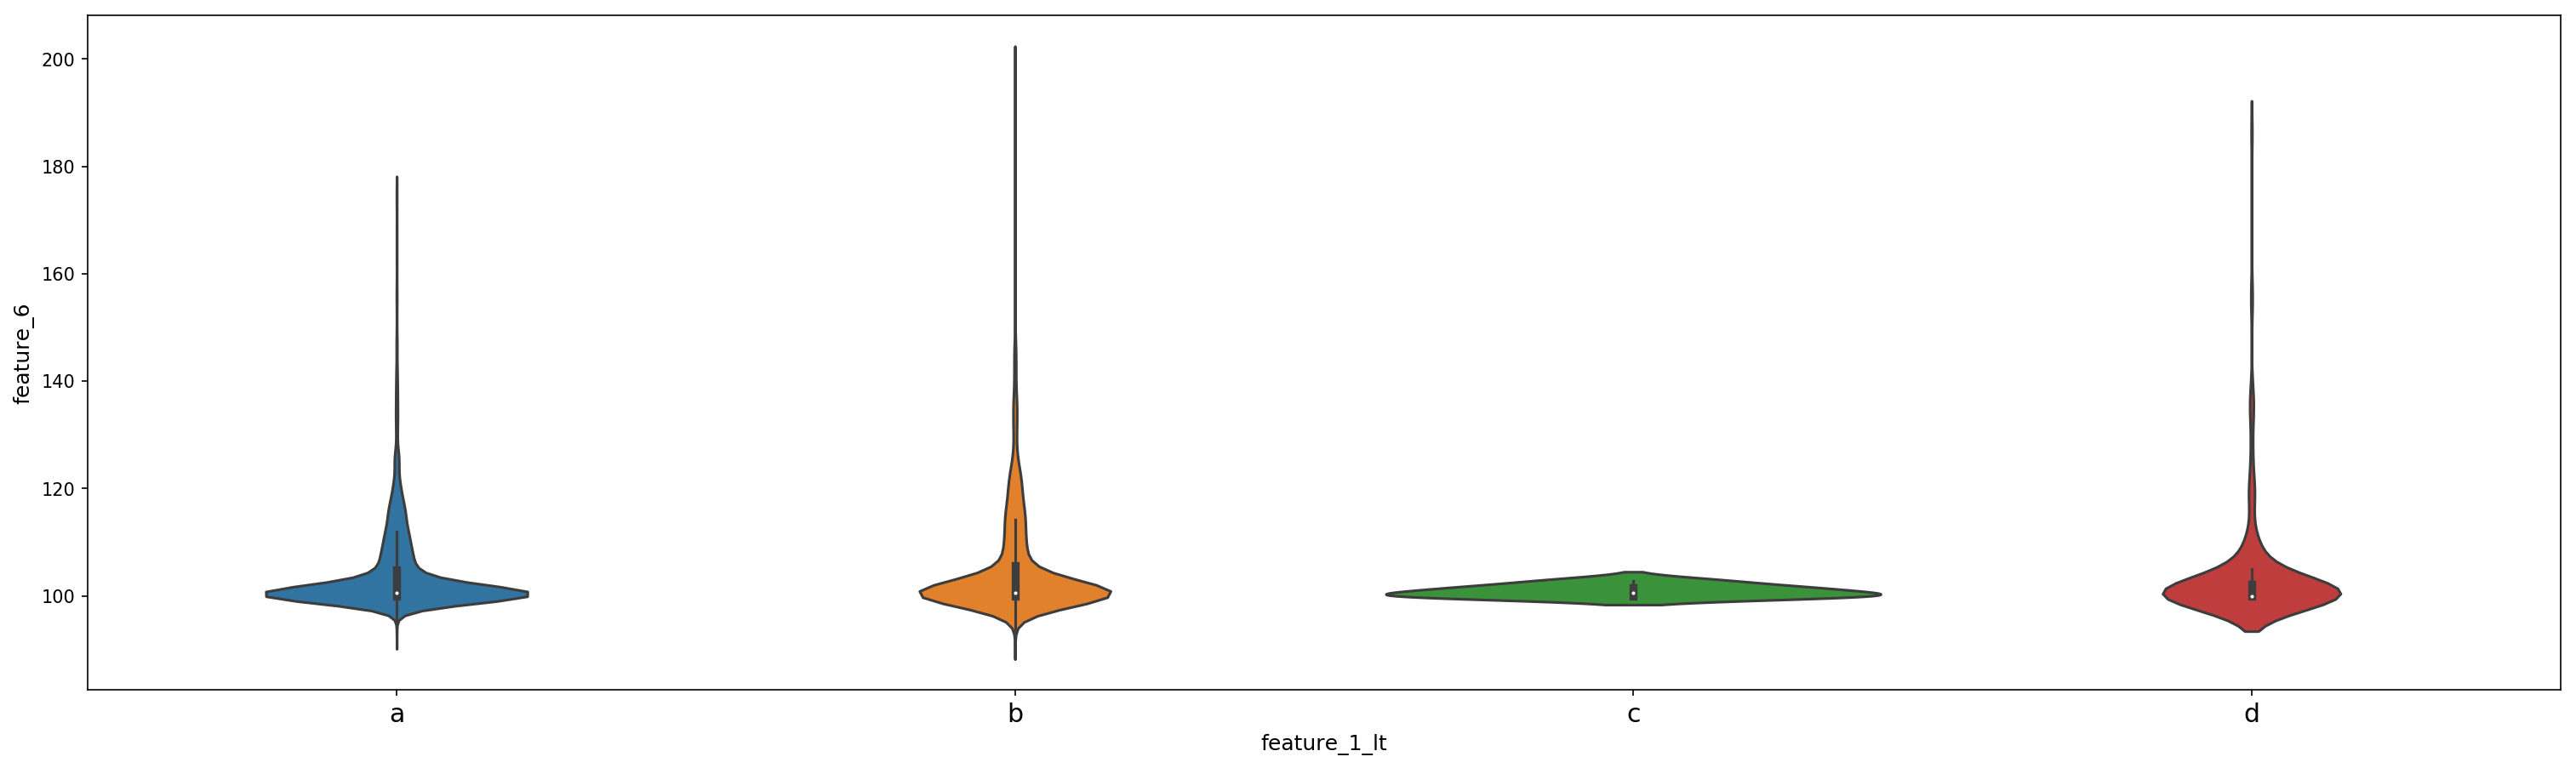

In [258]:
sns.violinplot(x = 'feature_1_lt', y = 'feature_6', data = df, order=['a','b','c','d'])

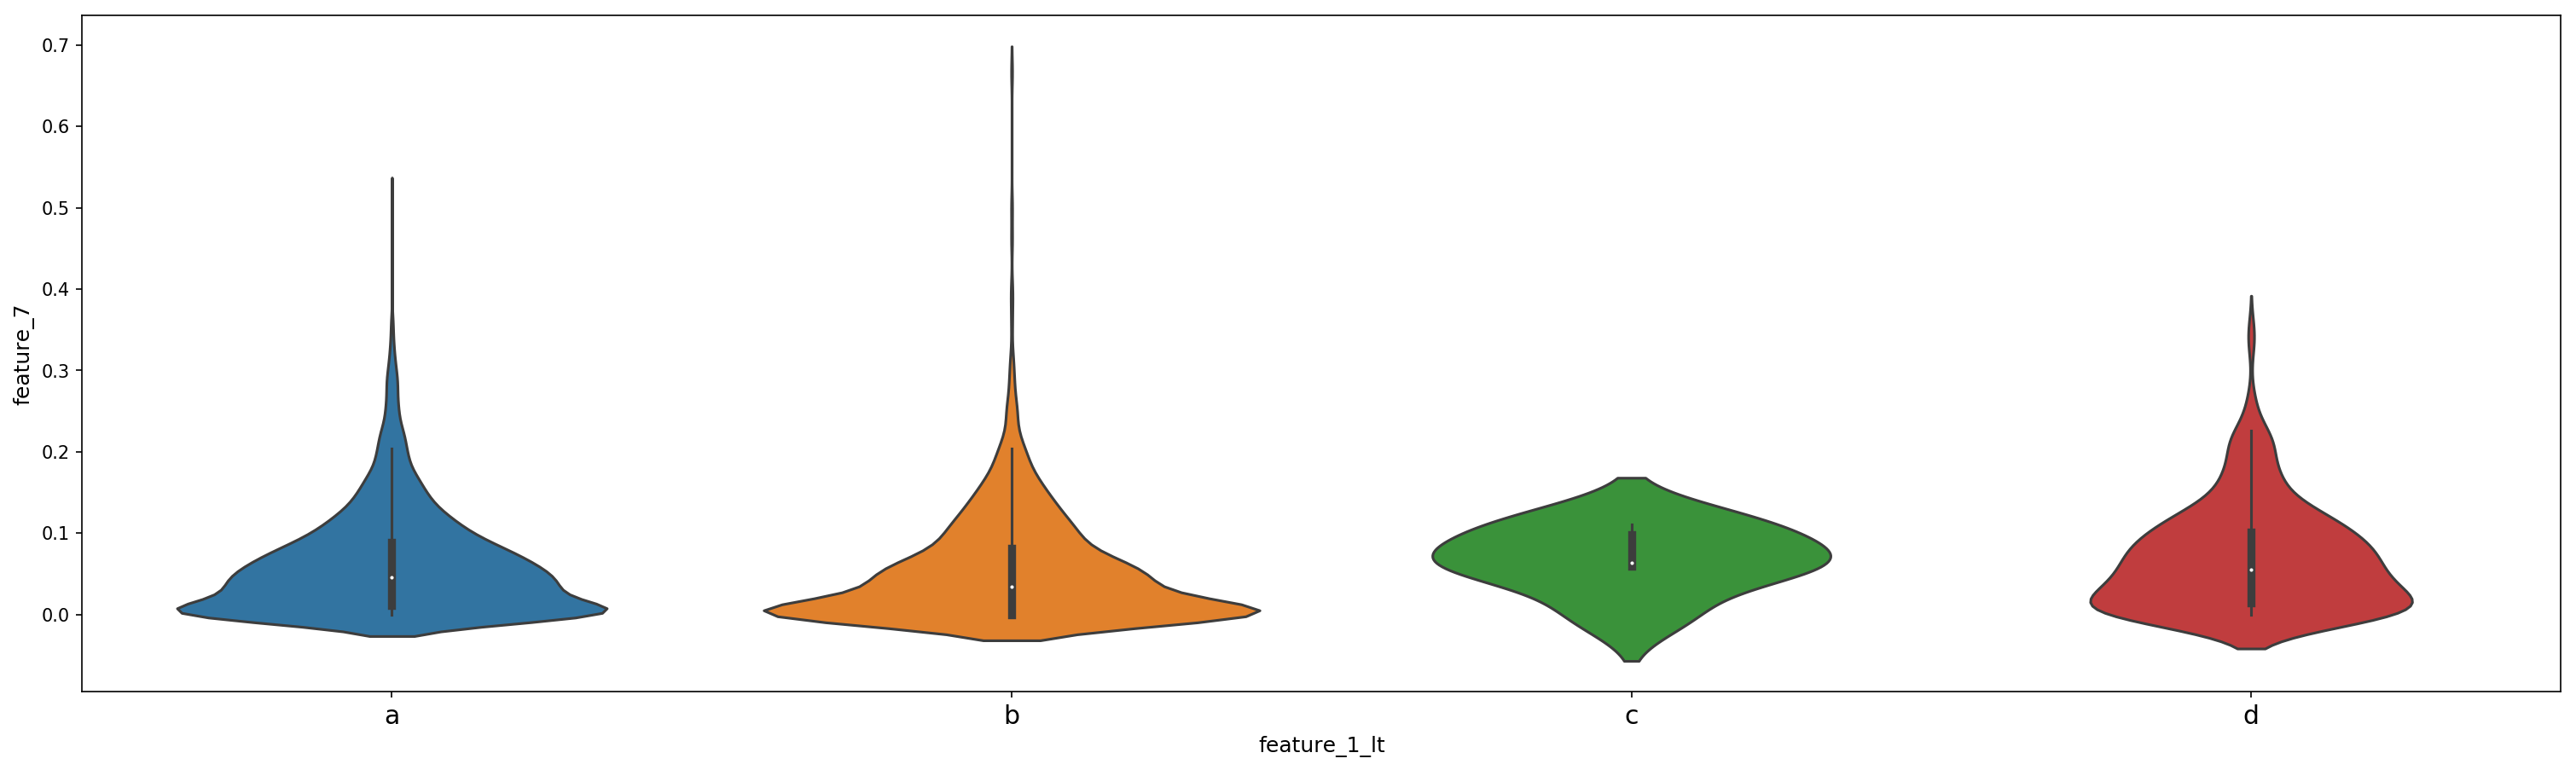

In [259]:
sns.violinplot(x = 'feature_1_lt', y = 'feature_7', data = df, order=['a','b','c','d'])

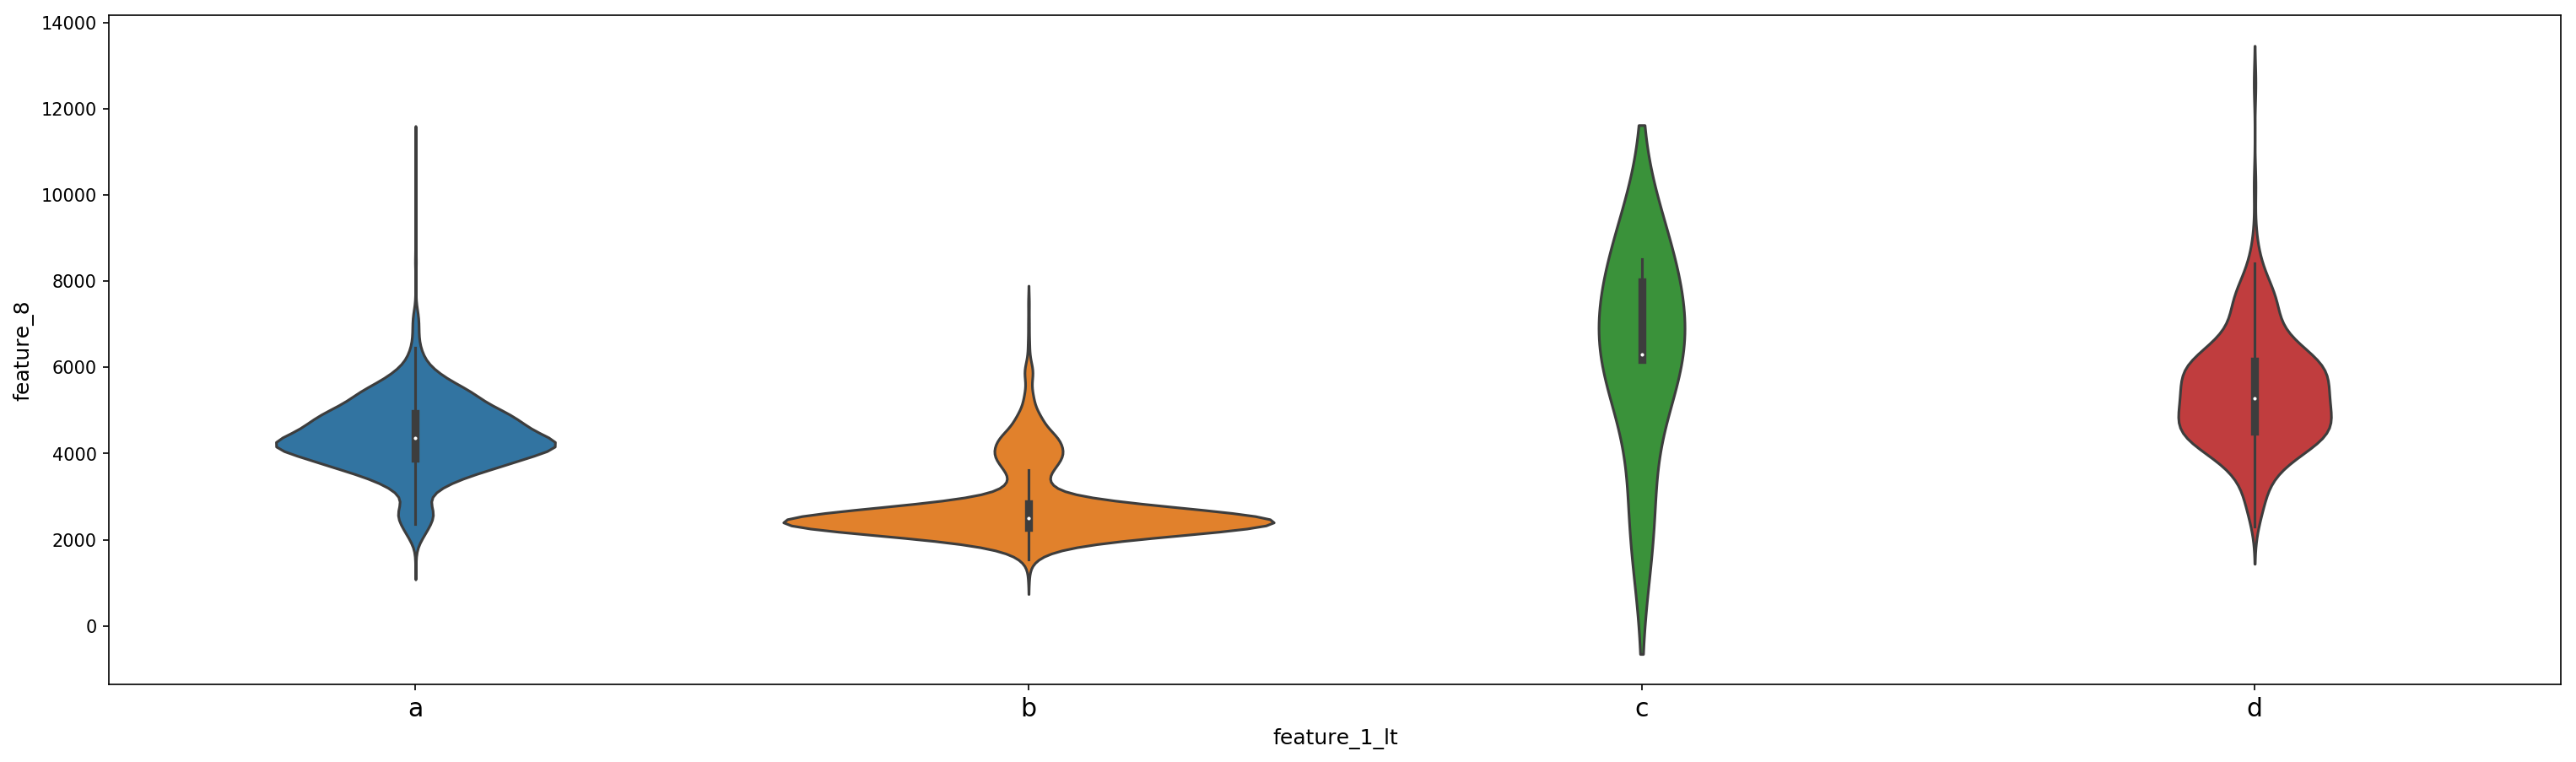

In [260]:
sns.violinplot(x = 'feature_1_lt', y = 'feature_8', data = df, order=['a','b','c','d'])

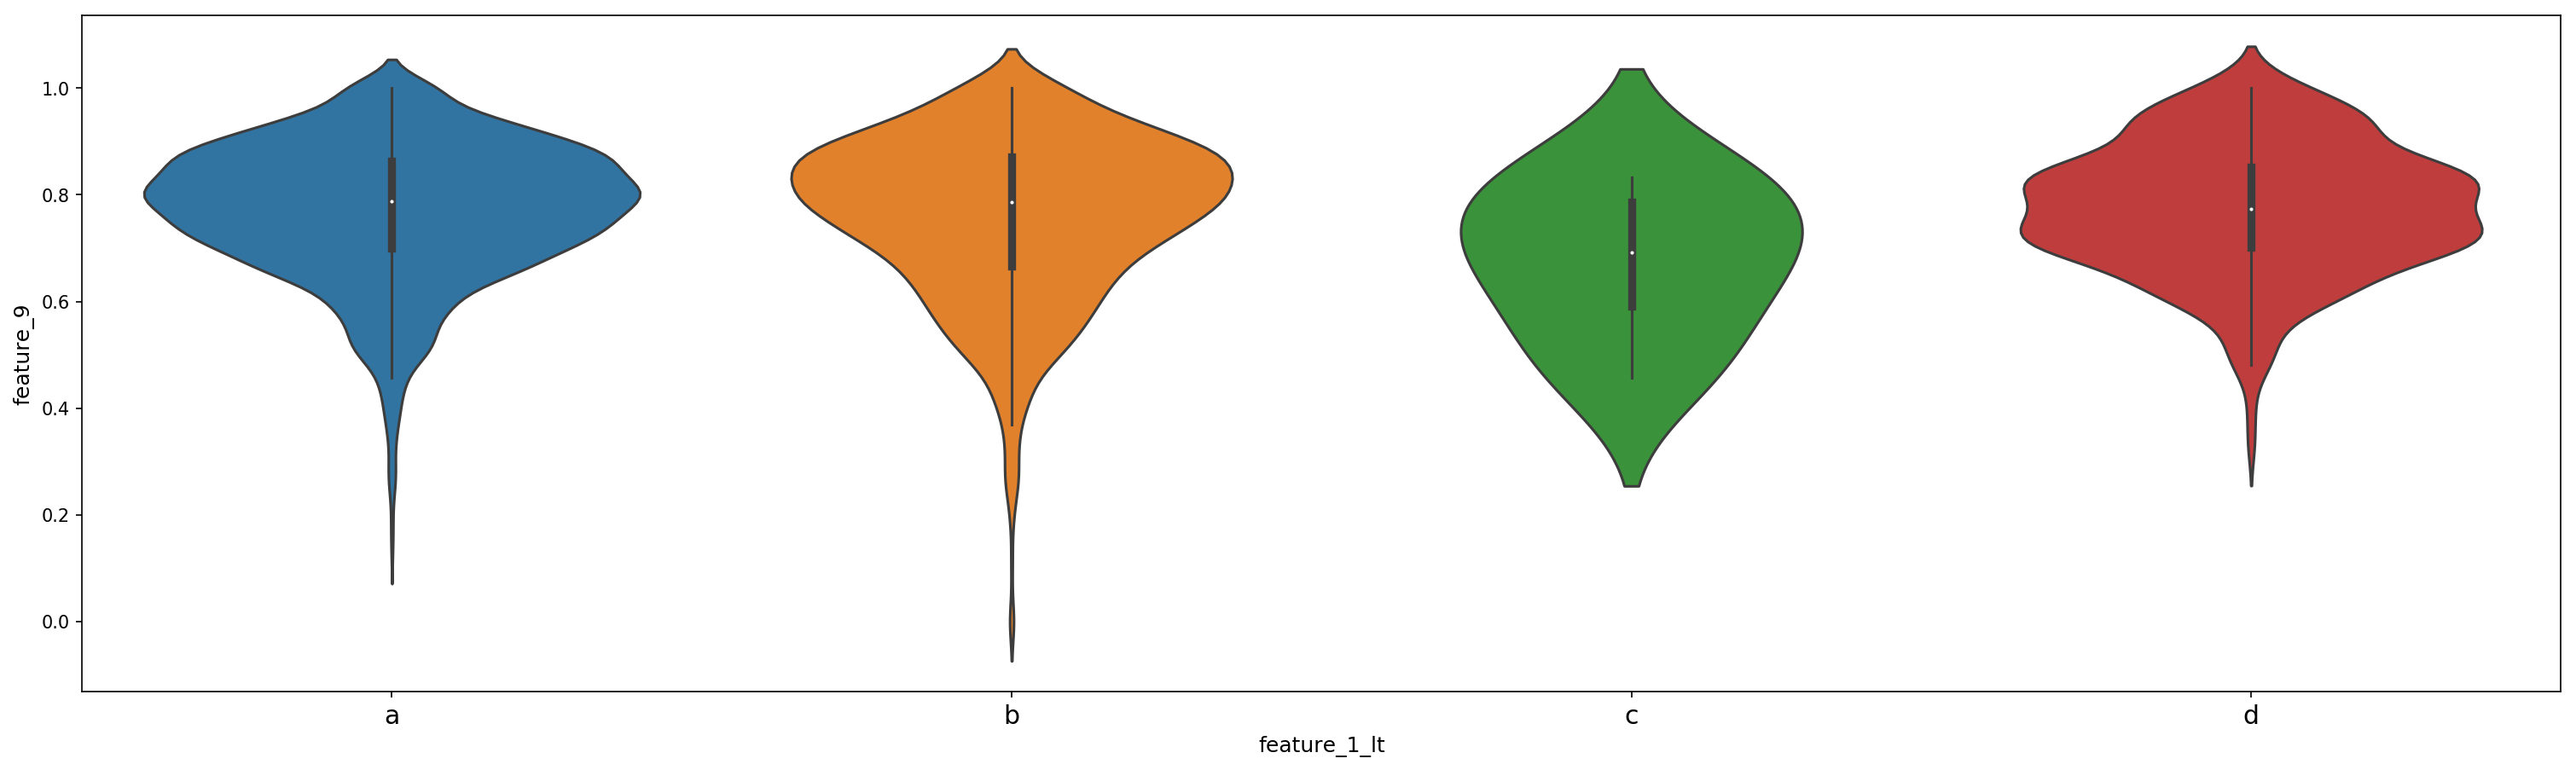

In [261]:
sns.violinplot(x = 'feature_1_lt', y = 'feature_9', data = df, order=['a','b','c','d'])

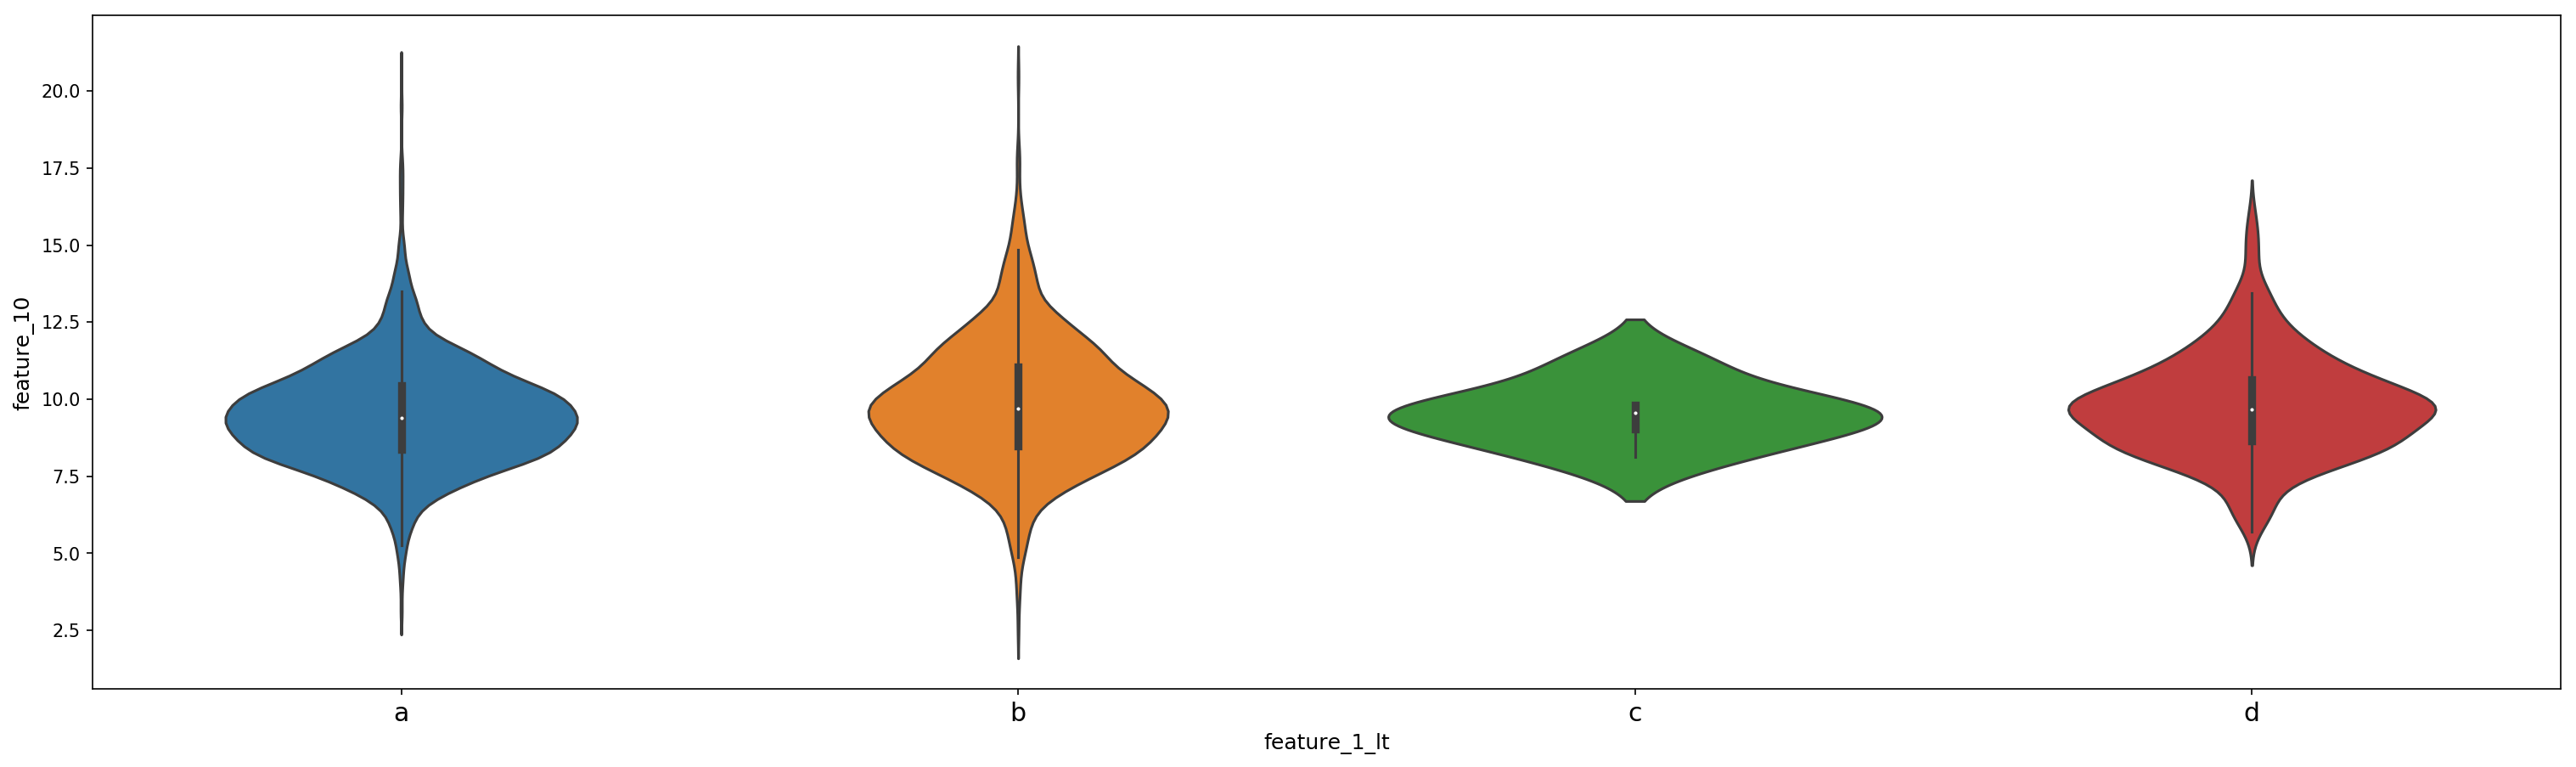

In [262]:
sns.violinplot(x = 'feature_1_lt', y = 'feature_10', data = df, order=['a','b','c','d'])

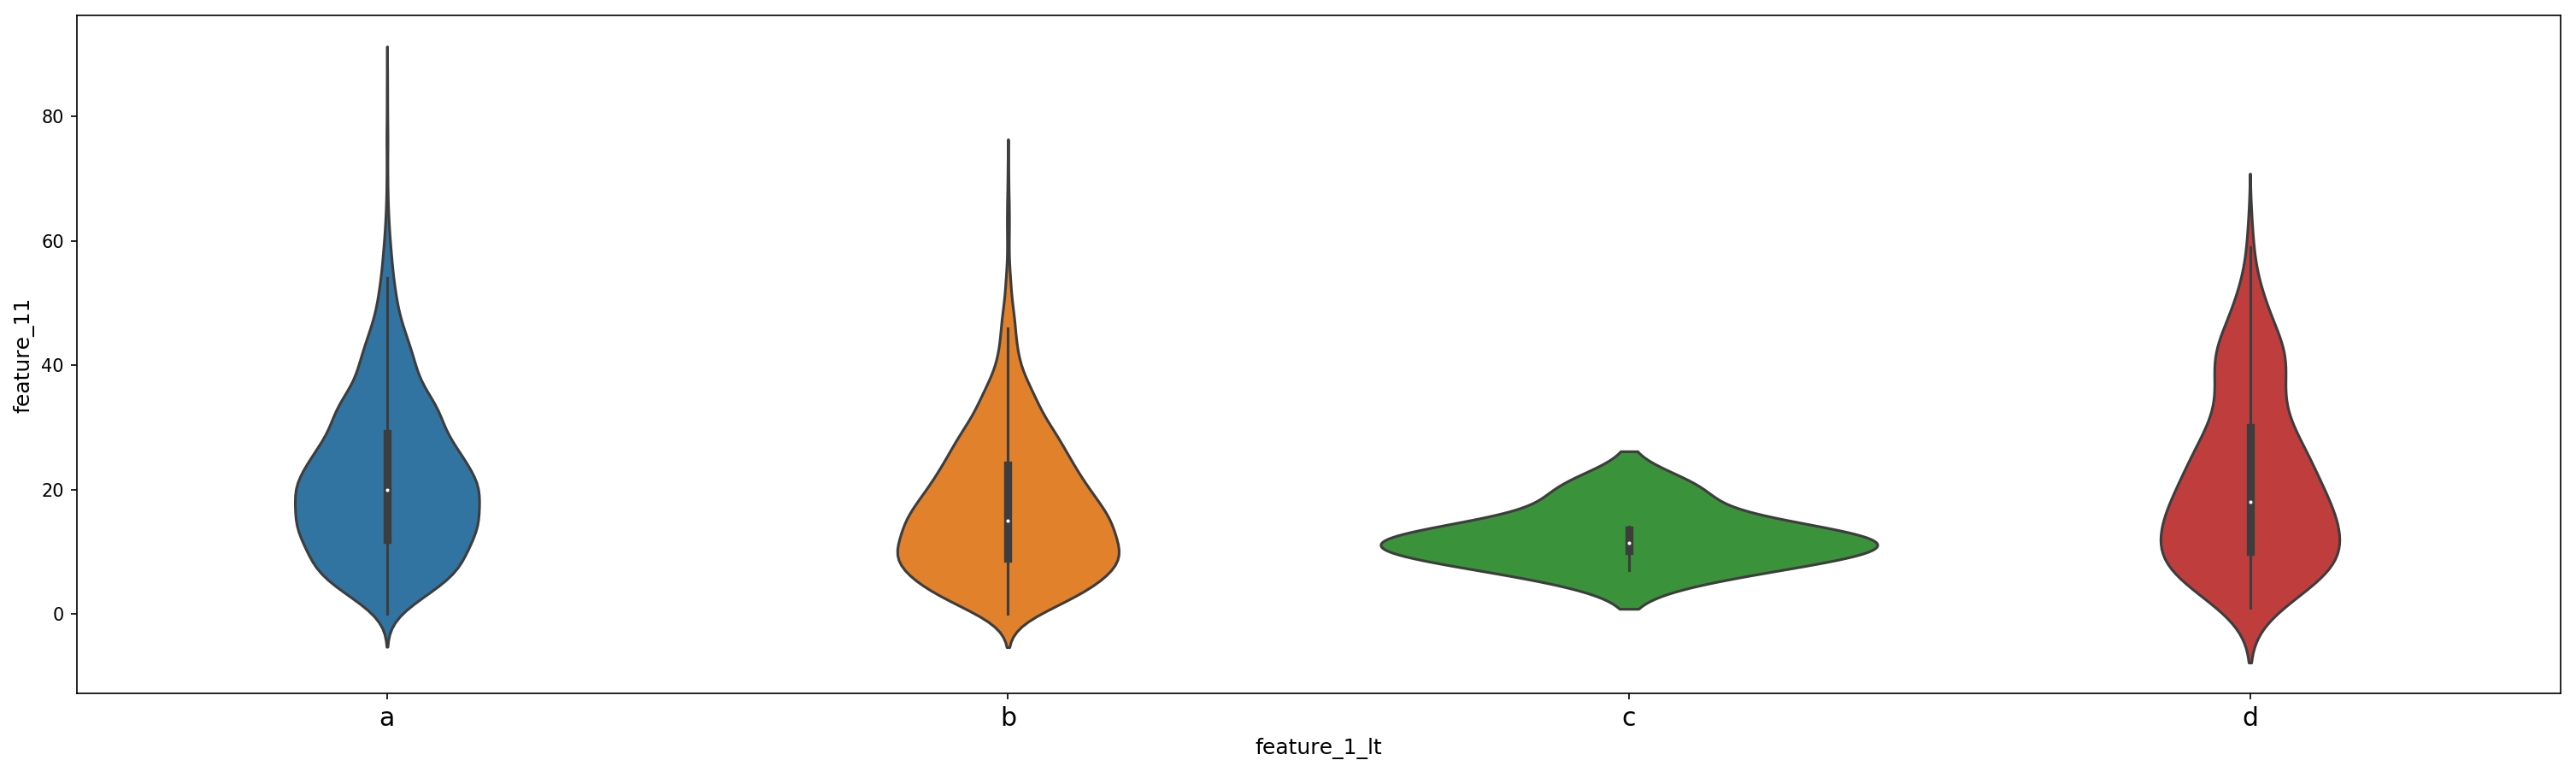

In [263]:
sns.violinplot(x = 'feature_1_lt', y = 'feature_11', data = df, order=['a','b','c','d'])

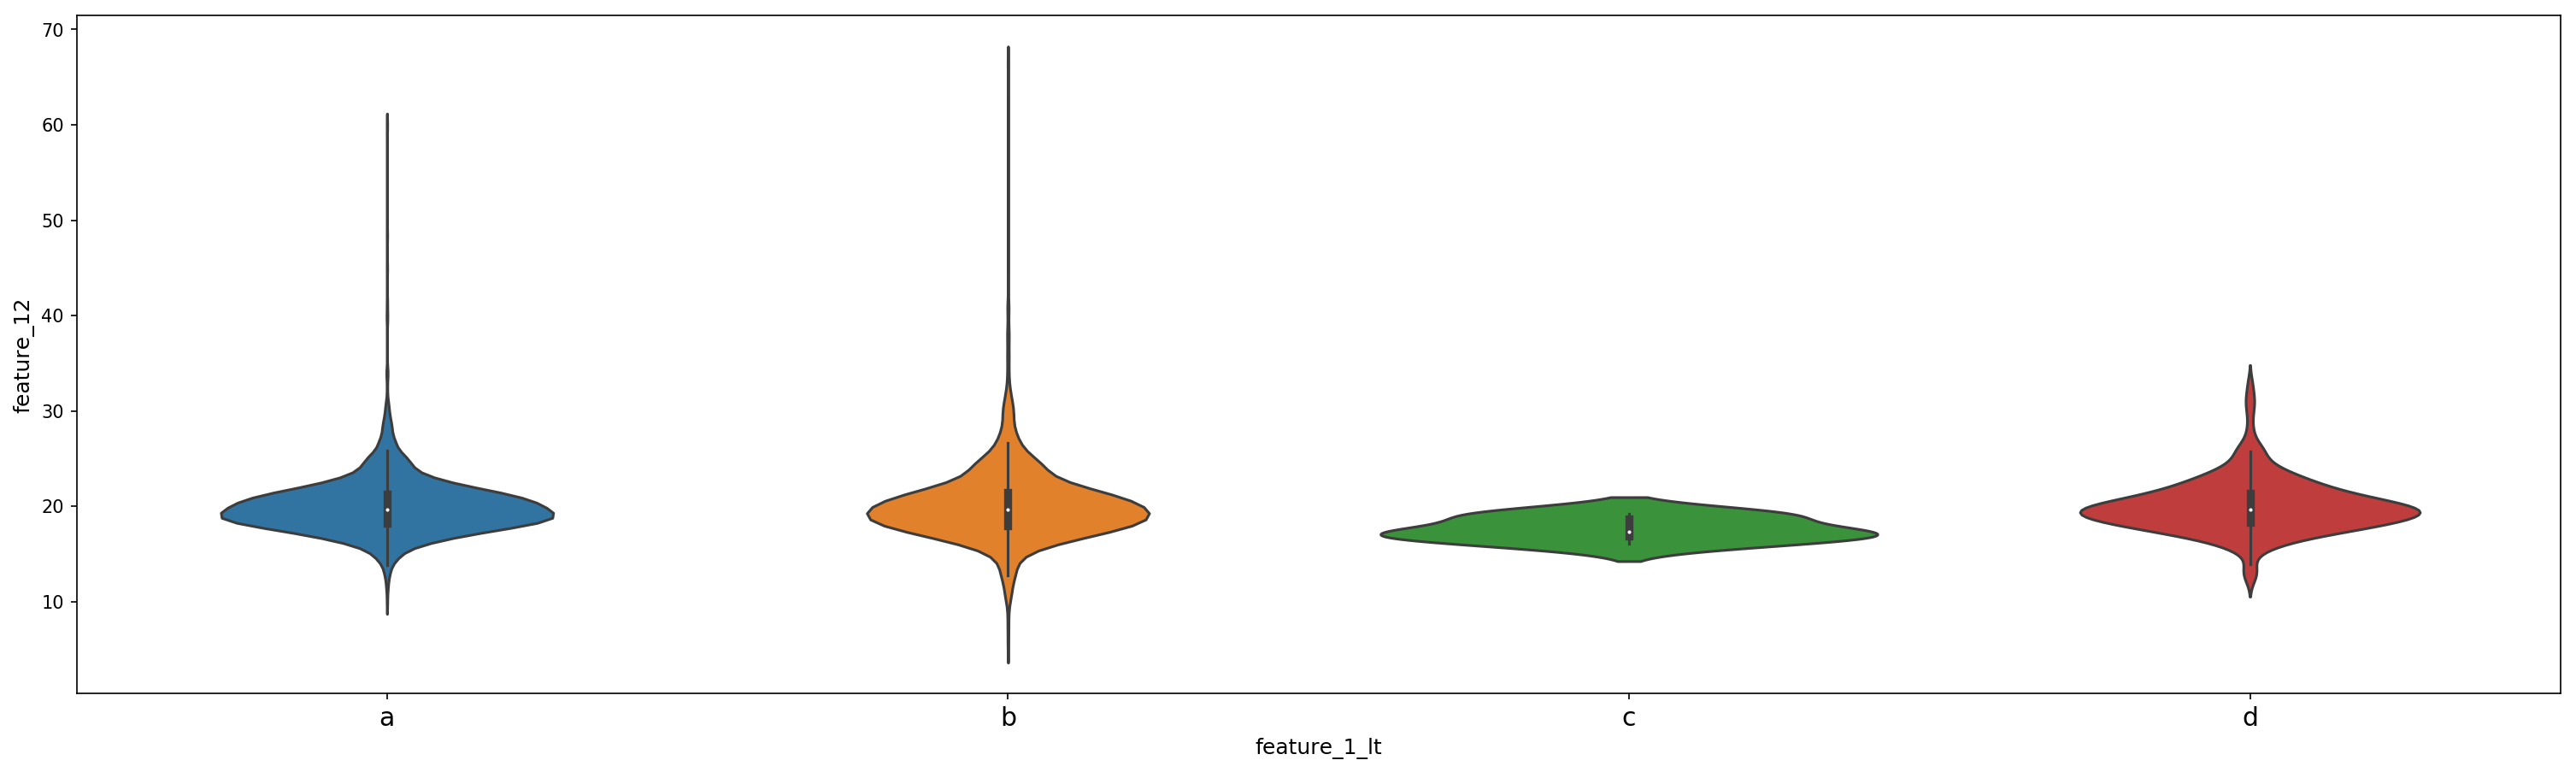

In [264]:
sns.violinplot(x = 'feature_1_lt', y = 'feature_12', data = df, order=['a','b','c','d'])

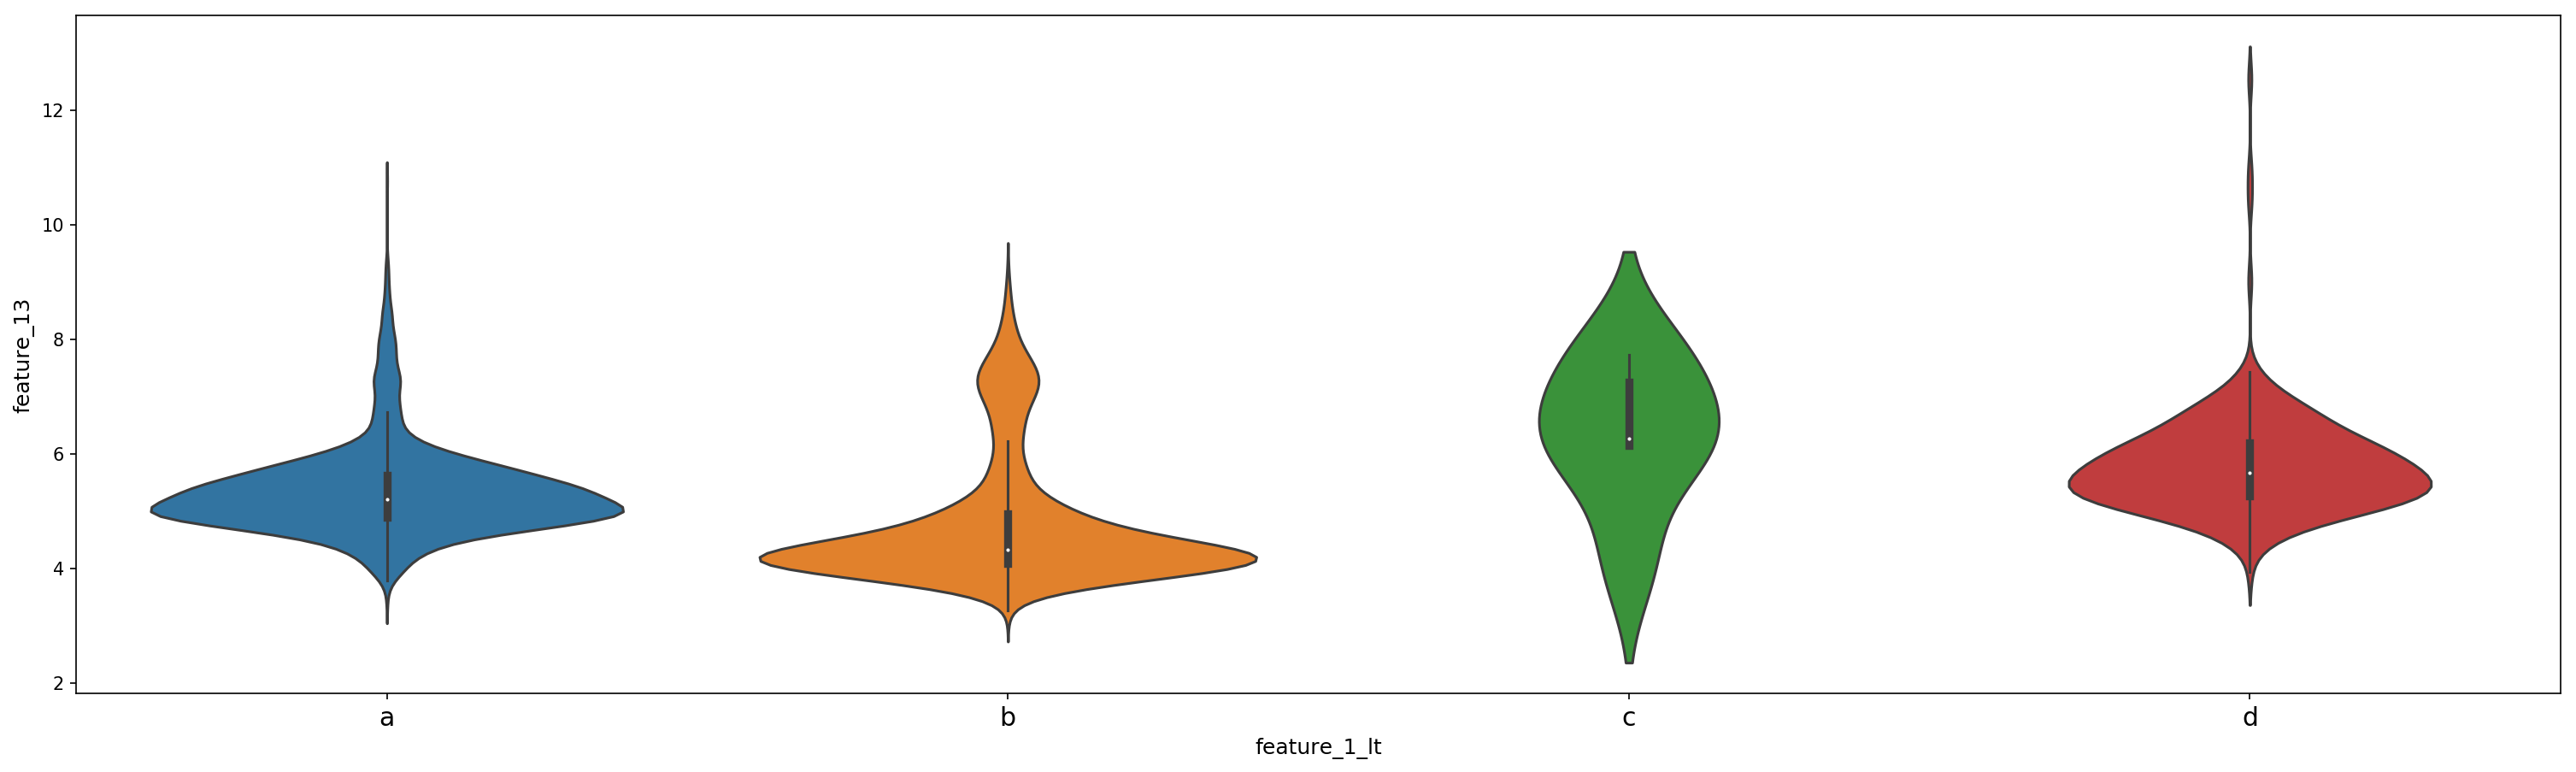

In [265]:
sns.violinplot(x = 'feature_1_lt', y = 'feature_13', data = df, order=['a','b','c','d'])

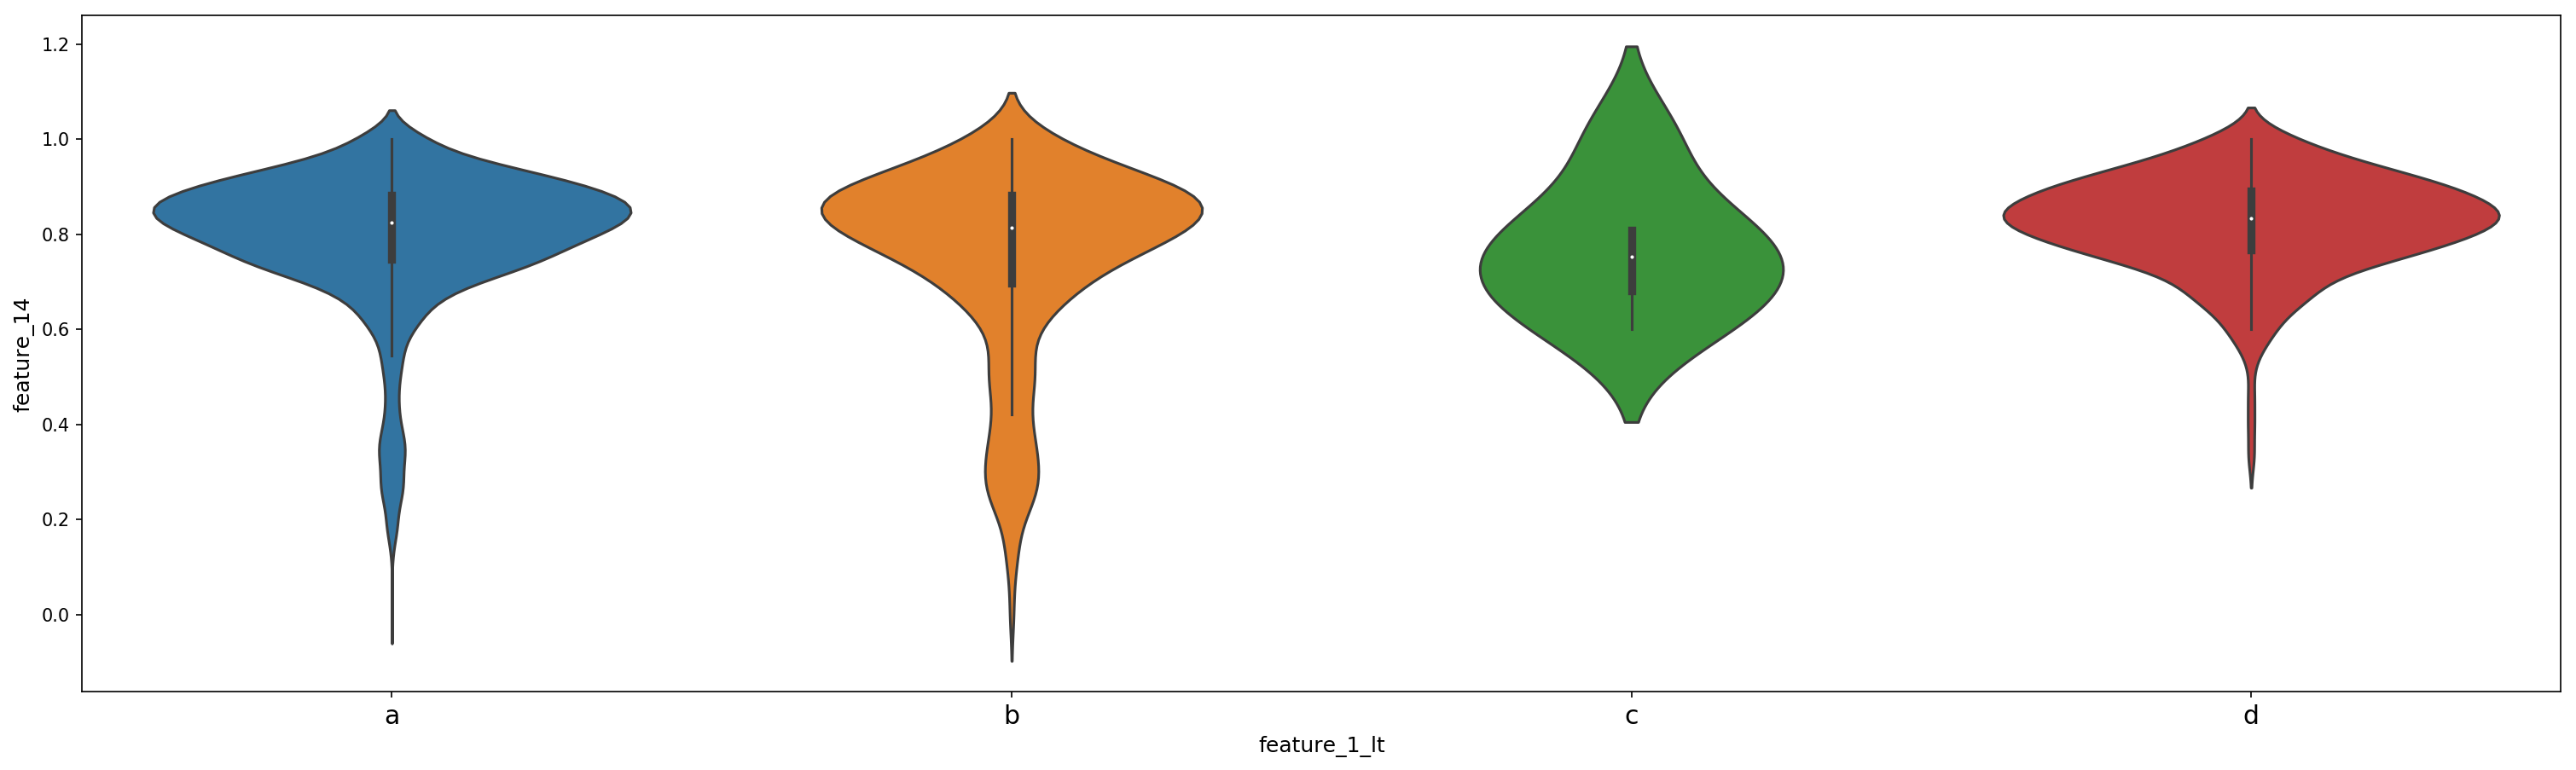

In [266]:
sns.violinplot(x = 'feature_1_lt', y = 'feature_14', data = df, order=['a','b','c','d'])

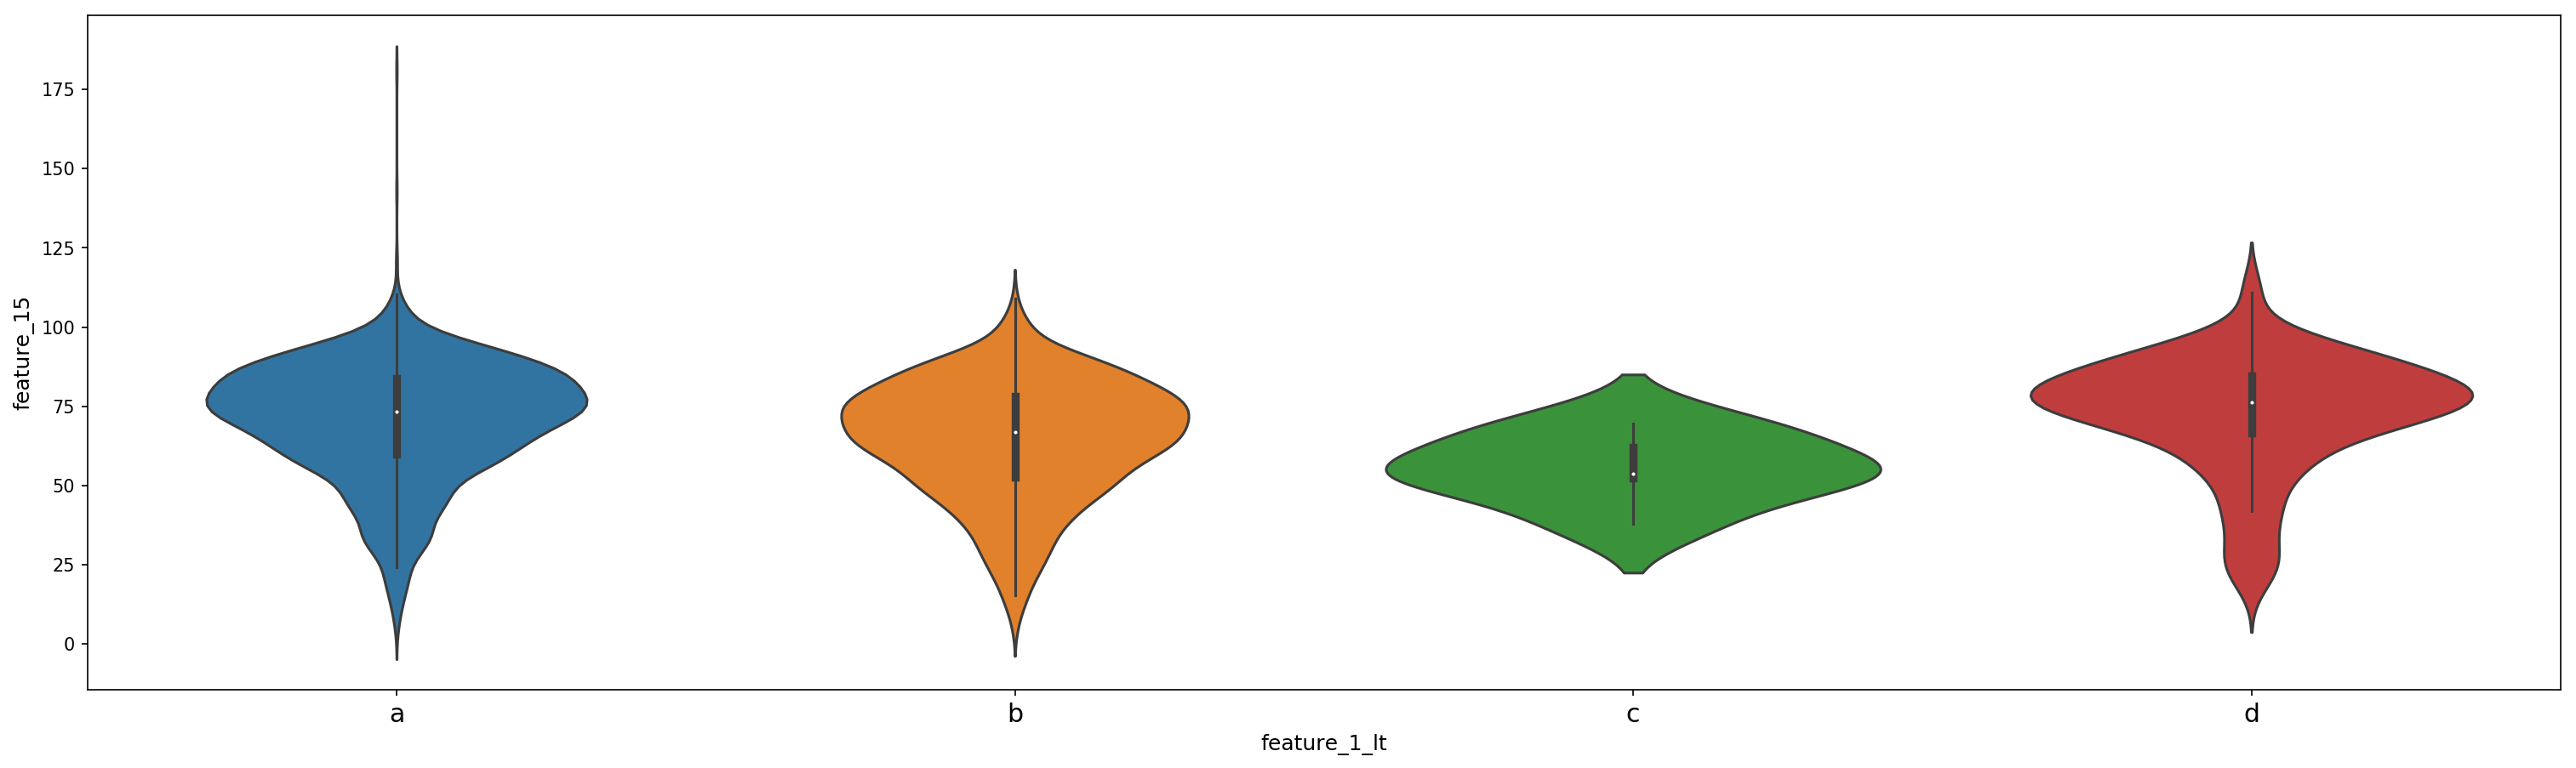

In [267]:
sns.violinplot(x = 'feature_1_lt', y = 'feature_15', data = df, order=['a','b','c','d'])

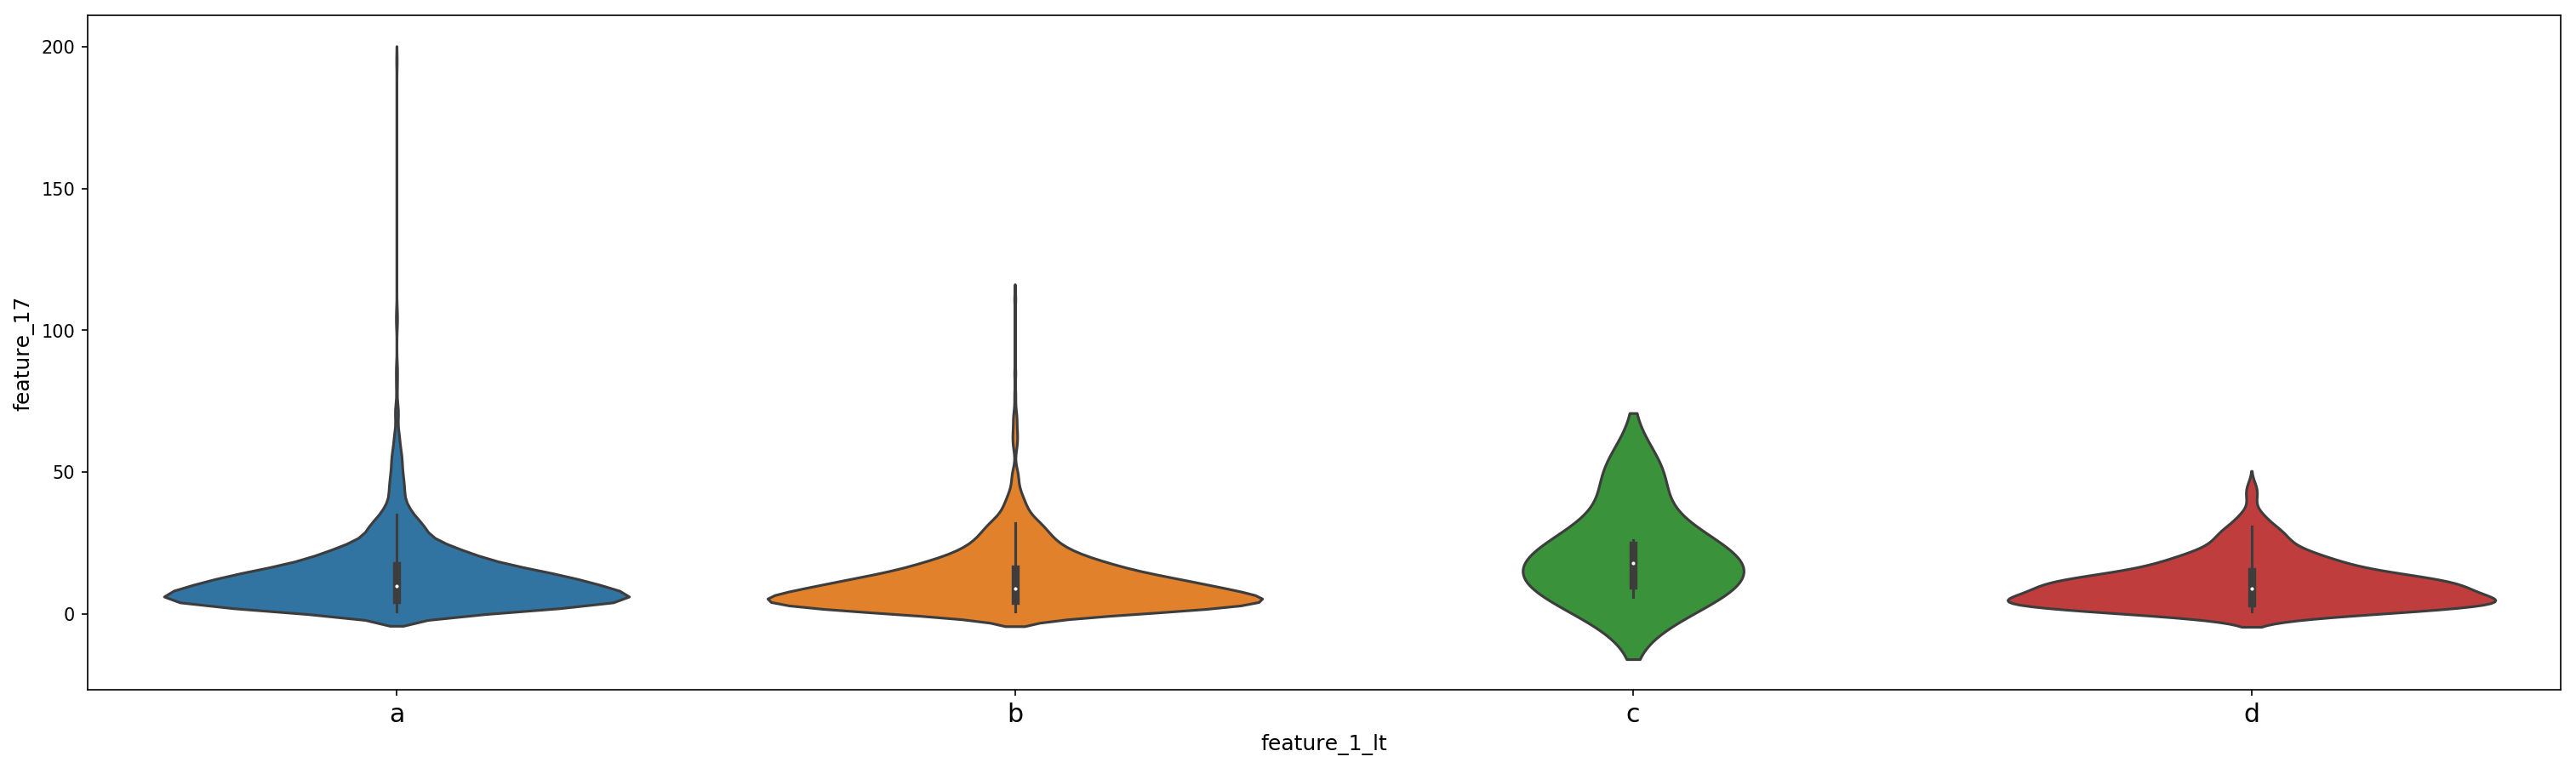

In [268]:
sns.violinplot(x = 'feature_1_lt', y = 'feature_17', data = df, order=['a','b','c','d'])

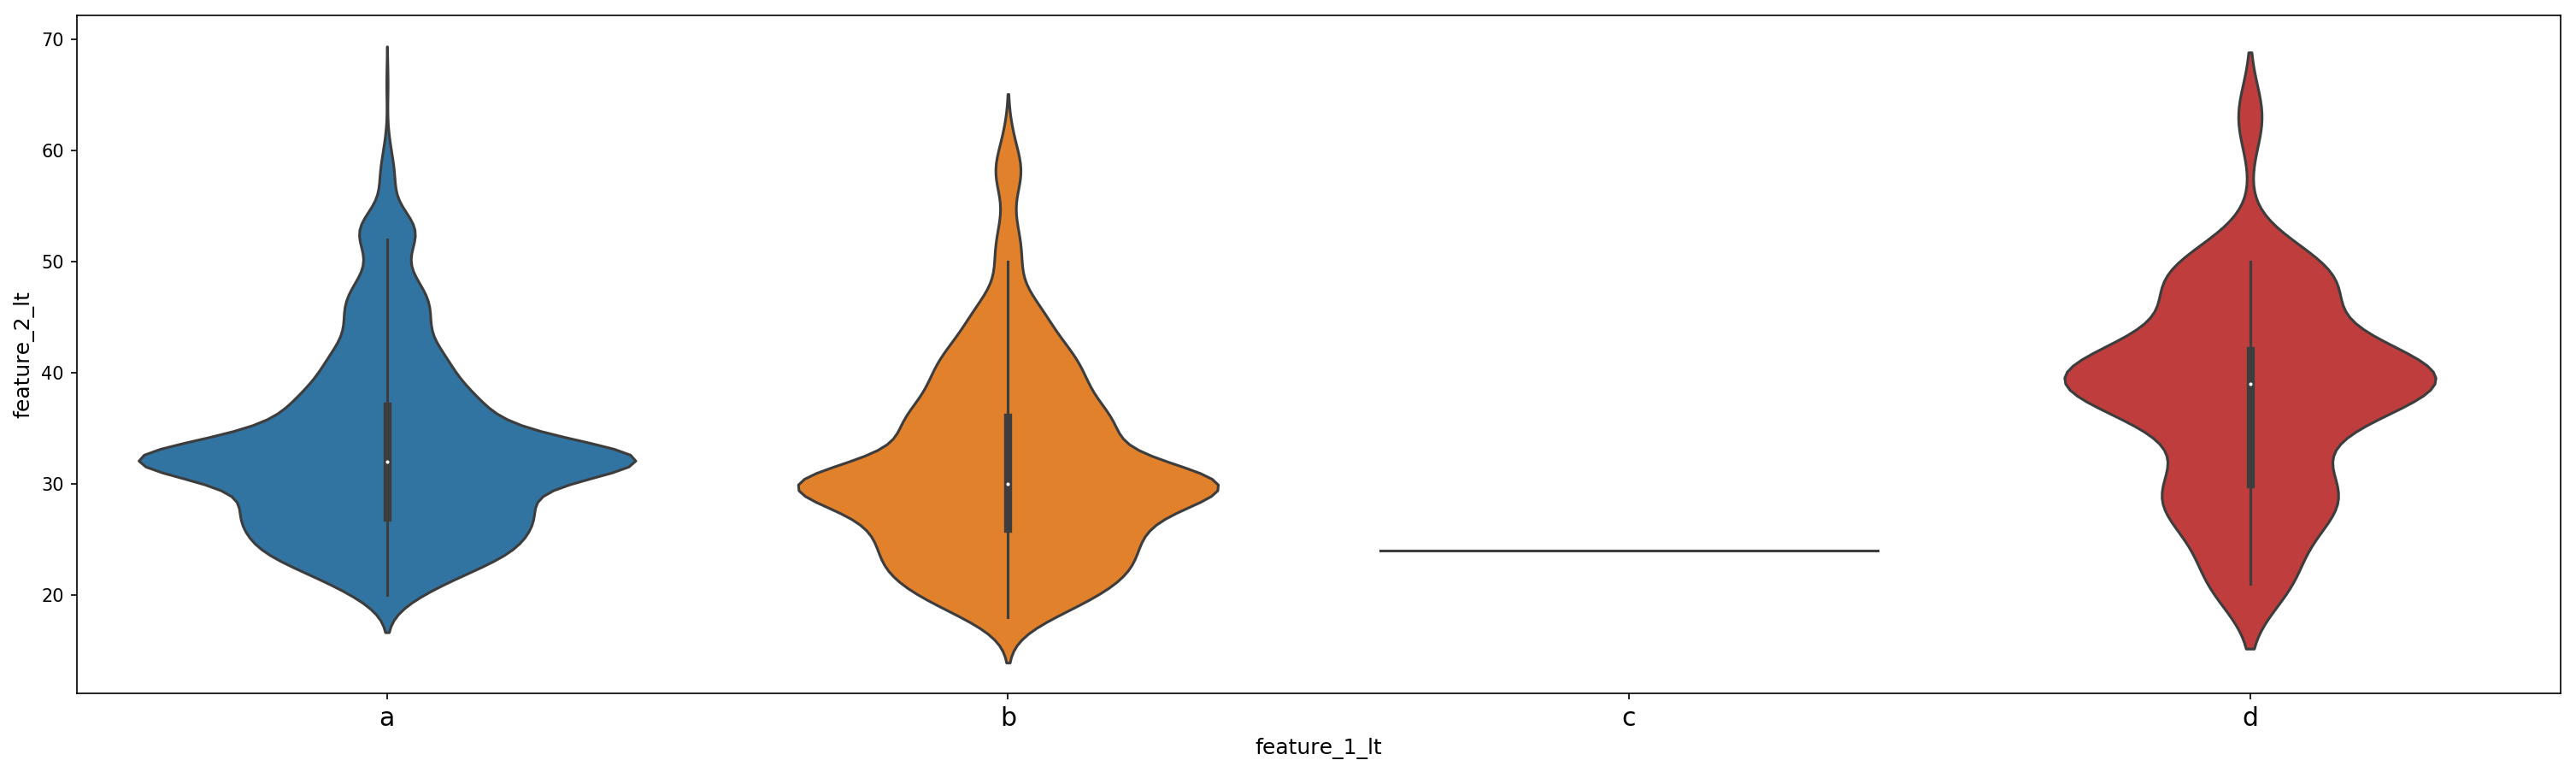

In [269]:
sns.violinplot(x = 'feature_1_lt', y = 'feature_2_lt', data = df, order=['a','b','c','d'])

We show the correlation between the two categorical features of our data.

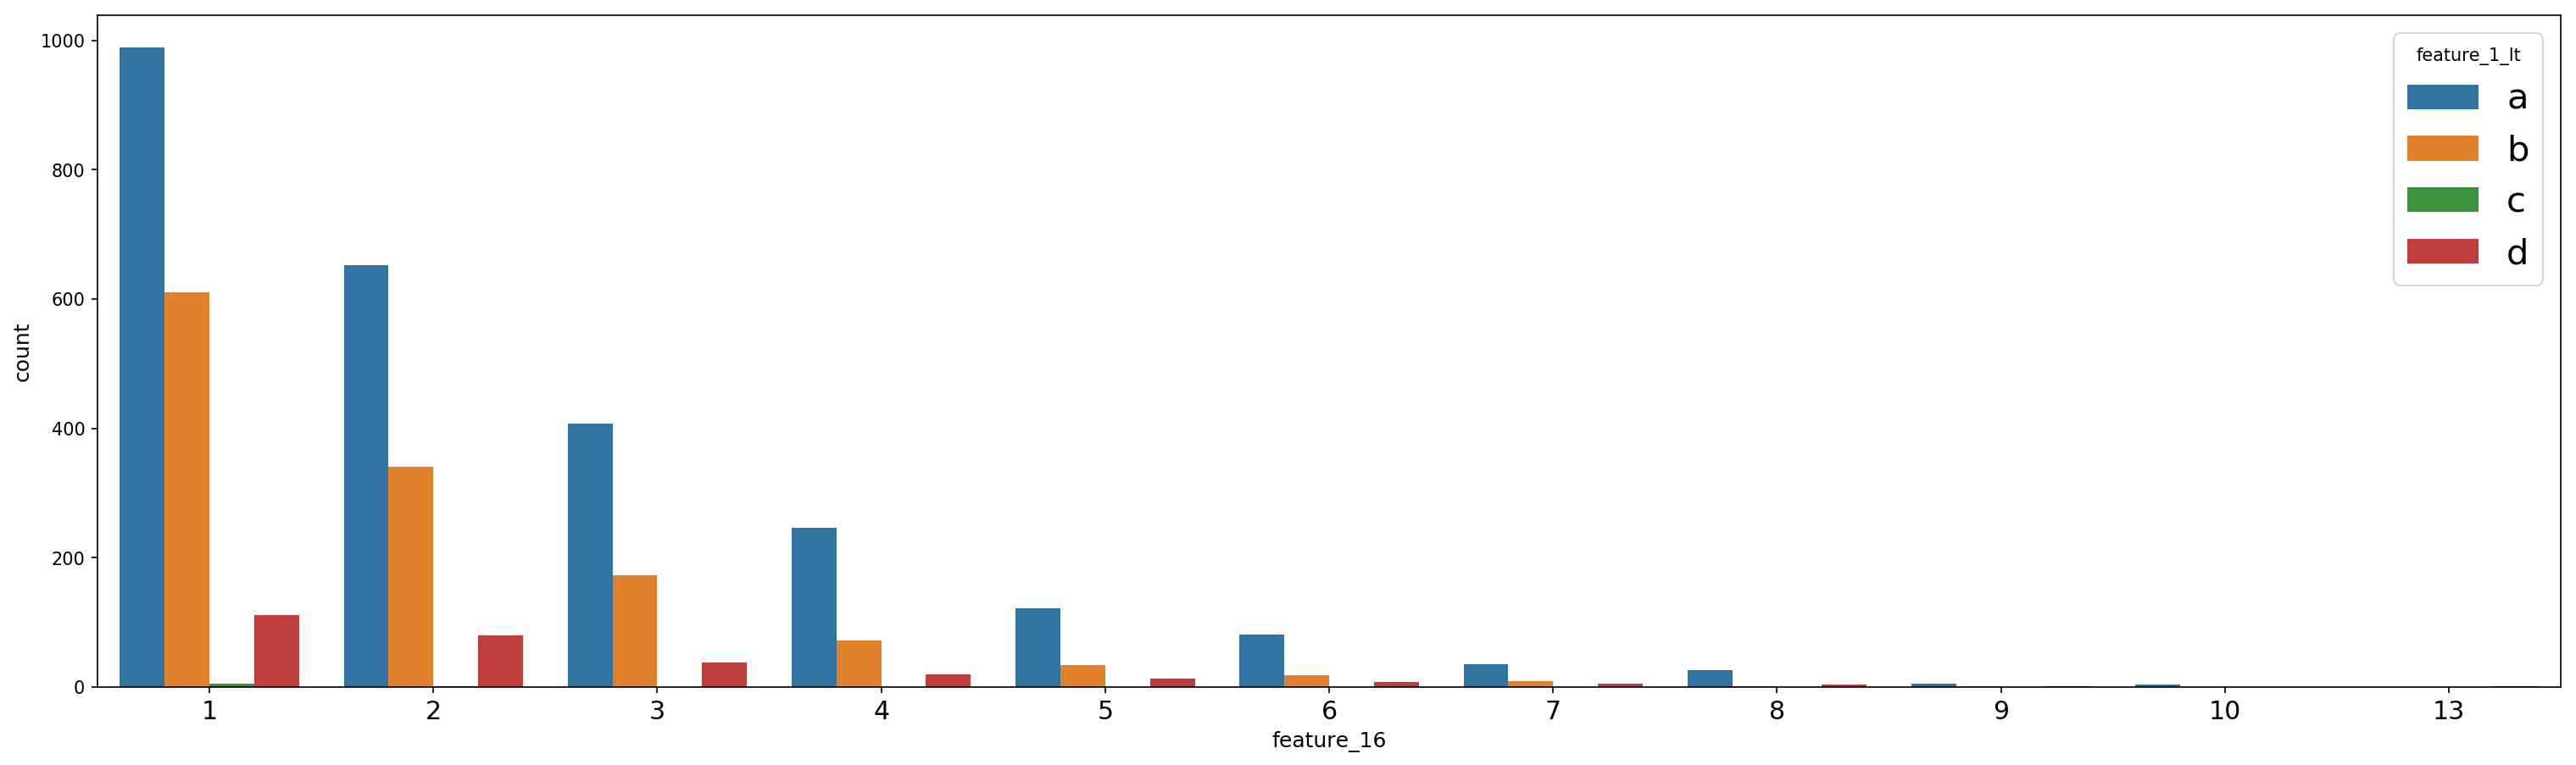

In [270]:
sns.countplot(x="feature_16",
              hue="feature_1_lt",
              data=df,
              hue_order=['a','b','c','d'])

plt.legend(loc='upper right', title = 'feature_1_lt')

We show the correlation between feature_2_lt and both categorical features.

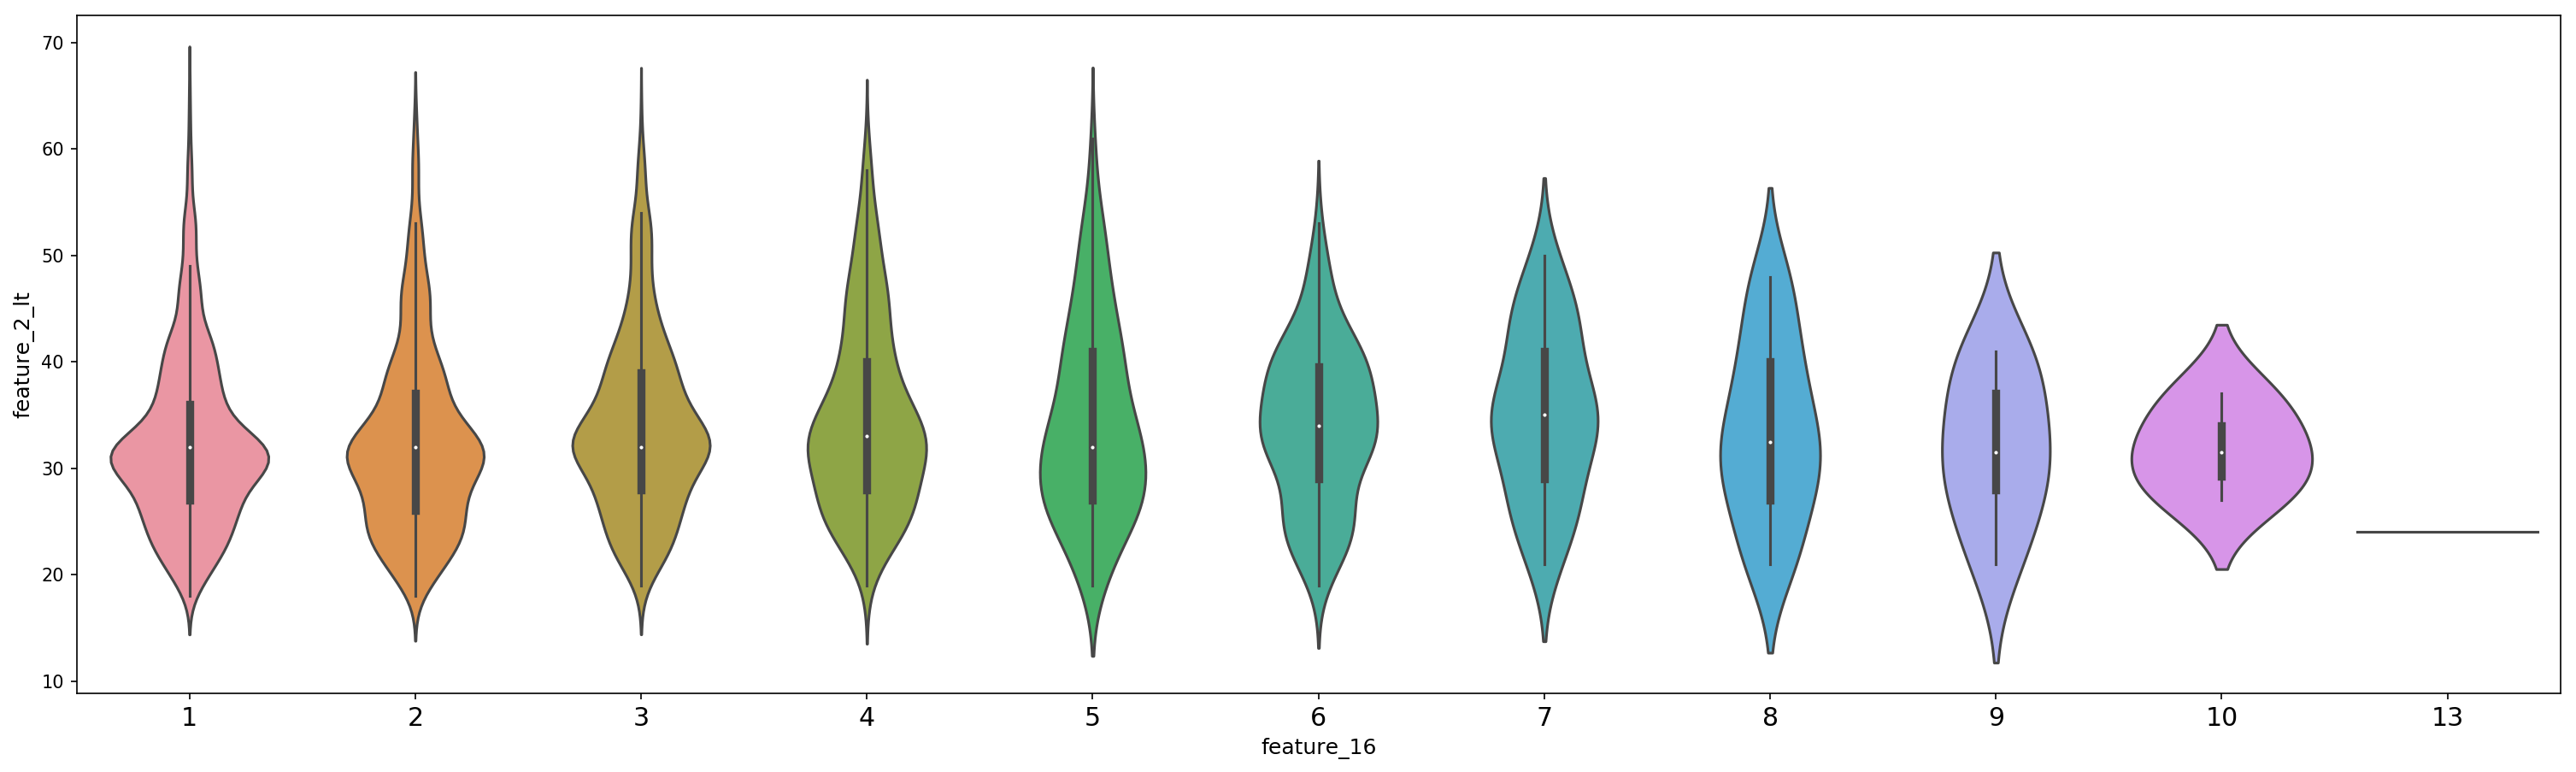

In [271]:
sns.violinplot(
    x='feature_16',
    y='feature_2_lt',
    data=df)

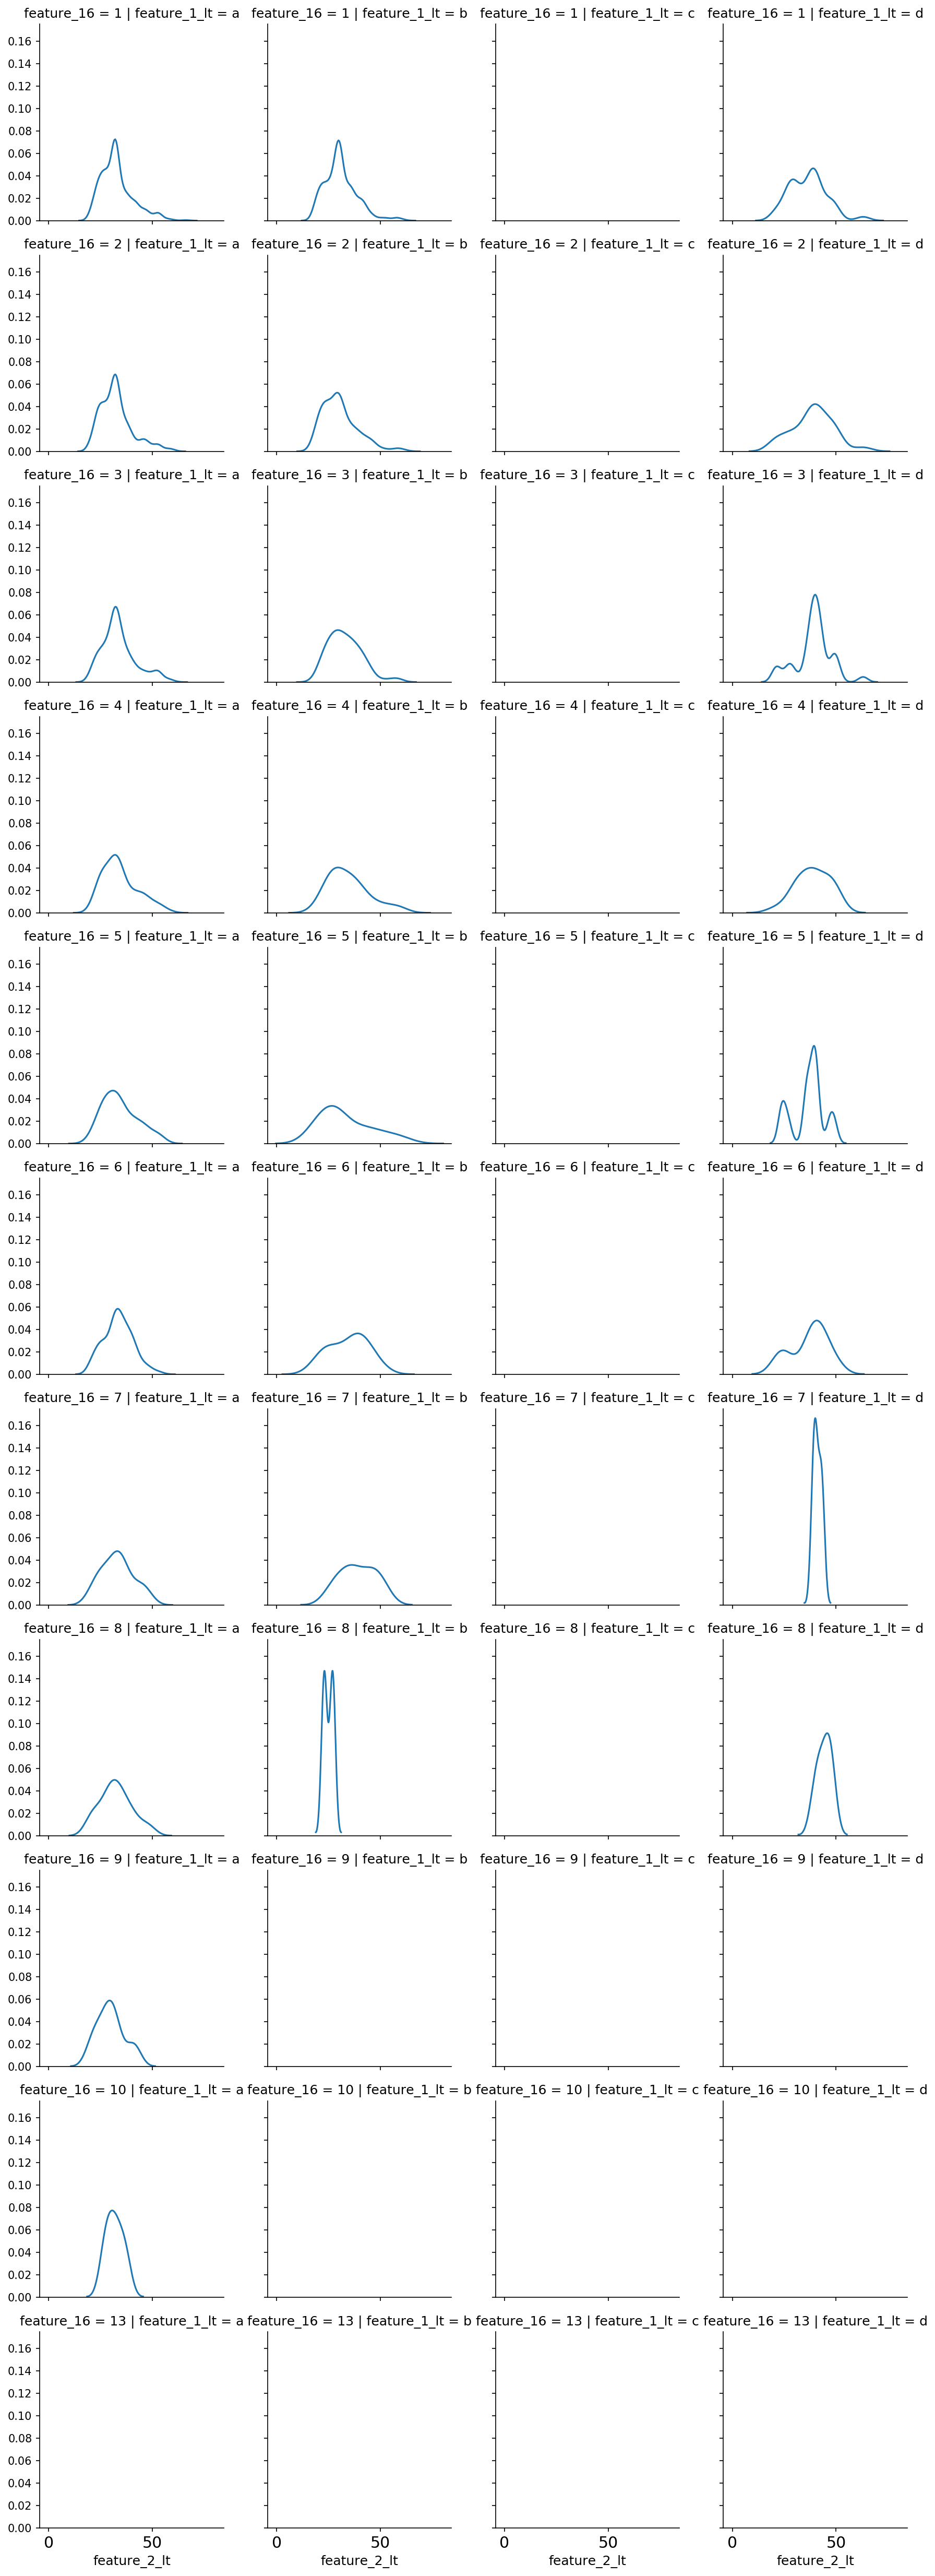

In [272]:
facet_grid = sns.FacetGrid(df, col="feature_1_lt", row="feature_16", col_order=['a','b','c','d'])
facet_grid.map(sns.kdeplot, "feature_2_lt")

We show the correlation between the most correlated numerical features.

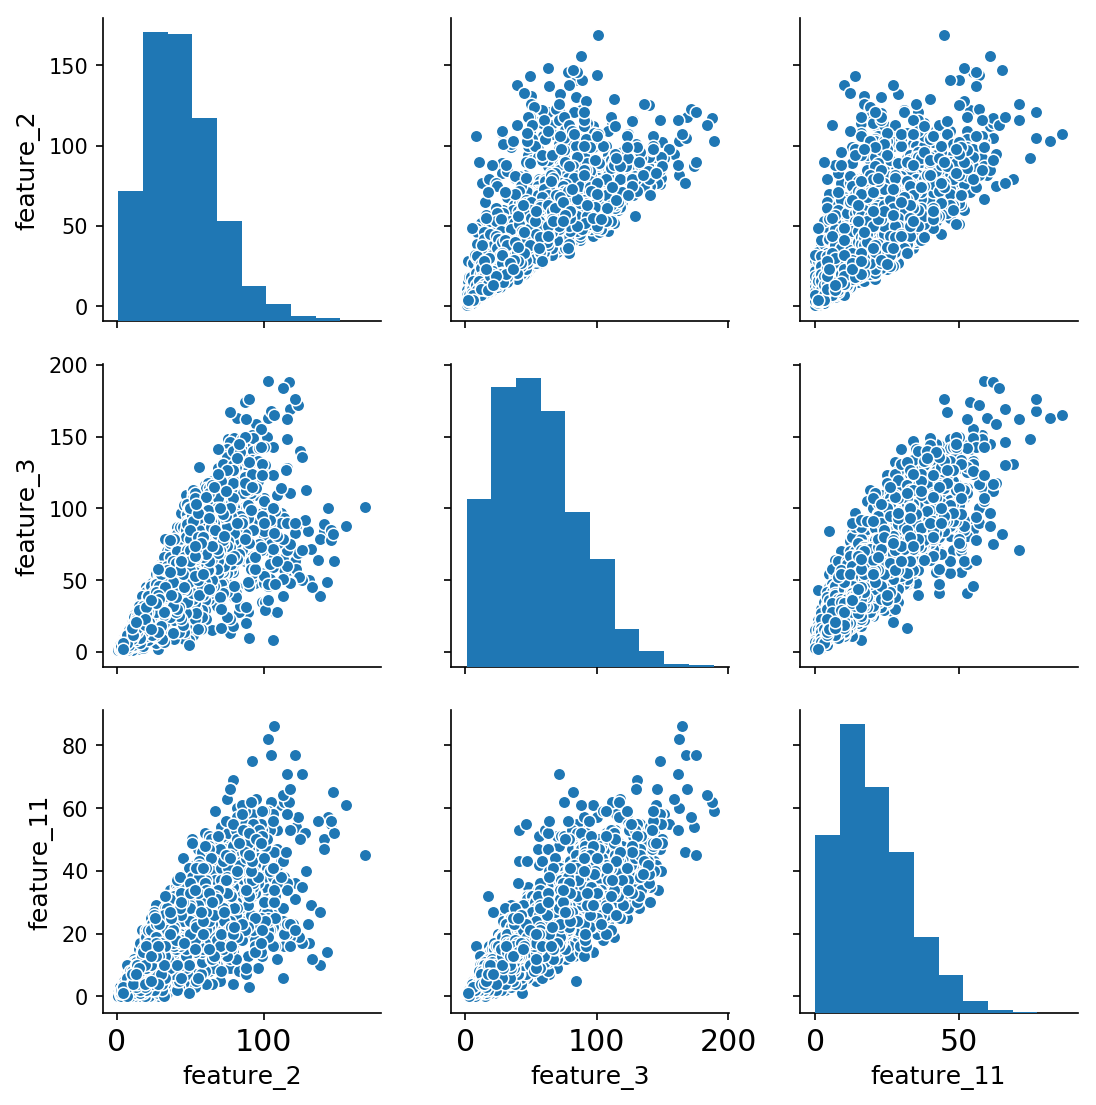

In [273]:
sns.pairplot(df[['feature_2', 'feature_3', 'feature_11']])

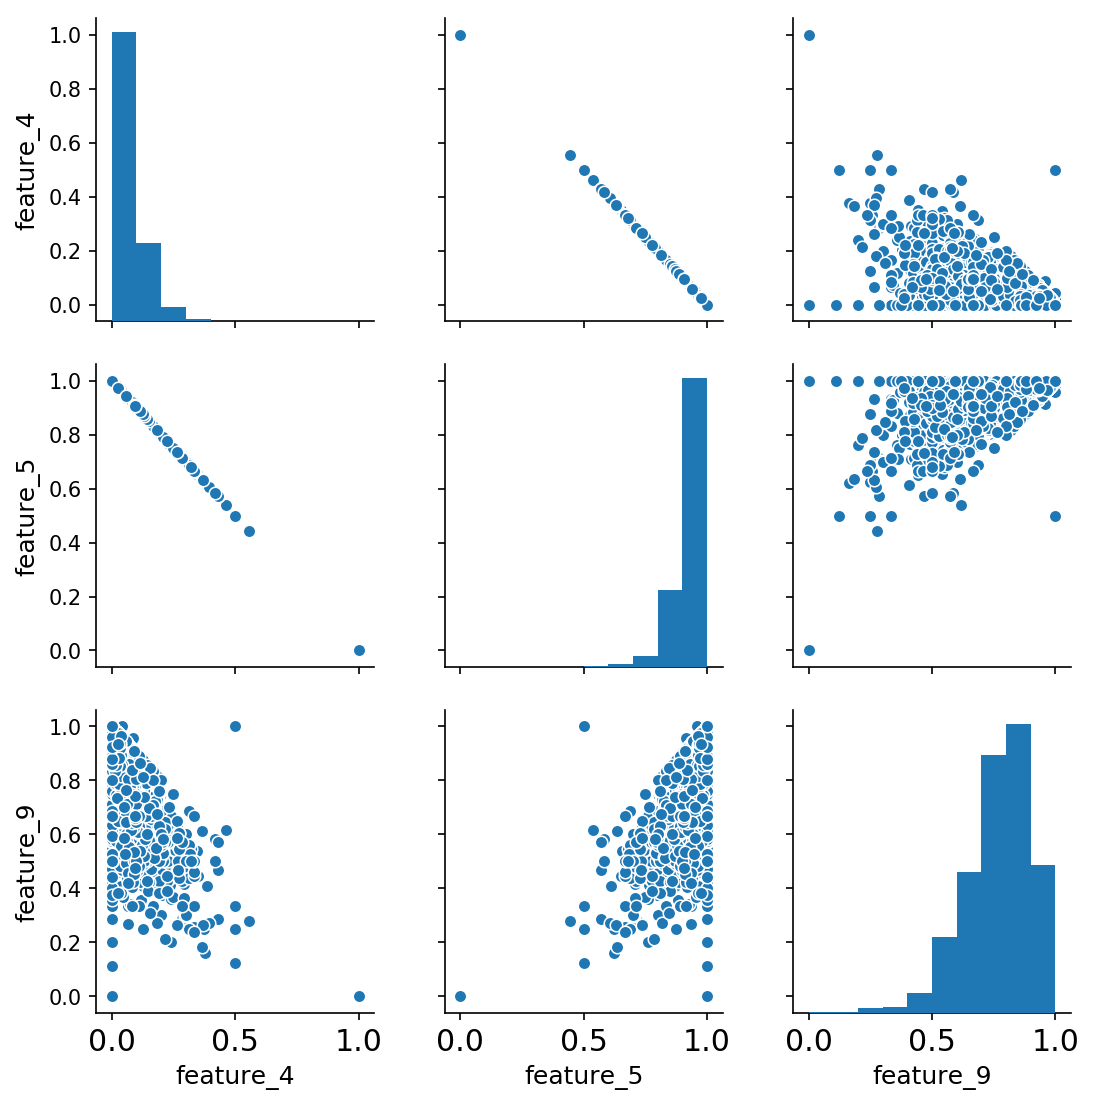

In [274]:
sns.pairplot(df[['feature_4', 'feature_5', 'feature_9']])

##### Observations on bivariate and multivariate analysis:
* feature_1_lt (categorical) seems to have a slight impact on feature_2_lt, which we have used to impute the missing feature_2_lt values.
* feature_1_lt (categorical) has an important correlation with feature_8 and feature_13.
* There is no correlation between the two categorical variables of our data (feature_1_lt and feature_16)
* feature_16 does not have an important impact on feature_2_lt.
* feature_2, feature_3 and feature_11 are highly correlated. They show a positive linear correlation.
* feature_4, feauture_5 and feature_9 are highly correlated. In fact, feature_4 and feature_5 are perfectly correlated, which leads to the **Multicollinearity problem**.

### Feature engineering

We are going to use the knowledge obtained from the exploratory data analysis to process and transform the features in such a way the data becomes manageable by a machine learning algorithm.

#### Processing feature_1_lt

The variable feature_1_lt is a nominal categorical variable. Our model algorithm can only handle numeric values and so we need to create a new variable (dummy variable) for every unique value of the categorical variable. This variable will have a value 1 if the row has a particular value and a value 0 if not.

In [275]:
df_feature_1_lt = pd.get_dummies(df.feature_1_lt , prefix='feature_1_lt')
df_feature_1_lt.head()

feature_1_lt_a  feature_1_lt_b  feature_1_lt_c  feature_1_lt_d
0               0               1               0               0
1               0               1               0               0
2               0               1               0               0
3               0               1               0               0
4               1               0               0               0

In [276]:
df = pd.concat([df, df_feature_1_lt], axis=1)
df.drop('feature_1_lt', axis=1, inplace=True)
df.head()

courier  week  feature_1  feature_2  feature_3  feature_4  feature_5  \
0     3767     2          6         34         38     0.0789     0.9211   
1     3767     4         -1         42         37     0.0000     1.0000   
2     3767     5         24         41         43     0.0233     0.9767   
3     3767     6        -22         65         66     0.0606     0.9394   
4     6282     2          9         33         27     0.0741     0.9259   

   feature_6  feature_7  feature_8  feature_9  feature_10  feature_11  \
0   140.4737     0.1316  2162.4737     0.7632    7.340776           8   
1   135.5946     0.0811  2097.4054     0.9459   11.883784          19   
2   131.0930     0.0233  2043.8837     0.9302    7.072100          16   
3   120.1515     0.0000  2124.2727     0.7727    7.356567          33   
4   100.0000     0.0370  4075.7407     0.8889    8.501233           5   

   feature_12  feature_13  feature_14  feature_15  feature_16  feature_17  \
0   20.208158    5.236316      0.8158   43.384804           1          19   
1   18.855405    5.689459      0.8919   35.078042           3          11   
2   18.925116    5.138605      0.9302   31.455285           1          10   
3   18.259697    4.704394      0.7879   34.252991           1          30   
4   26.863704    4.828519      0.8889   46.478114           1           4   

   feature_2_lt  feature_1_lt_a  feature_1_lt_b  feature_1_lt_c  \
0          33.0               0               1               0   
1          33.0               0               1               0   
2          33.0               0               1               0   
3          33.0               0               1               0   
4          35.0               1               0               0   

   feature_1_lt_d  
0               0  
1               0  
2               0  
3               0  
4               0

#### Processing feature_16

feature_16 is a categorical variable too, but it is an ordinal one. We saw that feature_16 presents a decreasing behaviour: counts decrease as feature_16 increases. Therefore, there is no need to transform it.



#### Multicollinearity problem

As we stated before, we need to fix the Multicollinearity problem before training the model. There are multiple ways to deal with this problem. The easiest way is to delete or eliminate one of the perfectly correlated features. Another way is to use a dimension reduction algorithm such as Principle Component Analysis (PCA). Since we have already identified the most correlated features, we are going to apply the manual method.

In [277]:
df.drop(columns = ['feature_4'], inplace = True)

### Labeling data

As we have seen, there is no target variable in our datasets. All the variables are features that describe the couriers. However, we know we need labeled data in order to apply our supervised learning algorithm: the logistic regression model.

The labeling is performed as follows: If a specific courier’s week 9, 10 and 11 data is not provided, we label this courier as “1” otherwise “0”.

In [278]:
y = df.drop(columns = ['feature_1', 'feature_2', 'feature_3', 'feature_5', 'feature_6',
                             'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12',
                             'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_1_lt_a',
                             'feature_1_lt_b', 'feature_1_lt_c', 'feature_1_lt_d', 'feature_2_lt'])

# create a new column which assigns 1 if week = 9, 10 or 11; 0 otherwise.
y['pre_label'] = np.where((y.week == 9) | (y.week == 10) | (y.week == 11), 1, 0)
y.drop(columns = ['week'], inplace = True)

# group by courier and we sum pre_label values.
y = y.groupby(['courier']).sum()

# if sum=3, data is present in weeks 9,10 and 11.
y['label'] = np.where(y.pre_label == 3, 0, 1)
y.drop(columns = ['pre_label'], inplace = True)

y.head()

label
courier       
3767         1
6282         0
10622        1
13096        0
14261        1

We merge the y dataset with our previous dataset df in order to have same indices. 

In [279]:
df = pd.merge(df, y, on='courier', suffixes=('', ''))
df.head()

courier  week  feature_1  feature_2  feature_3  feature_5  feature_6  \
0     3767     2          6         34         38     0.9211   140.4737   
1     3767     4         -1         42         37     1.0000   135.5946   
2     3767     5         24         41         43     0.9767   131.0930   
3     3767     6        -22         65         66     0.9394   120.1515   
4     6282     2          9         33         27     0.9259   100.0000   

   feature_7  feature_8  feature_9  feature_10  feature_11  feature_12  \
0     0.1316  2162.4737     0.7632    7.340776           8   20.208158   
1     0.0811  2097.4054     0.9459   11.883784          19   18.855405   
2     0.0233  2043.8837     0.9302    7.072100          16   18.925116   
3     0.0000  2124.2727     0.7727    7.356567          33   18.259697   
4     0.0370  4075.7407     0.8889    8.501233           5   26.863704   

   feature_13  feature_14  feature_15  feature_16  feature_17  feature_2_lt  \
0    5.236316      0.8158   43.384804           1          19          33.0   
1    5.689459      0.8919   35.078042           3          11          33.0   
2    5.138605      0.9302   31.455285           1          10          33.0   
3    4.704394      0.7879   34.252991           1          30          33.0   
4    4.828519      0.8889   46.478114           1           4          35.0   

   feature_1_lt_a  feature_1_lt_b  feature_1_lt_c  feature_1_lt_d  label  
0               0               1               0               0      1  
1               0               1               0               0      1  
2               0               1               0               0      1  
3               0               1               0               0      1  
4               1               0               0               0      0

After labeling, we are asked to remove week 8, 9, 10 and 11 data to avoid bias in the predictive algorithm. Bias is the difference between the average prediction of our model and the correct value which we are trying to predict. Model with high bias pays very little attention to the training data and oversimplifies the model.

In [280]:
# Get names of indexes
indexNames = df[(df.week == 8) | (df.week == 9) | (df.week == 10) | (df.week == 11)].index
 
# Delete these row indexes from dataFrame
df.drop(indexNames, inplace=True)

df.reset_index(inplace=True, drop=True)
df.head()

courier  week  feature_1  feature_2  feature_3  feature_5  feature_6  \
0     3767     2          6         34         38     0.9211   140.4737   
1     3767     4         -1         42         37     1.0000   135.5946   
2     3767     5         24         41         43     0.9767   131.0930   
3     3767     6        -22         65         66     0.9394   120.1515   
4     6282     2          9         33         27     0.9259   100.0000   

   feature_7  feature_8  feature_9  feature_10  feature_11  feature_12  \
0     0.1316  2162.4737     0.7632    7.340776           8   20.208158   
1     0.0811  2097.4054     0.9459   11.883784          19   18.855405   
2     0.0233  2043.8837     0.9302    7.072100          16   18.925116   
3     0.0000  2124.2727     0.7727    7.356567          33   18.259697   
4     0.0370  4075.7407     0.8889    8.501233           5   26.863704   

   feature_13  feature_14  feature_15  feature_16  feature_17  feature_2_lt  \
0    5.236316      0.8158   43.384804           1          19          33.0   
1    5.689459      0.8919   35.078042           3          11          33.0   
2    5.138605      0.9302   31.455285           1          10          33.0   
3    4.704394      0.7879   34.252991           1          30          33.0   
4    4.828519      0.8889   46.478114           1           4          35.0   

   feature_1_lt_a  feature_1_lt_b  feature_1_lt_c  feature_1_lt_d  label  
0               0               1               0               0      1  
1               0               1               0               0      1  
2               0               1               0               0      1  
3               0               1               0               0      1  
4               1               0               0               0      0

We split the dataset into x and y data.

In [281]:
x, y = df.loc[:, df.columns != 'label'], df.label

We also drop columns courier and week since they are non-informative and do not contribute to the target variable. 

In [282]:
x.drop(columns = ['courier', 'week'], inplace = True)

In [283]:
x.head()

feature_1  feature_2  feature_3  feature_5  feature_6  feature_7  \
0          6         34         38     0.9211   140.4737     0.1316   
1         -1         42         37     1.0000   135.5946     0.0811   
2         24         41         43     0.9767   131.0930     0.0233   
3        -22         65         66     0.9394   120.1515     0.0000   
4          9         33         27     0.9259   100.0000     0.0370   

   feature_8  feature_9  feature_10  feature_11  feature_12  feature_13  \
0  2162.4737     0.7632    7.340776           8   20.208158    5.236316   
1  2097.4054     0.9459   11.883784          19   18.855405    5.689459   
2  2043.8837     0.9302    7.072100          16   18.925116    5.138605   
3  2124.2727     0.7727    7.356567          33   18.259697    4.704394   
4  4075.7407     0.8889    8.501233           5   26.863704    4.828519   

   feature_14  feature_15  feature_16  feature_17  feature_2_lt  \
0      0.8158   43.384804           1          19          33.0   
1      0.8919   35.078042           3          11          33.0   
2      0.9302   31.455285           1          10          33.0   
3      0.7879   34.252991           1          30          33.0   
4      0.8889   46.478114           1           4          35.0   

   feature_1_lt_a  feature_1_lt_b  feature_1_lt_c  feature_1_lt_d  
0               0               1               0               0  
1               0               1               0               0  
2               0               1               0               0  
3               0               1               0               0  
4               1               0               0               0

In [284]:
y.head()
#y.value_counts()

0    1
1    1
2    1
3    1
4    0
Name: label, dtype: int32

## Task 2: Create a Predictive Algorithm

Once we have the data ready to be managed by a machine learning algorithm, we proceed to train the model. We are going to use a logistic regression model. Logistic regression measures the relationship between the categorical dependent variable (target) and one or more independent variables (features) by estimating probabilities using a logistic function, which is the cumulative logistic distribution.

### Train / Test split

Learning the parameters of a prediction function and testing it on the same data is a methodological mistake: a model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data. This situation is called overfitting. To avoid it, it is common practice when performing a (supervised) machine learning experiment to hold out part of the available data as a **test set**. We are going to hold out 20% of the data for testing (evaluating) our classifier.

In [285]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

### Standardization

As we saw during the exploratory data analysis, most of our numeric features have skewed distributions. Dealing with skew data can cause a lot of issues and adversely affect the model. In order to solve this, we can apply a logarithm transformation to make distributions more approximate to normal. Another option is to standardize the data. 

Standardization of datasets is a common requirement for many machine learning estimators; they might behave badly if the individual features do not more or less look like standard normally distributed data: Gaussian with zero mean and unit variance. 

Even though standardization is not required for logistic regression, it clearly helps the convergence of the algorithm. We have compared performances with and without standardization and we have found similar scores but faster convergence with standardtization.

In [286]:
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

### Model fitting and Hyperparameter tuning

When evaluating different settings (**hyperparameters**) for estimators, there is still a risk of overfitting on the test set because the parameters can be tweaked until the estimator performs optimally. To solve this problem, yet another part of the dataset can be held out as a so-called **validation set**: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set. However, by partitioning the available data into three sets, we drastically reduce the number of samples which can be used for learning the model. A solution to this problem is a procedure called **cross-validation (CV)**.

We are going to use the **Grid Search** method with cross-validation to tune our hyperparameters.

In [287]:
log_reg = LogisticRegression()

# parameter grid for logistic regression
param_grid = [
    {'penalty' : ['l1', 'l2'], # l1 lasso l2 ridge
    'C' : np.logspace(-4, 4, 20), # Inverse of regularization strength, smaller values specify stronger regularization
    'solver' : ['liblinear']} # The ‘liblinear’ solver supports both L1 and L2 regularization
]

# define the model
grid_search = GridSearchCV(log_reg, param_grid = param_grid, scoring='accuracy', cv = 5, verbose=True, n_jobs=-1)
# n_jobs = -1 means using all processors

# fit on data
best_clf = grid_search.fit(x_train, y_train)

print("Best hyperparameters:", best_clf.best_params_)
print("Accuracy:", best_clf.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   11.2s


Best hyperparameters: {'C': 0.23357214690901212, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.759504132231405


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   12.2s finished


#### Why have we used Grid Search?

Grid search trains the algorithm for all possible combinations of the provided set (parameter grid) and measures the performance using the cross validation technique. This validation technique gives assurance that our trained model got most of the patterns from the dataset. On the other hand, randomized search samples a given number of candidates from the set with a specified distribution.

One of the major drawbacks of grid search is that when it comes to dimensionality, it suffers when the number of hyperparameters grows exponentially. In such case, we resort to the randomized search method, since the runtime is drastically lower. Generally, the performance is slightly worse for the randomized search.

In our case, we were only interested in studying the parameters related to regularization. We ended up with a small set of combinations and the runtime was small. Therefore, we are satisfied with the chosen method.

Notice that model-evaluation tools using cross-validation (such as Grid Search) rely on an internal scoring strategy. This score is not the final evaluation. The final evaluation will be obtained later using a specific metric function.

## Task 3: Evaluating the Model

We are going to use our **test set** (20% of the data) to perform the final evaluation of our classifier. We use the x_test set to predict the output obtained from our model. Then, we use the y_test set to evaluate the performance using a specific metric function.

####  Which metric do we choose?

Given our output variable (y), which is a categorical binary variable, we need a classification metric. The metric to choose not only depends on the target variable but also on the description of the problem.

First of all, we are going to generate a **confusion matrix**, which is a specific table layout that allows visualization of the performance of the algorithm. It shows the distribution of true positives, false negatives, false positives and true negatives. Using these proportions, we can derive which metric function to use.

One may think about using the accuracy metric since it is the most intuitive performance measure. It is simply a ratio of correctly predicted observations to the total observations. However, accuracy is only a great measure when you have symmetric datasets where values of false positive and false negatives are almost the same. It is clearly not our case since we have many more 1s than 0s.

One may consider using the Precision or Recall metrics. Using one or the other depends on how much you want to avoid false positives versus false negatives. High precision relates to the low false positive rate. High recall relates to the low false negative rate. In our problem we want to weight both errors equally, but we have an uneven class distribution. In such case, one should use the **F1 Score**, which is the weighted average of Precision and Recall.

In [288]:
# predict some output values
y_pred = best_clf.predict(x_test)

#print('Accuracy score: ', accuracy_score(y_test, y_pred))

print('Confusion matrix score: \n', confusion_matrix(y_test, y_pred))
# true positive | false positive
# false negative | true negative 

print('F1 Score: ', f1_score(y_test, y_pred))

Confusion matrix score: 
 [[ 38 111]
 [ 28 428]]
F1 Score:  0.8603015075376884
